In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300

## True forecast covariance

In [2]:
N = 100
d1 = 1
d2 = 8
Pt = np.eye(N)
for i in range(N):
    for j in range(N):
        Pt[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 

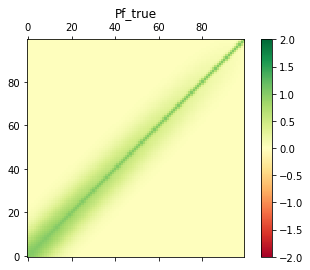

In [3]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'RdYlGn'
fig, ax = plt.subplots()
mappable = ax.matshow(Pt, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title('Pf_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig('Pf_true.pdf')
plt.show()

In [4]:
from scipy.linalg import eigh, norm
eigs, eigv = eigh(Pt)
sPt = eigv @ np.diag(np.sqrt(eigs))
print(sPt.shape)
print(norm(Pt - sPt@sPt.transpose()))

(100, 100)
6.341124912457197e-14


## localization matrix

In [5]:
d1 = 1*3.0
d2 = 8*3.0
Ftilde = np.eye(N)
for i in range(N):
    for j in range(N):
        Ftilde[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 
eigs, eigv = eigh(Ftilde)
neig = 1
thres = 0.85
frac = 0.0
while frac < thres:
    frac = eigs[N-neig:N].sum() / eigs.sum()
    neig += 1
print(neig)
Wtilde = eigv[:,N-neig:N] @ np.diag(np.sqrt(eigs[N-neig:N]))
Flow = Wtilde @ Wtilde.transpose()

11


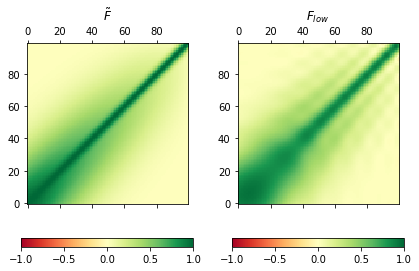

In [6]:
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(Ftilde, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r'$\tilde{F}$')
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(Flow, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[1].invert_yaxis()
ax[1].set_title(r'$F_{low}$')
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

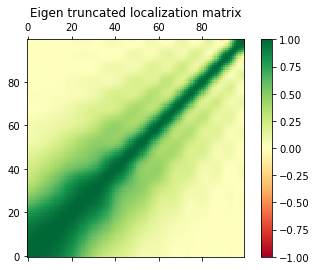

In [7]:
W = Wtilde
diagF = np.diag(Flow)
for i in range(W.shape[0]):
    W[i, :] /= np.sqrt(diagF[i])
F = W @ W.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(F, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'Eigen truncated localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

In [8]:
def calc_dist(i):
    d1 = 1
    d2 = 8
    dist = np.zeros(N)
    for j in range(N):
        dist[j] = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

def calc_dist1(i,j):
    d1 = 1
    d2 = 8
    dist = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

## Observation operator and error covariance

In [9]:
class Obs():
    def __init__(self, operator, sigma,Pt):
        self.operator=operator
        self.sigma=sigma
        self.Pt = Pt
        logger.info(f"operator={self.operator}, sigma={self.sigma}")
    
    def get_op(self):
        return self.operator
    
    def get_sig(self):
        return self.sigma
        
    def set_r(self, N):
        from scipy.linalg import inv
        oberrstdev = self.sigma
        oberrvar = oberrstdev**2
        H = self.dh_operator(np.arange(N), np.zeros(N))
        HPHt = H @ self.Pt @ H.transpose()
        R = oberrvar * np.diag(np.diag(HPHt))
        Rsqrt = oberrstdev * np.diag(np.sqrt(np.diag(HPHt)))
        Rsqrtinv = inv(Rsqrt)
        Rinv = Rsqrtinv.transpose() @ Rsqrtinv
        return R, Rsqrtinv, Rinv
    
    def dh_operator(self, obsloc, x):
        p = obsloc.size
        n = x.size
        H = np.zeros((p,n))
        logger.debug(f"H={H.shape}")
        smooth_len = 4.0
        for j in range(p):
            for i in range(n):
                rr = float(i)-obsloc[j]
                r = np.fabs(rr) / smooth_len
                H[j,i] = np.exp(-r**2)
            H[j,:] = H[j,:]/H[j,:].sum()
        return H
    
    def h_operator(self,obsloc,x):
        if x.ndim > 1:
            hx = self.dh_operator(obsloc,x[:,0]) @ x
        else:
            hx = self.dh_operator(obsloc,x) @ x
        logger.debug(f"hx={hx.shape}")
        return hx

In [10]:
import logging
from logging.config import fileConfig
fileConfig('logging_config.ini')
logger = logging.getLogger('anl')
oberrstdev = 1.0 / 8.0
obs = Obs('vint', oberrstdev,Pt)

2021-09-07 11:11:43,830 anl INFO operator=vint, sigma=0.125


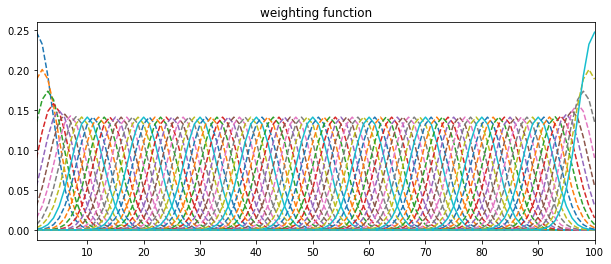

In [11]:
p = N #observed all grid
H = obs.dh_operator(np.arange(p), np.zeros(N))
vindex = np.arange(1,p+1)
fig, ax = plt.subplots(figsize=(10,4))
for j in range(p):
    if np.mod(j+1,10) == 0:
        linestyle='solid'
    else:
        linestyle='dashed'
    ax.plot(vindex,H[j], linestyle=linestyle)
ax.set_xlim(vindex[0],vindex[-1])
ax.set_xticks(vindex[9::10])
ax.set_title('weighting function')
#fig.savefig('Hrow.pdf')
plt.show()

(100, 100) (100, 100) (100, 100)
1.6063764188150566e-17
0.0


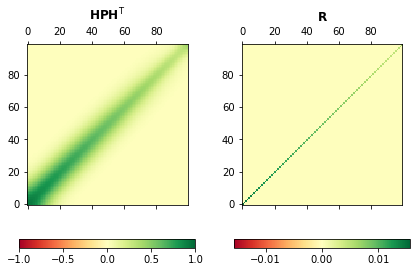

In [12]:
from scipy.linalg import inv
H = obs.dh_operator(np.arange(N), np.zeros(N))
oberrvar = obs.get_sig()**2
HPHt = H @ Pt @ H.transpose()
R, Rsqrtinv, Rinv = obs.set_r(N)
print(R.shape, Rsqrtinv.shape, Rinv.shape)
Rsqrt = inv(Rsqrtinv)
print(norm(R - Rsqrt@Rsqrt))
print(norm(Rinv - Rsqrtinv@Rsqrtinv))
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(HPHt, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r"$\mathbf{H}\mathbf{P}\mathbf{H}^\mathrm{T}$")
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(R, cmap=cmap, norm=Normalize(vmin=-oberrvar, vmax=oberrvar))
ax[1].invert_yaxis()
ax[1].set_title(r"$\mathbf{R}$")
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

## Varidation

In [13]:
def mse(Pa_app):
    diff = np.zeros_like(Pa_app)
    for j in range(N):
        for i in range(N):
            diff[j,i] = (Pa_app[j,i] - Pat[j,i])**2
    diff = F * diff
    mse = diff.sum()
    mse /= N**2
    return mse

def corr(Pa_app):
    tmp = Pa_app**2
    var1 = tmp.sum()
    tmp = Pat**2
    var2 = tmp.sum()
    tmp = Pa_app * Pat
    cov = tmp.sum()
    corr = cov / np.sqrt(var1) / np.sqrt(var2)
    return corr

## Lists for storing results and counter

In [14]:
xrmse_mean = []
mse_mean = []
corr_mean = []
ntest = 0

### Test

## Random seed

In [15]:
rs = np.random.RandomState() #variable
rstrue = np.random.RandomState(514) #fix

## True state and observation

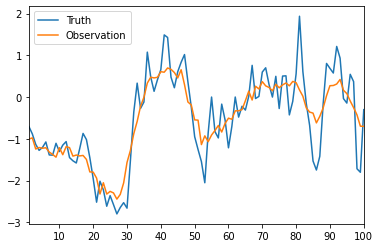

In [16]:
xt = sPt @ rstrue.standard_normal(size=N)
y = obs.dh_operator(np.arange(p), xt) @ xt + Rsqrt @ rs.standard_normal(size=p)
plt.plot(vindex, xt, label='Truth')
plt.plot(vindex, y, label='Observation')
plt.xticks(vindex[9::10])
plt.xlim(vindex[0],vindex[-1])
plt.legend()
#plt.savefig('true_obs.pdf')
plt.show()

## Forecast ensemble

In [17]:
K = 50
Xf = rs.standard_normal(size=(N,K))
Xf = sPt @ Xf
Xf = Xf - Xf.mean(axis=1)[:, None]
Pe = Xf @ Xf.transpose() / (K-1)
err = norm(Pt - Pe)
print(err)

13.040417623241252


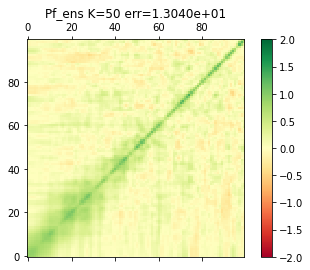

In [18]:
fig, ax = plt.subplots()
mappable = ax.matshow(Pe, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_ens_{K}.pdf')
plt.show()

7.382605943016363


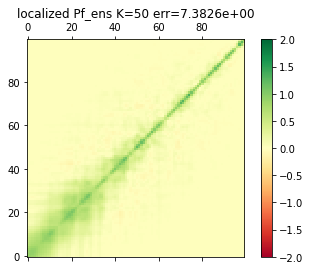

In [19]:
Ploc = Pe * F
err = norm(Pt - Ploc)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Ploc, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'localized Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_locens_{K}.pdf')
plt.show()

(100, 50)
1.2576255262244644


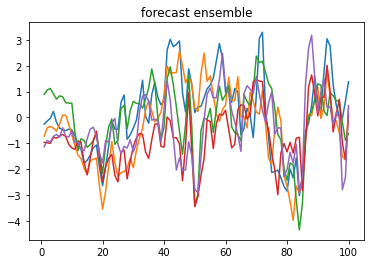

In [20]:
# forecast ensemble
## mean
xf_ = sPt @ rs.standard_normal(size=N)
## member
xf = xf_[:, None] + Xf
print(xf.shape)
initial_mean_err = np.sqrt(((xf.mean(axis=1) - xt)**2).mean())
print(initial_mean_err)
for k in range(0,K,10):
    plt.plot(vindex, xf[:,k])
plt.title('forecast ensemble')
plt.show()

7.382605943016363


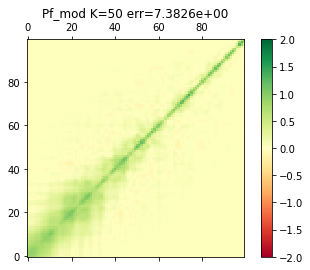

In [21]:
# modulated ensemble
L = W.shape[1]
M = K*L
Xfm = np.empty((N, M), Xf.dtype)
for l in range(L):
    for k in range(K):
        m = l*K + k
        Xfm[:, m] = W[:, l] * Xf[:, k]
Xfm *= np.sqrt((M-1)/(K-1))
Pmod = Xfm @ Xfm.transpose() / (M-1)
err = norm(Pt - Pmod)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Pmod, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_mod K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_modens_{K}.pdf')
plt.show()

In [22]:
# compute true analysis error covariance for modulated ensemble
Htilde = Rsqrtinv @ obs.dh_operator(np.arange(p), xf_)
Z = Xfm / np.sqrt(M-1)
HZ = Htilde @ Z
A = HZ.transpose() @ HZ
eigs, eigv = eigh(A)
Dsqrt = np.sqrt(1.0/(1.0+eigs))
T = eigv @ np.diag(Dsqrt) @ eigv.transpose()
Za = Z @ T
Kmat = Za @ Za.transpose() @ Htilde.transpose()

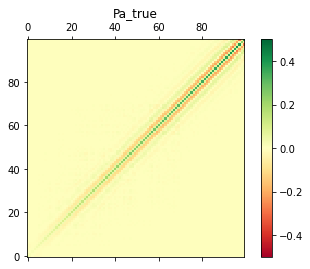

In [23]:
KHP = Kmat @ Htilde @ Pt
Pat = Pt - KHP - KHP.transpose() + Kmat@(Htilde@Pt@Htilde.transpose()+np.eye(p))@Kmat.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pat, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title('Pa_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig('Pa_true.pdf')
plt.show()

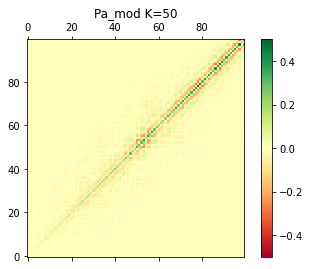

In [24]:
Pam = Za @ Za.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pam, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title(f'Pa_mod K={K}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pa_modens_{K}.pdf')
plt.show()

## EnKF

2021-09-07 11:11:46,320 anl INFO model : model
2021-09-07 11:11:46,321 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:46,321 anl INFO linf=False iloc=None ltlm=False
2021-09-07 11:11:46,395 anl INFO set R
2021-09-07 11:11:46,461 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:46,646 anl INFO save_dh=False cycle0
2021-09-07 11:11:46,842 anl INFO converge gmat, iter_num=3, norm=4.6327162386241555e-07
2021-09-07 11:11:46,843 anl INFO err=0.34354968167914607
2021-09-07 11:11:46,845 anl INFO dof=0.6034199356441213


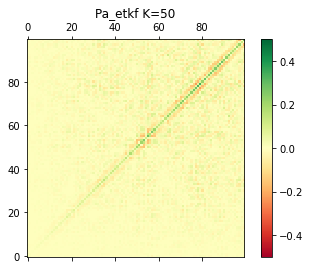

2021-09-07 11:11:47,033 anl INFO model : model
2021-09-07 11:11:47,034 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:47,035 anl INFO linf=False iloc=2 ltlm=False
2021-09-07 11:11:47,102 anl INFO set R
2021-09-07 11:11:47,159 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:47,160 anl INFO ==B-localization==, lsig=3.0
2021-09-07 11:11:47,160 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:11:47,165 anl INFO dxf.shape=(100, 550)
2021-09-07 11:11:47,504 anl INFO save_dh=False cycle0
2021-09-07 11:11:47,585 anl INFO random sampling
2021-09-07 11:11:47,595 anl INFO standard deviation ratio = 1.0047675181963855
2021-09-07 11:11:47,821 anl INFO converge gmat, iter_num=2, norm=1.3156185973445846e-06
2021-09-07 11:11:47,828 anl INFO err=1.4984586968037843
2021-09-07 11:11:47,847 anl INFO dof=0.7303992649394925


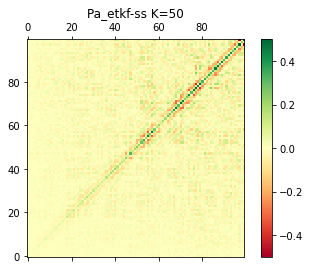

2021-09-07 11:11:48,039 anl INFO model : model
2021-09-07 11:11:48,040 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:48,040 anl INFO linf=False iloc=2 ltlm=False
2021-09-07 11:11:48,105 anl INFO set R
2021-09-07 11:11:48,167 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:48,168 anl INFO ==B-localization==, lsig=3.0
2021-09-07 11:11:48,168 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:11:48,173 anl INFO dxf.shape=(100, 550)
2021-09-07 11:11:48,493 anl INFO save_dh=False cycle0
2021-09-07 11:11:48,565 anl INFO Gain ETKF
2021-09-07 11:11:48,576 anl INFO standard deviation ratio = 1.0489584189958157
2021-09-07 11:11:48,817 anl INFO converge gmat, iter_num=2, norm=1.3156185973445846e-06
2021-09-07 11:11:48,825 anl INFO err=1.4984586968037843
2021-09-07 11:11:48,844 anl INFO dof=0.7303992649394925


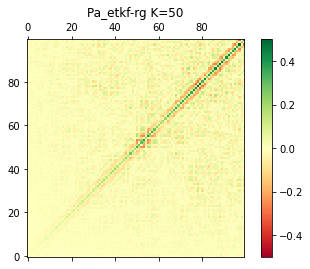

2021-09-07 11:11:49,073 anl INFO model : model
2021-09-07 11:11:49,073 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:49,074 anl INFO linf=False iloc=0 ltlm=False
2021-09-07 11:11:49,138 anl INFO set R
2021-09-07 11:11:49,199 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:49,395 anl INFO save_dh=False cycle0
2021-09-07 11:11:49,397 anl INFO ==K-localization==, lsig=3.0
2021-09-07 11:11:49,669 anl INFO converge gmat, iter_num=3, norm=4.632716238624132e-07
2021-09-07 11:11:49,671 anl INFO err=0.3435496816792565
2021-09-07 11:11:49,673 anl INFO dof=0.6034199356441213


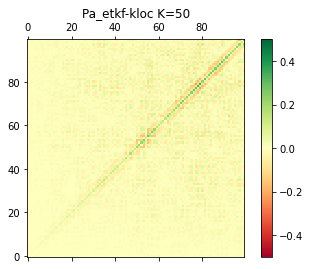

2021-09-07 11:11:49,867 anl INFO model : model
2021-09-07 11:11:49,867 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:49,868 anl INFO linf=False iloc=None ltlm=False
2021-09-07 11:11:49,932 anl INFO set R
2021-09-07 11:11:49,994 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:50,188 anl INFO save_dh=False cycle0
2021-09-07 11:11:50,374 anl INFO converge gmat, iter_num=3, norm=4.6327162386241555e-07
2021-09-07 11:11:50,375 anl INFO err=0.34354968167914607
2021-09-07 11:11:50,378 anl INFO dof=0.6034199356441213


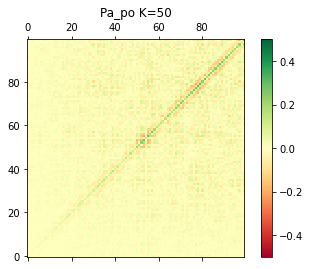

2021-09-07 11:11:50,559 anl INFO model : model
2021-09-07 11:11:50,560 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:50,560 anl INFO linf=False iloc=2 ltlm=False
2021-09-07 11:11:50,618 anl INFO set R
2021-09-07 11:11:50,674 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:50,674 anl INFO ==B-localization==, lsig=3.0
2021-09-07 11:11:50,675 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:11:50,680 anl INFO dxf.shape=(100, 550)
2021-09-07 11:11:50,996 anl INFO save_dh=False cycle0
2021-09-07 11:11:51,265 anl INFO converge gmat, iter_num=2, norm=1.3156185973445846e-06
2021-09-07 11:11:51,270 anl INFO err=1.4984586968037843
2021-09-07 11:11:51,288 anl INFO dof=0.7303992649394925


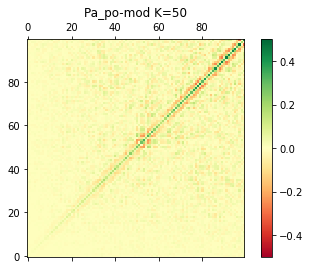

2021-09-07 11:11:51,468 anl INFO model : model
2021-09-07 11:11:51,469 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:51,469 anl INFO linf=False iloc=0 ltlm=False
2021-09-07 11:11:51,531 anl INFO set R
2021-09-07 11:11:51,586 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:51,823 anl INFO save_dh=False cycle0
2021-09-07 11:11:51,826 anl INFO ==K-localization== lsig=3.0
2021-09-07 11:11:52,155 anl INFO converge gmat, iter_num=3, norm=4.632716238624132e-07
2021-09-07 11:11:52,157 anl INFO err=0.3435496816792565
2021-09-07 11:11:52,159 anl INFO dof=0.6034199356441213


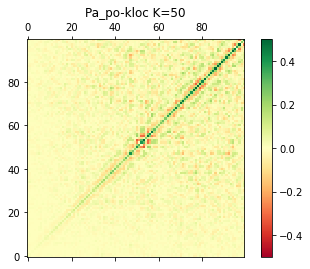

2021-09-07 11:11:52,370 anl INFO model : model
2021-09-07 11:11:52,371 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:52,372 anl INFO linf=False iloc=None ltlm=False
2021-09-07 11:11:52,437 anl INFO set R
2021-09-07 11:11:52,500 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:52,741 anl INFO save_dh=False cycle0
2021-09-07 11:11:53,247 anl INFO converge gmat, iter_num=3, norm=4.632716238624142e-07
2021-09-07 11:11:53,248 anl INFO err=0.34354968167914046
2021-09-07 11:11:53,250 anl INFO dof=0.6034199356441213


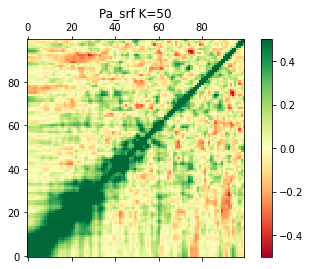

2021-09-07 11:11:53,437 anl INFO model : model
2021-09-07 11:11:53,437 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:53,438 anl INFO linf=False iloc=2 ltlm=False
2021-09-07 11:11:53,500 anl INFO set R
2021-09-07 11:11:53,554 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:53,554 anl INFO ==B-localization==, lsig=3.0
2021-09-07 11:11:53,555 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:11:53,559 anl INFO dxf.shape=(100, 550)
2021-09-07 11:11:53,886 anl INFO save_dh=False cycle0
2021-09-07 11:11:54,236 anl INFO random sampling
2021-09-07 11:11:54,245 anl INFO standard deviation ratio = 1.0257369831545498
2021-09-07 11:11:54,466 anl INFO converge gmat, iter_num=2, norm=1.3156185973445996e-06
2021-09-07 11:11:54,473 anl INFO err=1.498458696803776
2021-09-07 11:11:54,492 anl INFO dof=0.7303992649394925


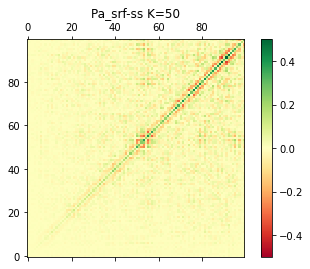

2021-09-07 11:11:54,668 anl INFO model : model
2021-09-07 11:11:54,669 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:54,669 anl INFO linf=False iloc=2 ltlm=False
2021-09-07 11:11:54,727 anl INFO set R
2021-09-07 11:11:54,787 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:54,788 anl INFO ==B-localization==, lsig=3.0
2021-09-07 11:11:54,788 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:11:54,793 anl INFO dxf.shape=(100, 550)
2021-09-07 11:11:55,111 anl INFO save_dh=False cycle0
2021-09-07 11:11:55,797 anl INFO converge gmat, iter_num=2, norm=1.3156185973445996e-06
2021-09-07 11:11:55,804 anl INFO err=1.498458696803776
2021-09-07 11:11:55,823 anl INFO dof=0.7303992649394925


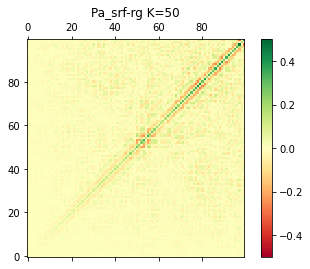

2021-09-07 11:11:56,012 anl INFO model : model
2021-09-07 11:11:56,012 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:56,013 anl INFO linf=False iloc=0 ltlm=False
2021-09-07 11:11:56,070 anl INFO set R
2021-09-07 11:11:56,124 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:56,325 anl INFO save_dh=False cycle0
2021-09-07 11:11:56,325 anl INFO ==K-localization== lsig=3.0
2021-09-07 11:11:56,854 anl INFO converge gmat, iter_num=3, norm=4.6327162473879776e-07
2021-09-07 11:11:56,856 anl INFO err=0.34354968169053723
2021-09-07 11:11:56,857 anl INFO dof=0.6034199356441213


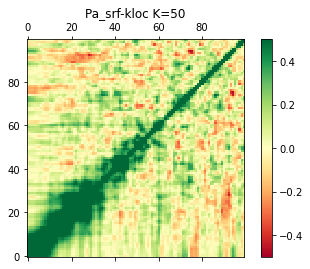

2021-09-07 11:11:57,050 anl INFO model : model
2021-09-07 11:11:57,051 anl INFO pt=letkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:57,051 anl INFO linf=False iloc=0 ltlm=False
2021-09-07 11:11:57,110 anl INFO set R
2021-09-07 11:11:57,165 anl INFO pf max=1.3286985228056314 min=-0.4676675623597412
2021-09-07 11:11:57,356 anl INFO save_dh=False cycle0
2021-09-07 11:11:57,359 anl INFO number of assimilated obs.=100
2021-09-07 11:11:57,360 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,364 anl INFO number of assimilated obs.=75
2021-09-07 11:11:57,365 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,369 anl INFO number of assimilated obs.=61
2021-09-07 11:11:57,370 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,374 anl INFO number of assimilated obs.=55
2021-09-07 11:11:57,375 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,379 anl INFO number of assimilated obs.=52
2021-09-07 11:11:57,380 anl INFO ==R-localization==, lsig=3.0
2021-0

2021-09-07 11:11:57,683 anl INFO number of assimilated obs.=35
2021-09-07 11:11:57,684 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,689 anl INFO number of assimilated obs.=35
2021-09-07 11:11:57,690 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,694 anl INFO number of assimilated obs.=35
2021-09-07 11:11:57,695 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,699 anl INFO number of assimilated obs.=34
2021-09-07 11:11:57,700 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,704 anl INFO number of assimilated obs.=34
2021-09-07 11:11:57,705 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,708 anl INFO number of assimilated obs.=34
2021-09-07 11:11:57,709 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,713 anl INFO number of assimilated obs.=32
2021-09-07 11:11:57,714 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:11:57,719 anl INFO number of assimilated obs.=32
2021-09-07 11:11:57,720 anl INFO ==R-localization==, lsig=3.0


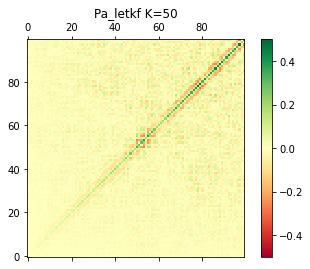

In [25]:
params = {'etkf':('etkf',None,False,False),'etkf-ss':('etkf',2,True,False),'etkf-rg':('etkf',2,False,True),'etkf-kloc':('etkf',0,False,False),
         'po':('po',None,False,False),'po-mod':('po',2,False,False),'po-kloc':('po',0,False,False),
          'srf':('srf',None,False,False),'srf-ss':('srf',2,True,False),'srf-rg':('srf',2,False,True),'srf-kloc':('srf',0,False,False),
         'letkf':('letkf',0,False,False)}
names = ['mod','etkf','etkf-ss','etkf-rg','etkf-kloc','po','po-mod','po-kloc','srf','srf-ss','srf-rg','srf-kloc','letkf']
#names = ['mod','srf','srf-ss','srf-rg','srf-kloc']
xa_list = []
Pa_app_list = [Pam]
from analysis.enkf import EnKF
for ptype in names[1:]:
    pt, iloc, ss, getkf = params[ptype]
    analysis = EnKF(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, getkf=getkf, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    #xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y, np.arange(p))
    #xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, np.roll(y, 50), np.roll(np.arange(p),50))
    #loc = rs.choice(p, size=p, replace=False)
    #print(loc)
    #j = 0
    #ob = np.zeros_like(y)
    #for i in loc:
    #    ob[j] = y[i]
    #    j += 1
    #xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, ob, loc)
    xa_list.append(xa.mean(axis=1))
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    #if ntest == 0:
    #    fig.savefig(f'Pa_{ptype}_{K}_random.pdf')
    plt.show()

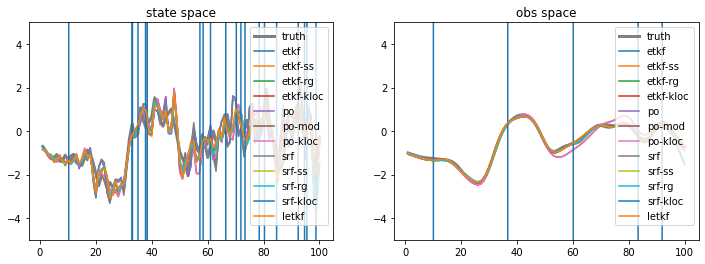

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
xaxis = np.arange(1, N+1)
ax[0].plot(xaxis, xt, linewidth=3.0, color='gray', label='truth')
ax[1].plot(xaxis, H@xt, linewidth=3.0, color='gray', label='truth')
i = 1
for xam in xa_list:
    ax[0].plot(xaxis, xam, linewidth=1.5, label=names[i])
    ax[1].plot(xaxis, H@xam, linewidth=1.5, label=names[i])
    i += 1
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-5.0,5.0)
ax[1].set_ylim(-5.0,5.0)
ax[0].set_title('state space')
ax[1].set_title('obs space')
plt.show()

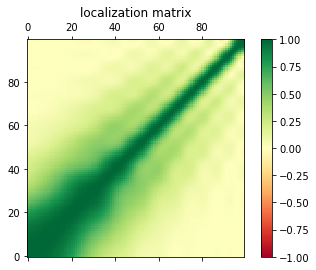

In [27]:
lmat = np.load('model_rho_vint_srf.npy')
fig, ax = plt.subplots()
mappable = ax.matshow(lmat, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

### MLEF

(100, 51)
1.2874652336008925


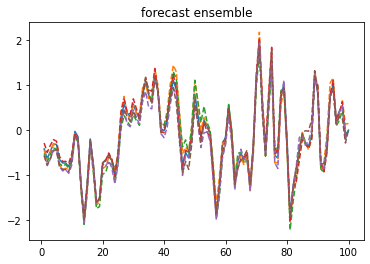

In [28]:
# forecast ensemble
## control
xfc = sPt @ rs.standard_normal(size=N)
## member
xfe = xfc[:, None] + Xf / np.sqrt(K-1)
xf = np.zeros((N,K+1))
xf[:,0] = xfc
xf[:,1:] = xfe
print(xf.shape)
initial_ctrl_err = np.sqrt(((xfc - xt)**2).mean())
print(initial_ctrl_err)
plt.plot(vindex, xf[:,0])
for k in range(1,K+1,10):
    plt.plot(vindex, xf[:,k],linestyle='dashed')
plt.title('forecast ensemble')
plt.show()

2021-09-07 11:11:59,166 anl INFO model : model
2021-09-07 11:11:59,167 anl INFO ndim=100 nmem=50
2021-09-07 11:11:59,167 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:11:59,167 anl INFO linf=False iloc=None ltlm=False incremental=False
2021-09-07 11:11:59,168 anl INFO set R
2021-09-07 11:11:59,442 anl INFO save_dh=False
2021-09-07 11:11:59,446 anl INFO eigen value =[1.88302710e-14 1.91111147e-08 2.61490992e-07 3.14156781e-07
 1.02278129e-06 2.76013221e-06 3.11148727e-06 1.06729045e-05
 1.56387049e-05 3.07050443e-05 5.84194444e-05 2.56397382e-04
 3.47641562e-04 5.89155090e-04 1.12644422e-03 1.81501580e-03
 4.20021843e-03 8.69281468e-03 1.74513729e-02 3.76779765e-02
 4.91213386e-02 8.58898687e-02 9.82033464e-02 1.65891994e-01
 1.99298611e-01 2.79365113e-01 5.66760154e-01 9.32709453e-01
 1.04956601e+00 1.37092520e+00 2.82141520e+00 3.59635027e+00
 7.67932490e+00 1.02572001e+01 1.62445459e+01 1.91732223e+01
 2.86257774e+01 3.98664003e+01 5.65254119e+01 7.42264624e


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.081D+03   GNORM=  9.998D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:01,040 anl INFO minimization success
2021-09-07 11:12:01,041 anl INFO iteration = 1
2021-09-07 11:12:01,041 anl INFO final step-length = 0.9999999999999949
2021-09-07 11:12:01,042 anl INFO final function value = 83.90602201060531
2021-09-07 11:12:01,043 anl INFO final gradient norm = 2.172455712737435e-12


   1   6   8.391D+01   2.172D-12   1.0D+00   4.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:01,197 anl INFO eigen value =[5.81115017e-14 1.91110583e-08 2.61491017e-07 3.14156854e-07
 1.02278132e-06 2.76013206e-06 3.11148734e-06 1.06729044e-05
 1.56387048e-05 3.07050443e-05 5.84194444e-05 2.56397382e-04
 3.47641562e-04 5.89155090e-04 1.12644422e-03 1.81501580e-03
 4.20021843e-03 8.69281468e-03 1.74513729e-02 3.76779765e-02
 4.91213386e-02 8.58898687e-02 9.82033464e-02 1.65891994e-01
 1.99298611e-01 2.79365113e-01 5.66760154e-01 9.32709453e-01
 1.04956601e+00 1.37092520e+00 2.82141520e+00 3.59635027e+00
 7.67932490e+00 1.02572001e+01 1.62445459e+01 1.91732223e+01
 2.86257774e+01 3.98664003e+01 5.65254119e+01 7.42264624e+01
 8.44440160e+01 1.03877169e+02 1.18498534e+02 1.94459417e+02
 3.09412673e+02 3.88980051e+02 5.82113928e+02 9.83374846e+02
 1.28564412e+03 2.64518799e+03]
2021-09-07 11:12:01,288 anl INFO zmat shape=(100, 50)
2021-09-07 11:12:01,289 anl INFO d shape=(100,)
2021-09-07 11:12:01,293 anl INFO converge gmat, iter_num=3, norm=4.632716238624108e-07
2

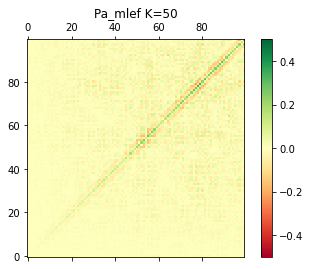

2021-09-07 11:12:01,523 anl INFO model : model
2021-09-07 11:12:01,524 anl INFO ndim=100 nmem=50
2021-09-07 11:12:01,524 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:12:01,525 anl INFO linf=False iloc=2 ltlm=False incremental=False
2021-09-07 11:12:01,527 anl INFO set R
2021-09-07 11:12:01,593 anl INFO ==localization==, lsig=3.0
2021-09-07 11:12:01,594 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:12:01,598 anl INFO pf.shape=(100, 550)
2021-09-07 11:12:01,827 anl INFO save_dh=False
2021-09-07 11:12:01,906 anl INFO eigen value =[-4.20468203e-13 -3.47051489e-13 -2.89806037e-13 -2.33749333e-13
 -1.85948441e-13 -1.60477483e-13 -1.34314413e-13 -1.17827753e-13
 -1.00656134e-13 -9.81031462e-14 -9.32554996e-14 -9.20625763e-14
 -8.96621786e-14 -8.63235967e-14 -8.31319735e-14 -8.25259727e-14
 -8.00950092e-14 -7.19404721e-14 -6.84966247e-14 -6.32418237e-14
 -6.29964776e-14 -6.03414419e-14 -5.89056367e-14 -5.87505676e-14
 -5.61885553e-14 -5.61653331e-14 -5.49

2021-09-07 11:12:01,911 anl INFO method=CGF
2021-09-07 11:12:01,911 anl INFO cgtype: Fletcher-Reeves
2021-09-07 11:12:01,912 anl INFO restart=False
2021-09-07 11:12:01,913 anl INFO save_hist=False
2021-09-07 11:12:02,161 anl INFO initial function value = 5081.4886754454965
2021-09-07 11:12:02,161 anl INFO initial gradient norm = 100.12559611865072



*************************************************
 N=  550

INITIAL VALUES:
 F=  5.081D+03   GNORM=  1.001D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:03,602 anl INFO minimization success
2021-09-07 11:12:03,603 anl INFO iteration = 1
2021-09-07 11:12:03,603 anl INFO final step-length = 0.9999999999999998
2021-09-07 11:12:03,604 anl INFO final function value = 68.92117638791387
2021-09-07 11:12:03,604 anl INFO final gradient norm = 3.230438088036081e-12


   1   6   6.892D+01   3.230D-12   1.0D+00   1.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:03,801 anl INFO eigen value =[-4.31388503e-13 -3.57937138e-13 -2.71537996e-13 -2.24591855e-13
 -1.55181955e-13 -1.52557486e-13 -1.44428652e-13 -1.28582325e-13
 -1.18563838e-13 -1.18138326e-13 -1.05485612e-13 -9.50663825e-14
 -8.83159512e-14 -8.76757779e-14 -8.26313209e-14 -8.25534498e-14
 -8.04895741e-14 -7.40943743e-14 -7.23443630e-14 -7.15788356e-14
 -6.56447815e-14 -6.31246005e-14 -6.26435545e-14 -6.25301676e-14
 -5.34659883e-14 -5.31605654e-14 -5.29158748e-14 -5.00172730e-14
 -4.94011099e-14 -4.68768342e-14 -4.68381443e-14 -4.67857723e-14
 -4.47477501e-14 -4.25809947e-14 -4.07923539e-14 -4.05031097e-14
 -3.87937229e-14 -3.75665835e-14 -3.69406420e-14 -3.67249549e-14
 -3.58237402e-14 -3.58138518e-14 -3.47702184e-14 -3.39689272e-14
 -3.18233033e-14 -3.15312965e-14 -3.04888313e-14 -3.02813113e-14
 -2.96507451e-14 -2.93265167e-14 -2.89203426e-14 -2.82958943e-14
 -2.74194214e-14 -2.65464610e-14 -2.65095390e-14 -2.62147679e-14
 -2.42364618e-14 -2.36471551e-14 -2.35820366

2021-09-07 11:12:03,871 anl INFO zmat shape=(100, 550)
2021-09-07 11:12:03,872 anl INFO d shape=(100,)
2021-09-07 11:12:03,930 anl INFO converge gmat, iter_num=2, norm=1.3156185973445833e-06
2021-09-07 11:12:03,939 anl INFO err=1.498458696803818
2021-09-07 11:12:03,959 anl INFO dof=23.502137845024215
2021-09-07 11:12:03,970 anl INFO standard deviation ratio = 0.9829839244500702


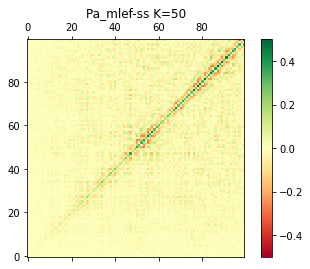

2021-09-07 11:12:04,167 anl INFO model : model
2021-09-07 11:12:04,167 anl INFO ndim=100 nmem=50
2021-09-07 11:12:04,168 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:12:04,168 anl INFO linf=False iloc=2 ltlm=False incremental=False
2021-09-07 11:12:04,170 anl INFO set R
2021-09-07 11:12:04,229 anl INFO ==localization==, lsig=3.0
2021-09-07 11:12:04,230 anl INFO == modulated ensemble, nmode=11 ==
2021-09-07 11:12:04,233 anl INFO pf.shape=(100, 550)
2021-09-07 11:12:04,453 anl INFO save_dh=False
2021-09-07 11:12:04,512 anl INFO eigen value =[-4.20468203e-13 -3.47051489e-13 -2.89806037e-13 -2.33749333e-13
 -1.85948441e-13 -1.60477483e-13 -1.34314413e-13 -1.17827753e-13
 -1.00656134e-13 -9.81031462e-14 -9.32554996e-14 -9.20625763e-14
 -8.96621786e-14 -8.63235967e-14 -8.31319735e-14 -8.25259727e-14
 -8.00950092e-14 -7.19404721e-14 -6.84966247e-14 -6.32418237e-14
 -6.29964776e-14 -6.03414419e-14 -5.89056367e-14 -5.87505676e-14
 -5.61885553e-14 -5.61653331e-14 -5.49

2021-09-07 11:12:04,515 anl INFO method=CGF
2021-09-07 11:12:04,516 anl INFO cgtype: Fletcher-Reeves
2021-09-07 11:12:04,517 anl INFO restart=False
2021-09-07 11:12:04,517 anl INFO save_hist=False
2021-09-07 11:12:04,711 anl INFO initial function value = 5081.4886754454965
2021-09-07 11:12:04,712 anl INFO initial gradient norm = 100.12559611865072



*************************************************
 N=  550

INITIAL VALUES:
 F=  5.081D+03   GNORM=  1.001D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:06,167 anl INFO minimization success
2021-09-07 11:12:06,168 anl INFO iteration = 1
2021-09-07 11:12:06,169 anl INFO final step-length = 0.9999999999999998
2021-09-07 11:12:06,170 anl INFO final function value = 68.92117638791387
2021-09-07 11:12:06,171 anl INFO final gradient norm = 3.230438088036081e-12


   1   6   6.892D+01   3.230D-12   1.0D+00   1.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:06,427 anl INFO eigen value =[-4.31388503e-13 -3.57937138e-13 -2.71537996e-13 -2.24591855e-13
 -1.55181955e-13 -1.52557486e-13 -1.44428652e-13 -1.28582325e-13
 -1.18563838e-13 -1.18138326e-13 -1.05485612e-13 -9.50663825e-14
 -8.83159512e-14 -8.76757779e-14 -8.26313209e-14 -8.25534498e-14
 -8.04895741e-14 -7.40943743e-14 -7.23443630e-14 -7.15788356e-14
 -6.56447815e-14 -6.31246005e-14 -6.26435545e-14 -6.25301676e-14
 -5.34659883e-14 -5.31605654e-14 -5.29158748e-14 -5.00172730e-14
 -4.94011099e-14 -4.68768342e-14 -4.68381443e-14 -4.67857723e-14
 -4.47477501e-14 -4.25809947e-14 -4.07923539e-14 -4.05031097e-14
 -3.87937229e-14 -3.75665835e-14 -3.69406420e-14 -3.67249549e-14
 -3.58237402e-14 -3.58138518e-14 -3.47702184e-14 -3.39689272e-14
 -3.18233033e-14 -3.15312965e-14 -3.04888313e-14 -3.02813113e-14
 -2.96507451e-14 -2.93265167e-14 -2.89203426e-14 -2.82958943e-14
 -2.74194214e-14 -2.65464610e-14 -2.65095390e-14 -2.62147679e-14
 -2.42364618e-14 -2.36471551e-14 -2.35820366

2021-09-07 11:12:06,515 anl INFO zmat shape=(100, 550)
2021-09-07 11:12:06,516 anl INFO d shape=(100,)
2021-09-07 11:12:06,569 anl INFO converge gmat, iter_num=2, norm=1.3156185973445833e-06
2021-09-07 11:12:06,577 anl INFO err=1.498458696803818
2021-09-07 11:12:06,601 anl INFO dof=23.502137845024215
2021-09-07 11:12:06,794 anl INFO standard deviation ratio = 1.0489584189958125


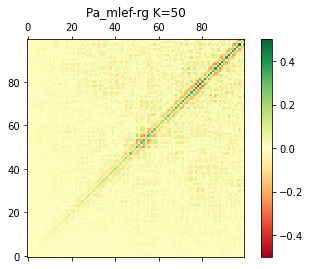

2021-09-07 11:12:07,040 anl INFO model : model
2021-09-07 11:12:07,041 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 11:12:07,041 anl INFO linf=False ltlm=False incremental=False
2021-09-07 11:12:07,042 anl INFO set R
2021-09-07 11:12:07,348 anl INFO save_dh=False
2021-09-07 11:12:07,349 anl INFO save_hist=False
2021-09-07 11:12:07,350 anl INFO ==R-localization==, lsig=3.0
2021-09-07 11:12:07,353 anl INFO Number of assimilated obs.=100
2021-09-07 11:12:07,357 anl INFO eigen value =[-3.38104525e-14  1.25177285e-08  1.11163469e-07  1.38821696e-07
  4.49539694e-07  1.23328143e-06  1.68539533e-06  5.58859469e-06
  8.22325378e-06  1.16972559e-05  3.70000090e-05  1.10093548e-04
  1.89087429e-04  3.25150392e-04  5.71981291e-04  8.21465897e-04
  2.79118343e-03  4.10796191e-03  8.18238871e-03  1.88079569e-02
  2.46195386e-02  3.62674986e-02  5.40116742e-02  6.88811020e-02
  9.41355307e-02  1.22146775e-01  2.46452986e-01  4.86032350e-01
  5.15101784e-01  8.78555424e-01  1.


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.392D+03   GNORM=  8.165D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:08,874 anl INFO minimization success
2021-09-07 11:12:08,875 anl INFO iteration = 1
2021-09-07 11:12:08,876 anl INFO final step-length = 1.0000000000000033
2021-09-07 11:12:08,876 anl INFO final function value = 59.05279311086856
2021-09-07 11:12:08,877 anl INFO final gradient norm = 2.1685509970206322e-12


   1   5   5.905D+01   2.169D-12   1.0D+00   7.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:09,027 anl INFO eigen value =[4.19032465e-14 1.25176959e-08 1.11163522e-07 1.38821738e-07
 4.49539783e-07 1.23328143e-06 1.68539549e-06 5.58859481e-06
 8.22325384e-06 1.16972559e-05 3.70000091e-05 1.10093548e-04
 1.89087429e-04 3.25150392e-04 5.71981291e-04 8.21465897e-04
 2.79118343e-03 4.10796191e-03 8.18238871e-03 1.88079569e-02
 2.46195386e-02 3.62674986e-02 5.40116742e-02 6.88811020e-02
 9.41355307e-02 1.22146775e-01 2.46452986e-01 4.86032350e-01
 5.15101784e-01 8.78555424e-01 1.35295261e+00 1.92893866e+00
 4.10633727e+00 5.00509940e+00 6.41791076e+00 1.02310394e+01
 1.13937484e+01 2.05171258e+01 2.57952469e+01 2.73555126e+01
 3.43478886e+01 4.07684632e+01 7.91038981e+01 1.02881373e+02
 1.26024057e+02 1.73387965e+02 2.48202704e+02 4.57638424e+02
 9.85550846e+02 2.21160077e+03]
2021-09-07 11:12:09,029 anl INFO Number of assimilated obs.=75
2021-09-07 11:12:09,034 anl INFO eigen value =[4.47310569e-15 1.02671212e-13 1.95856015e-13 6.78465417e-13
 1.85982294e-12 3.73


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.301D+03   GNORM=  6.732D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:10,061 anl INFO minimization success
2021-09-07 11:12:10,061 anl INFO iteration = 1
2021-09-07 11:12:10,062 anl INFO final step-length = 1.0000000000000342
2021-09-07 11:12:10,063 anl INFO final function value = 34.5155213498325
2021-09-07 11:12:10,063 anl INFO final gradient norm = 2.703166730470334e-12
2021-09-07 11:12:10,205 anl INFO eigen value =[-2.75276849e-15  1.19515516e-13  1.70660721e-13  7.38861879e-13
  1.81393880e-12  3.69420136e-12  3.89088418e-12  4.19456675e-11
  3.09337241e-10  5.42840039e-10  2.87922016e-09  6.39181022e-09
  1.42013104e-08  5.97096213e-08  1.18722583e-07  1.29901408e-07
  6.88093218e-07  1.75270515e-06  4.63802116e-06  9.06774800e-06
  2.65581916e-05  5.72133355e-05  1.61295974e-04  3.41945042e-04
  5.50793525e-04  1.14732203e-03  2.53136017e-03  4.99423292e-03
  5.82945750e-03  1.37614973e-02  1.74660718e-02  3.90800967e-02
  5.02026963e-02  1.10448995e-01  1.62419416e-01  3.24060056e-01
  4.11369657e-01  5.51370116e-01  7.55883306e-

   1   5   3.452D+01   2.703D-12   1.0D+00   1.6D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:10,332 anl INFO initial function value = 2072.39371773684
2021-09-07 11:12:10,333 anl INFO initial gradient norm = 63.898390571587484



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.072D+03   GNORM=  6.390D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:11,070 anl INFO minimization success
2021-09-07 11:12:11,070 anl INFO iteration = 1
2021-09-07 11:12:11,071 anl INFO final step-length = 0.9999999999999982
2021-09-07 11:12:11,072 anl INFO final function value = 30.89155891727079
2021-09-07 11:12:11,072 anl INFO final gradient norm = 1.32804230695673e-12
2021-09-07 11:12:11,220 anl INFO eigen value =[-1.54604727e-13 -6.17993833e-14 -4.38870378e-14 -1.22785118e-14
  1.01709134e-14  1.50814731e-14  1.61416748e-14  4.93793081e-14
  8.46593636e-14  1.00706389e-13  3.50082208e-13  1.17420718e-12
  6.37812703e-12  2.22273044e-11  5.61585081e-11  5.66831211e-10
  1.02916155e-09  5.04135924e-09  1.04030129e-08  5.38490311e-08
  7.28064763e-08  4.48867707e-07  2.39300325e-06  3.64394573e-06
  1.14490361e-05  3.12669041e-05  9.29354764e-05  2.39006381e-04
  3.19593842e-04  1.73274573e-03  1.86805637e-03  6.25927888e-03
  6.90143768e-03  1.79490033e-02  3.91422124e-02  7.43763205e-02
  1.49581048e-01  2.41114815e-01  3.45342860e-

   1   5   3.089D+01   1.328D-12   1.0D+00   4.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:11,352 anl INFO initial function value = 1963.864119803188
2021-09-07 11:12:11,353 anl INFO initial gradient norm = 62.202044309780185



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.964D+03   GNORM=  6.220D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:11,964 anl INFO minimization success
2021-09-07 11:12:11,965 anl INFO iteration = 1
2021-09-07 11:12:11,965 anl INFO final step-length = 0.9999999999999992
2021-09-07 11:12:11,966 anl INFO final function value = 29.31696164526164
2021-09-07 11:12:11,967 anl INFO final gradient norm = 1.1384984122103892e-12
2021-09-07 11:12:12,109 anl INFO eigen value =[-1.57713179e-13 -8.85420711e-14 -6.84620369e-14 -4.33960166e-14
 -1.56938891e-14 -9.48120504e-15  1.51973521e-14  1.93849967e-14
  4.28346401e-14  5.46228416e-14  7.55389048e-14  1.04554882e-13
  1.65364366e-13  3.20981364e-13  4.45047642e-13  5.57242599e-12
  2.69976129e-11  4.12656836e-11  5.67511206e-10  9.55919650e-10
  6.69551943e-09  1.72162765e-08  6.57559669e-08  2.18134907e-07
  1.16164079e-06  3.60684417e-06  8.77505676e-06  2.70872577e-05
  1.00532999e-04  2.44720687e-04  6.40737199e-04  1.47576161e-03
  3.45042781e-03  6.67954592e-03  1.42459250e-02  3.88896443e-02
  5.70916060e-02  1.21710821e-01  2.20385020

   1   5   2.932D+01   1.138D-12   1.0D+00   3.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:12,227 anl INFO initial function value = 1915.026780101375
2021-09-07 11:12:12,228 anl INFO initial gradient norm = 61.42598016805432



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.915D+03   GNORM=  6.143D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:12,764 anl INFO minimization success
2021-09-07 11:12:12,765 anl INFO iteration = 1
2021-09-07 11:12:12,766 anl INFO final step-length = 1.000000000000017
2021-09-07 11:12:12,767 anl INFO final function value = 28.45126029827845
2021-09-07 11:12:12,768 anl INFO final gradient norm = 1.5978713217949079e-12
2021-09-07 11:12:12,886 anl INFO eigen value =[-1.75603235e-13 -1.05570023e-13 -5.71487127e-14 -3.77299502e-14
 -3.20607124e-14 -1.28720955e-14  1.05897524e-14  2.46569395e-14
  3.96180364e-14  5.89897298e-14  7.01811443e-14  9.05231003e-14
  1.08992796e-13  1.61668680e-13  2.62880336e-13  2.64197224e-13
  1.70635202e-12  7.94751559e-12  2.53963574e-11  1.81883658e-10
  1.28766932e-09  2.56490786e-09  1.03466403e-08  6.29801435e-08
  2.33941185e-07  5.81855257e-07  2.63008941e-06  8.08638831e-06
  2.61392973e-05  8.34181550e-05  2.35465497e-04  7.21413749e-04
  1.34118083e-03  5.30114485e-03  6.90992878e-03  1.94526099e-02
  3.85953863e-02  9.12390250e-02  1.40483013e

   1   5   2.845D+01   1.598D-12   1.0D+00   6.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:12,991 anl INFO initial function value = 1903.6534339061177
2021-09-07 11:12:12,991 anl INFO initial gradient norm = 61.24589058996999



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.904D+03   GNORM=  6.125D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:13,480 anl INFO minimization success
2021-09-07 11:12:13,481 anl INFO iteration = 1
2021-09-07 11:12:13,481 anl INFO final step-length = 1.0000000000000024
2021-09-07 11:12:13,482 anl INFO final function value = 28.123876826826145
2021-09-07 11:12:13,482 anl INFO final gradient norm = 9.836117978667177e-13
2021-09-07 11:12:13,601 anl INFO eigen value =[-1.39310722e-13 -1.00192194e-13 -9.06960371e-14 -5.54246327e-14
 -5.05259114e-14 -2.90217363e-14 -5.89385601e-15 -2.88396518e-15
  1.28297795e-14  1.76229266e-14  3.26946998e-14  4.55587408e-14
  6.88872209e-14  9.29989603e-14  1.00251152e-13  1.32190942e-13
  2.46028908e-13  1.75844859e-12  6.11843357e-12  3.00651110e-11
  1.69633991e-10  1.14266042e-09  3.67092181e-09  1.63026531e-08
  6.17356571e-08  2.04458451e-07  1.15397238e-06  2.57943063e-06
  1.09008711e-05  3.36047986e-05  1.19027911e-04  3.40189780e-04
  1.22888737e-03  2.34222730e-03  5.78020455e-03  1.11978887e-02
  3.56742784e-02  6.07850183e-02  1.02129856

   1   5   2.812D+01   9.836D-13   1.0D+00   2.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:13,701 anl INFO initial function value = 1919.0186186783635
2021-09-07 11:12:13,702 anl INFO initial gradient norm = 61.495086295738105



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.919D+03   GNORM=  6.150D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:14,202 anl INFO minimization success
2021-09-07 11:12:14,202 anl INFO iteration = 1
2021-09-07 11:12:14,203 anl INFO final step-length = 1.000000000000029
2021-09-07 11:12:14,203 anl INFO final function value = 28.195799418236764
2021-09-07 11:12:14,203 anl INFO final gradient norm = 2.7512426516080397e-12
2021-09-07 11:12:14,332 anl INFO eigen value =[-1.48685270e-13 -1.16713380e-13 -1.11668626e-13 -7.80481142e-14
 -5.52079241e-14 -3.38080102e-14 -3.14700530e-14 -2.31558747e-14
 -9.04591421e-15  1.03827314e-14  3.38592492e-14  4.34217459e-14
  7.08801721e-14  8.03551527e-14  1.15035778e-13  1.40955297e-13
  2.12880903e-13  3.50576968e-13  3.86196614e-12  1.59900822e-11
  4.36896851e-11  5.29456727e-10  1.67087854e-09  6.96268027e-09
  6.04871202e-08  9.72185420e-08  3.94542684e-07  2.03831522e-06
  6.18881657e-06  2.51524866e-05  7.33563094e-05  2.48522615e-04
  1.04135724e-03  1.37896084e-03  5.21855435e-03  8.76011717e-03
  2.98344287e-02  4.59083746e-02  8.84666561

   1   5   2.820D+01   2.751D-12   1.0D+00   2.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:14,444 anl INFO initial function value = 1955.1939439198345
2021-09-07 11:12:14,445 anl INFO initial gradient norm = 62.076644603142206



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.955D+03   GNORM=  6.208D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:14,931 anl INFO minimization success
2021-09-07 11:12:14,932 anl INFO iteration = 1
2021-09-07 11:12:14,932 anl INFO final step-length = 1.000000000000008
2021-09-07 11:12:14,933 anl INFO final function value = 28.439041327427
2021-09-07 11:12:14,934 anl INFO final gradient norm = 1.4513472335725912e-12
2021-09-07 11:12:15,048 anl INFO eigen value =[-1.95054368e-13 -1.33513273e-13 -1.20769820e-13 -9.30138828e-14
 -7.61561130e-14 -4.76745419e-14 -3.38162269e-14 -2.13424344e-14
 -2.99618476e-15  6.01429593e-15  2.30307374e-14  3.75143638e-14
  6.37435610e-14  1.06335016e-13  1.42139020e-13  1.82640595e-13
  2.50364649e-13  2.82433436e-13  1.47572149e-12  4.29173901e-12
  2.30230695e-11  1.68279993e-10  1.11219731e-09  4.05643336e-09
  2.48983525e-08  6.05552680e-08  2.01923612e-07  1.52756232e-06
  3.84819504e-06  1.89781315e-05  4.48440472e-05  1.78361136e-04
  6.47298371e-04  1.21995661e-03  4.54421854e-03  7.28603815e-03
  2.14371173e-02  4.16890761e-02  8.07691975e-0

   1   5   2.844D+01   1.451D-12   1.0D+00   5.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:15,144 anl INFO initial gradient norm = 62.92792107260309



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.009D+03   GNORM=  6.293D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:15,625 anl INFO minimization success
2021-09-07 11:12:15,626 anl INFO iteration = 1
2021-09-07 11:12:15,627 anl INFO final step-length = 1.0000000000000009
2021-09-07 11:12:15,627 anl INFO final function value = 28.775939201652207
2021-09-07 11:12:15,628 anl INFO final gradient norm = 1.3844191120518436e-12
2021-09-07 11:12:15,765 anl INFO eigen value =[-1.77813556e-13 -1.19909949e-13 -7.34223069e-14 -6.93934346e-14
 -5.57393739e-14 -4.12937476e-14 -3.19388461e-14 -1.64720182e-14
 -1.46801590e-14  9.89686611e-15  4.52055134e-14  5.38869543e-14
  7.31935129e-14  8.65958913e-14  9.99165069e-14  1.21338644e-13
  1.73164412e-13  2.38445225e-13  3.67151930e-13  2.77202278e-12
  1.20642628e-11  6.61423247e-11  5.81824864e-10  1.98661857e-09
  8.01823454e-09  5.75530290e-08  1.24942133e-07  9.06513534e-07
  2.82282771e-06  1.19943301e-05  2.97615720e-05  1.18785234e-04
  4.32121764e-04  1.17576352e-03  3.62758050e-03  6.25381888e-03
  1.55928729e-02  4.05180265e-02  7.5956101

   1   5   2.878D+01   1.384D-12   1.0D+00   4.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:15,880 anl INFO initial gradient norm = 64.0054639404211



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.078D+03   GNORM=  6.401D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:16,363 anl INFO minimization success
2021-09-07 11:12:16,364 anl INFO iteration = 1
2021-09-07 11:12:16,364 anl INFO final step-length = 1.000000000000015
2021-09-07 11:12:16,365 anl INFO final function value = 29.183702510981927
2021-09-07 11:12:16,365 anl INFO final gradient norm = 1.7886956834313015e-12
2021-09-07 11:12:16,494 anl INFO eigen value =[-2.22499613e-13 -1.11097301e-13 -8.97858703e-14 -8.74667137e-14
 -8.27580393e-14 -5.65831186e-14 -3.66871552e-14 -2.59832065e-14
 -1.05211747e-14  1.31710291e-14  1.90636288e-14  2.27649598e-14
  5.47071040e-14  7.01177966e-14  8.82086156e-14  9.30419479e-14
  1.30361075e-13  1.63481141e-13  3.59157804e-13  2.76584887e-12
  1.18898748e-11  6.57107726e-11  5.72107024e-10  1.96501136e-09
  7.91351829e-09  5.76560918e-08  1.23937657e-07  8.87463907e-07
  2.81456751e-06  1.16812815e-05  2.93359239e-05  1.15483858e-04
  4.23618659e-04  1.18494230e-03  3.52825794e-03  6.16119274e-03
  1.49185878e-02  4.09487465e-02  7.53493949

   1   5   2.918D+01   1.789D-12   1.0D+00   7.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:16,605 anl INFO initial function value = 2160.1913975304856
2021-09-07 11:12:16,606 anl INFO initial gradient norm = 65.27716610714623



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.160D+03   GNORM=  6.528D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:17,082 anl INFO minimization success
2021-09-07 11:12:17,083 anl INFO iteration = 1
2021-09-07 11:12:17,083 anl INFO final step-length = 1.0000000000000084
2021-09-07 11:12:17,084 anl INFO final function value = 29.63719004050035
2021-09-07 11:12:17,084 anl INFO final gradient norm = 1.5683280329293484e-12
2021-09-07 11:12:17,209 anl INFO eigen value =[-2.16624111e-13 -1.49988072e-13 -1.26772093e-13 -1.01097602e-13
 -8.42713593e-14 -6.72412374e-14 -3.43179513e-14 -2.31219011e-14
 -4.75995035e-15  2.17627372e-15  1.32102369e-14  1.76177108e-14
  5.25240785e-14  7.55361666e-14  8.90087822e-14  1.26553321e-13
  1.50064481e-13  3.35421382e-13  3.40761256e-13  2.90155915e-12
  1.19489337e-11  6.61212573e-11  5.73811915e-10  1.97046253e-09
  7.95844632e-09  5.79994912e-08  1.25077678e-07  8.86024863e-07
  2.83719670e-06  1.16372663e-05  2.93598990e-05  1.14550942e-04
  4.22860163e-04  1.20547910e-03  3.51924440e-03  6.14074842e-03
  1.46815351e-02  4.16850377e-02  7.62234218

   1   5   2.964D+01   1.568D-12   1.0D+00   5.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:17,318 anl INFO initial gradient norm = 66.71702333028831



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.256D+03   GNORM=  6.672D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:17,775 anl INFO minimization success
2021-09-07 11:12:17,775 anl INFO iteration = 1
2021-09-07 11:12:17,776 anl INFO final step-length = 0.9999999999999983
2021-09-07 11:12:17,776 anl INFO final function value = 30.121149365642104
2021-09-07 11:12:17,777 anl INFO final gradient norm = 1.5642690501645447e-12
2021-09-07 11:12:17,894 anl INFO eigen value =[-1.76347713e-13 -1.27645276e-13 -1.05440679e-13 -7.87007217e-14
 -5.56400837e-14 -4.87571575e-14 -2.51580449e-14 -1.11929975e-14
  1.53078803e-14  2.51277648e-14  3.17202440e-14  4.74963598e-14
  7.24877688e-14  9.17617714e-14  1.22910071e-13  1.26856869e-13
  1.35955738e-13  2.56800808e-13  3.88985613e-13  2.89160466e-12
  1.20362918e-11  6.75071300e-11  5.85920896e-10  1.99868831e-09
  8.13153655e-09  5.85185529e-08  1.28124258e-07  9.00107549e-07
  2.88561107e-06  1.18348490e-05  2.97582544e-05  1.15663521e-04
  4.28448354e-04  1.23596509e-03  3.59307584e-03  6.18549904e-03
  1.47842540e-02  4.26789268e-02  7.8412350

   1   5   3.012D+01   1.564D-12   1.0D+00   5.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:18,002 anl INFO initial function value = 2363.201168934052
2021-09-07 11:12:18,003 anl INFO initial gradient norm = 68.30197524017156



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.363D+03   GNORM=  6.830D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:18,463 anl INFO minimization success
2021-09-07 11:12:18,464 anl INFO iteration = 1
2021-09-07 11:12:18,464 anl INFO final step-length = 1.0000000000000067
2021-09-07 11:12:18,465 anl INFO final function value = 30.621258079534044
2021-09-07 11:12:18,465 anl INFO final gradient norm = 1.4371893010598345e-12
2021-09-07 11:12:18,586 anl INFO eigen value =[-2.24456758e-13 -1.49280504e-13 -1.12532115e-13 -8.09929186e-14
 -5.48962186e-14 -4.98888914e-14 -3.42856463e-14 -2.92900386e-14
  2.11939872e-15  2.49108677e-14  3.35001858e-14  5.37753646e-14
  6.46509410e-14  9.55260464e-14  1.06823131e-13  1.22147175e-13
  1.31513775e-13  1.40491894e-13  3.71614084e-13  2.99043030e-12
  1.24406588e-11  6.96173106e-11  6.07656093e-10  2.04643152e-09
  8.42183907e-09  5.91329156e-08  1.32985216e-07  9.28195501e-07
  2.95699366e-06  1.22565970e-05  3.04888514e-05  1.18604228e-04
  4.39557166e-04  1.27537394e-03  3.74724797e-03  6.28692112e-03
  1.51800087e-02  4.38729501e-02  8.1844512

   1   5   3.062D+01   1.437D-12   1.0D+00   4.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:18,687 anl INFO initial function value = 2481.795545568642
2021-09-07 11:12:18,688 anl INFO initial gradient norm = 70.00959984568516



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.482D+03   GNORM=  7.001D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:19,166 anl INFO minimization success
2021-09-07 11:12:19,167 anl INFO iteration = 1
2021-09-07 11:12:19,167 anl INFO final step-length = 1.0000000000000449
2021-09-07 11:12:19,168 anl INFO final function value = 31.12351029216937
2021-09-07 11:12:19,168 anl INFO final gradient norm = 3.679950647994973e-12
2021-09-07 11:12:19,302 anl INFO eigen value =[-2.65402284e-13 -1.76863799e-13 -1.59622096e-13 -1.42321054e-13
 -9.40835054e-14 -6.70695473e-14 -2.53682254e-14 -1.33381358e-14
 -3.18220526e-15  6.23895153e-15  1.69926333e-14  3.61363771e-14
  5.19590320e-14  6.76961724e-14  9.07859921e-14  1.03526519e-13
  1.55864539e-13  2.00938677e-13  3.93841528e-13  3.16156402e-12
  1.28670481e-11  7.23619205e-11  6.38569880e-10  2.11212342e-09
  8.82543536e-09  5.97549491e-08  1.39662086e-07  9.69066229e-07
  3.05020329e-06  1.28909339e-05  3.15334099e-05  1.23220782e-04
  4.55739516e-04  1.32288530e-03  3.98264721e-03  6.43550044e-03
  1.58571378e-02  4.51989101e-02  8.65076954e

   1   5   3.112D+01   3.680D-12   1.0D+00   2.8D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:19,414 anl INFO initial gradient norm = 71.81641073568055



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.610D+03   GNORM=  7.182D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:19,885 anl INFO minimization success
2021-09-07 11:12:19,886 anl INFO iteration = 1
2021-09-07 11:12:19,886 anl INFO final step-length = 0.9999999999999943
2021-09-07 11:12:19,887 anl INFO final function value = 31.613827993289675
2021-09-07 11:12:19,887 anl INFO final gradient norm = 1.4186778082908722e-12
2021-09-07 11:12:20,013 anl INFO eigen value =[-2.60330676e-13 -1.88690515e-13 -1.37230397e-13 -1.25260622e-13
 -8.25314159e-14 -4.93159842e-14 -4.39307934e-14 -2.81477291e-14
 -1.31522344e-14  1.40779385e-14  2.03716806e-14  3.26400029e-14
  4.68580794e-14  5.61671246e-14  5.82958710e-14  1.16926050e-13
  1.56933739e-13  2.05667858e-13  3.70510217e-13  3.22717802e-12
  1.33652541e-11  7.58064468e-11  6.78266054e-10  2.19398252e-09
  9.34383233e-09  6.02989062e-08  1.48210250e-07  1.02152891e-06
  3.16549687e-06  1.37273952e-05  3.28949312e-05  1.29389186e-04
  4.76827773e-04  1.37778401e-03  4.30153981e-03  6.62285723e-03
  1.68294781e-02  4.65841405e-02  9.2411336

   1   5   3.161D+01   1.419D-12   1.0D+00   3.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:20,121 anl INFO initial function value = 2747.6701159177014
2021-09-07 11:12:20,122 anl INFO initial gradient norm = 73.69657086972758



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.748D+03   GNORM=  7.370D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:20,602 anl INFO minimization success
2021-09-07 11:12:20,602 anl INFO iteration = 1
2021-09-07 11:12:20,603 anl INFO final step-length = 0.9999999999999987
2021-09-07 11:12:20,603 anl INFO final function value = 32.07783693930667
2021-09-07 11:12:20,604 anl INFO final gradient norm = 1.738154967540312e-12
2021-09-07 11:12:20,731 anl INFO eigen value =[-2.49234758e-13 -1.49888964e-13 -1.19057596e-13 -8.09545888e-14
 -6.47934116e-14 -4.80058585e-14 -2.48340533e-14 -1.96771367e-14
 -1.08208686e-14  3.31857727e-15  4.73984555e-14  5.30362795e-14
  7.20046218e-14  7.95614879e-14  1.00299338e-13  1.32565600e-13
  1.37738638e-13  1.97776537e-13  4.11416528e-13  3.52892043e-12
  1.40157001e-11  8.00693215e-11  7.26213260e-10  2.29146840e-09
  9.98232469e-09  6.06889729e-08  1.58704372e-07  1.08417943e-06
  3.30440772e-06  1.47511366e-05  3.45992919e-05  1.36978238e-04
  5.02887941e-04  1.43940247e-03  4.70375861e-03  6.84631664e-03
  1.81297707e-02  4.79617020e-02  9.95425012e

   1   5   3.208D+01   1.738D-12   1.0D+00   5.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:20,839 anl INFO initial function value = 2891.7636684378117
2021-09-07 11:12:20,840 anl INFO initial gradient norm = 75.62093471420765



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.892D+03   GNORM=  7.562D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:21,318 anl INFO minimization success
2021-09-07 11:12:21,318 anl INFO iteration = 1
2021-09-07 11:12:21,319 anl INFO final step-length = 1.000000000000048
2021-09-07 11:12:21,320 anl INFO final function value = 32.500784912556064
2021-09-07 11:12:21,321 anl INFO final gradient norm = 3.4248228000937828e-12
2021-09-07 11:12:21,436 anl INFO eigen value =[-1.73239256e-13 -1.36213659e-13 -1.17697456e-13 -8.25418743e-14
 -5.74653036e-14 -4.00416281e-14 -2.67334553e-14 -1.09693771e-14
 -2.82237083e-15  2.64351288e-14  2.83875309e-14  4.26427527e-14
  7.03844979e-14  1.09559760e-13  1.27646915e-13  1.30301593e-13
  1.67146573e-13  1.98310332e-13  4.22053721e-13  3.66936810e-12
  1.47310847e-11  8.49669031e-11  7.81443387e-10  2.40443145e-09
  1.07493091e-08  6.08648095e-08  1.71207709e-07  1.15519490e-06
  3.46964824e-06  1.59369520e-05  3.66990561e-05  1.45815061e-04
  5.34202477e-04  1.50709055e-03  5.17773549e-03  7.11896238e-03
  1.98035162e-02  4.92822154e-02  1.07814221

   1   5   3.250D+01   3.425D-12   1.0D+00   2.1D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:21,536 anl INFO initial function value = 3040.363951096661
2021-09-07 11:12:21,536 anl INFO initial gradient norm = 77.55638400926237



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.040D+03   GNORM=  7.756D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:21,995 anl INFO minimization success
2021-09-07 11:12:21,995 anl INFO iteration = 1
2021-09-07 11:12:21,996 anl INFO final step-length = 1.000000000000005
2021-09-07 11:12:21,996 anl INFO final function value = 32.867600800563395
2021-09-07 11:12:21,997 anl INFO final gradient norm = 1.651063987065551e-12
2021-09-07 11:12:22,121 anl INFO eigen value =[-2.01583350e-13 -1.51989820e-13 -1.05571492e-13 -9.89131127e-14
 -7.85220833e-14 -5.54011077e-14 -4.07083915e-14 -3.14426226e-14
 -7.77794851e-15  3.80702907e-15  2.92734146e-14  4.02690350e-14
  5.24759906e-14  7.06483662e-14  9.25111351e-14  1.47644469e-13
  1.60826586e-13  1.94267266e-13  4.82864176e-13  3.75378824e-12
  1.57060895e-11  9.06598300e-11  8.42649882e-10  2.53296708e-09
  1.16563345e-08  6.07836389e-08  1.85742158e-07  1.23221499e-06
  3.66490652e-06  1.72441460e-05  3.92768573e-05  1.55654573e-04
  5.71259692e-04  1.58020890e-03  5.68079285e-03  7.49030170e-03
  2.19003138e-02  5.05276809e-02  1.17008234e

   1   5   3.287D+01   1.651D-12   1.0D+00   4.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:22,221 anl INFO initial function value = 3190.5424998733006
2021-09-07 11:12:22,222 anl INFO initial gradient norm = 79.46532032312042



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.191D+03   GNORM=  7.947D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:22,689 anl INFO minimization success
2021-09-07 11:12:22,690 anl INFO iteration = 1
2021-09-07 11:12:22,690 anl INFO final step-length = 1.000000000000005
2021-09-07 11:12:22,691 anl INFO final function value = 33.17393284521593
2021-09-07 11:12:22,691 anl INFO final gradient norm = 1.5598745197306467e-12
2021-09-07 11:12:22,838 anl INFO eigen value =[-3.09923919e-13 -1.35360157e-13 -1.18180500e-13 -6.92078505e-14
 -5.20305295e-14 -3.53693969e-14 -3.43690674e-14 -1.55936637e-14
  7.45739119e-15  9.40095447e-15  4.53495822e-14  5.20463134e-14
  7.38662551e-14  7.40088371e-14  8.55155643e-14  1.25684760e-13
  1.75797232e-13  2.56480353e-13  2.42607730e-12  6.15347821e-12
  2.90260680e-11  2.56696849e-10  1.48123999e-09  5.42106142e-09
  3.81808389e-08  6.32288730e-08  3.04950813e-07  1.91580042e-06
  5.60547703e-06  2.51312072e-05  6.49716183e-05  2.17767542e-04
  8.76692705e-04  1.76534960e-03  6.42463618e-03  9.85408912e-03
  2.88814361e-02  5.34177180e-02  1.29144662e

   1   5   3.317D+01   1.560D-12   1.0D+00   3.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:22,942 anl INFO initial function value = 3338.725601303052
2021-09-07 11:12:22,943 anl INFO initial gradient norm = 81.30607076595909



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.339D+03   GNORM=  8.131D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:23,413 anl INFO minimization success
2021-09-07 11:12:23,414 anl INFO iteration = 1
2021-09-07 11:12:23,414 anl INFO final step-length = 1.0000000000000528
2021-09-07 11:12:23,415 anl INFO final function value = 33.38702960346174
2021-09-07 11:12:23,415 anl INFO final gradient norm = 4.393659847361789e-12
2021-09-07 11:12:23,532 anl INFO eigen value =[-1.98599710e-13 -1.02765949e-13 -7.24581624e-14 -5.36802039e-14
 -4.76042530e-14 -3.22752419e-14 -1.45683131e-14  3.63013133e-15
  2.35425771e-14  5.68204448e-14  5.95817546e-14  8.58642392e-14
  9.94549691e-14  1.16669456e-13  1.51358750e-13  2.49235088e-13
  3.07623571e-13  4.87358783e-13  2.63884001e-12  6.29931136e-12
  3.00501845e-11  2.83866223e-10  1.53754895e-09  5.77386602e-09
  4.31643342e-08  6.32540937e-08  3.31300473e-07  1.99294094e-06
  6.12574222e-06  2.63752631e-05  7.25473391e-05  2.29405691e-04
  9.63233776e-04  1.87973322e-03  6.59654848e-03  1.10770300e-02
  3.23347876e-02  5.55568543e-02  1.38971197e

   1   5   3.339D+01   4.394D-12   1.0D+00   2.9D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:23,631 anl INFO initial function value = 3480.696743415642
2021-09-07 11:12:23,632 anl INFO initial gradient norm = 83.03223571838521



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.481D+03   GNORM=  8.303D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:24,112 anl INFO minimization success
2021-09-07 11:12:24,112 anl INFO iteration = 1
2021-09-07 11:12:24,113 anl INFO final step-length = 1.0000000000000082
2021-09-07 11:12:24,113 anl INFO final function value = 33.520659218913124
2021-09-07 11:12:24,114 anl INFO final gradient norm = 1.8777436576060725e-12
2021-09-07 11:12:24,234 anl INFO eigen value =[-2.06343648e-13 -1.16950472e-13 -1.08300939e-13 -9.89700792e-14
 -6.73656686e-14 -4.84608745e-14 -3.61319000e-14 -3.42181717e-14
 -8.51517266e-15  3.52102878e-14  4.45942204e-14  5.71751385e-14
  6.97939123e-14  9.07139821e-14  9.09844115e-14  1.11468515e-13
  1.73855369e-13  5.84967065e-13  5.37411383e-12  2.46234611e-11
  6.41780426e-11  8.23612552e-10  2.28688158e-09  1.03038941e-08
  6.06445872e-08  1.70073633e-07  5.90236734e-07  2.55968492e-06
  9.85804949e-06  3.35059663e-05  1.17778572e-04  3.01166991e-04
  1.40135981e-03  2.37652595e-03  6.74218471e-03  1.45814716e-02
  3.91228758e-02  6.41259455e-02  1.5005965

   1   5   3.352D+01   1.878D-12   1.0D+00   5.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:24,330 anl INFO initial gradient norm = 84.59445088616674



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.612D+03   GNORM=  8.459D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:24,799 anl INFO minimization success
2021-09-07 11:12:24,800 anl INFO iteration = 1
2021-09-07 11:12:24,800 anl INFO final step-length = 1.0000000000000606
2021-09-07 11:12:24,801 anl INFO final function value = 33.531303101988556
2021-09-07 11:12:24,801 anl INFO final gradient norm = 4.954029372067821e-12
2021-09-07 11:12:24,919 anl INFO eigen value =[-1.92288130e-13 -1.54172338e-13 -1.09143290e-13 -6.12057808e-14
 -5.27819461e-14 -4.29520113e-14 -1.95271405e-14 -9.62879898e-15
  1.22665959e-14  1.80835334e-14  3.44496387e-14  7.45027792e-14
  8.23296874e-14  1.00415257e-13  1.29069392e-13  1.69805886e-13
  2.48878525e-13  6.79680123e-13  5.62475327e-12  2.62586223e-11
  7.18581768e-11  8.94191796e-10  2.41726030e-09  1.10389078e-08
  5.94977037e-08  1.94849921e-07  6.51720296e-07  2.65477255e-06
  1.07630010e-05  3.52832419e-05  1.31086939e-04  3.18706495e-04
  1.49588274e-03  2.70216279e-03  6.77216230e-03  1.66443981e-02
  4.11150905e-02  7.22715897e-02  1.58291259

   1   5   3.353D+01   4.954D-12   1.0D+00   3.4D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:25,017 anl INFO initial gradient norm = 85.94011663126754



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.726D+03   GNORM=  8.594D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.387D+01   9.401D-01   9.9D-01   1.2D-04
   2   7   3.342D+01   3.587D-13   9.9D-01   1.5D-25

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:25,730 anl INFO minimization success
2021-09-07 11:12:25,730 anl INFO iteration = 2
2021-09-07 11:12:25,731 anl INFO final step-length = 0.9891791654329214
2021-09-07 11:12:25,731 anl INFO final function value = 33.42434605288349
2021-09-07 11:12:25,732 anl INFO final gradient norm = 3.587329891011919e-13
2021-09-07 11:12:25,844 anl INFO eigen value =[-2.16164444e-13 -1.39064677e-13 -8.67911283e-14 -7.84473792e-14
 -3.90688270e-14 -2.63662547e-14 -1.61185773e-14  7.09751766e-15
  2.69273648e-14  3.71015496e-14  5.46181613e-14  5.72303805e-14
  8.79911333e-14  1.14983294e-13  1.28908537e-13  1.82722873e-13
  1.88350583e-13  7.51810670e-13  5.74285374e-12  2.78100786e-11
  8.11888724e-11  9.60779285e-10  2.56567352e-09  1.18148731e-08
  5.81530585e-08  2.22203423e-07  7.20551982e-07  2.75722192e-06
  1.16625932e-05  3.72495277e-05  1.44599894e-04  3.39055093e-04
  1.57802104e-03  3.11903997e-03  6.76114092e-03  1.90301725e-02
  4.20601561e-02  8.35201713e-02  1.65451801e


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.819D+03   GNORM=  8.701D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.531D+01   2.015D+00   9.8D-01   5.4D-04


2021-09-07 11:12:26,659 anl INFO minimization success
2021-09-07 11:12:26,660 anl INFO iteration = 2
2021-09-07 11:12:26,660 anl INFO final step-length = 0.9773711705442011
2021-09-07 11:12:26,661 anl INFO final function value = 33.27943776889271
2021-09-07 11:12:26,661 anl INFO final gradient norm = 7.60611886205508e-13
2021-09-07 11:12:26,789 anl INFO eigen value =[-1.66990624e-13 -1.13852690e-13 -7.52998548e-14 -6.11149036e-14
 -5.51253390e-14 -2.63747128e-14 -1.31795097e-14  1.53012564e-14
  3.01991602e-14  3.42861492e-14  6.73281066e-14  6.93733131e-14
  7.43108346e-14  8.10354358e-14  1.21475318e-13  1.40151798e-13
  2.72527070e-13  3.16195224e-12  9.87399852e-12  4.12236867e-11
  3.58273339e-10  1.55232870e-09  5.60212910e-09  2.91696565e-08
  6.10533070e-08  3.79396081e-07  1.76321070e-06  3.96860363e-06
  1.66081149e-05  5.19458618e-05  1.89804085e-04  4.84960357e-04
  1.79053949e-03  5.02593501e-03  6.79562378e-03  2.39400196e-02
  4.31922459e-02  1.07902583e-01  1.78235295e-

   2   7   3.328D+01   7.606D-13   9.8D-01   1.4D-25

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:26,887 anl INFO initial function value = 3884.3253277719973
2021-09-07 11:12:26,888 anl INFO initial gradient norm = 87.7652747607449



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.884D+03   GNORM=  8.777D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.678D+01   2.765D+00   9.7D-01   9.9D-04
   2   7   3.295D+01   3.253D-13   9.7D-01   1.4D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:27,593 anl INFO minimization success
2021-09-07 11:12:27,593 anl INFO iteration = 2
2021-09-07 11:12:27,594 anl INFO final step-length = 0.9694547887386136
2021-09-07 11:12:27,594 anl INFO final function value = 32.95360085746239
2021-09-07 11:12:27,595 anl INFO final gradient norm = 3.253327501914133e-13
2021-09-07 11:12:27,713 anl INFO eigen value =[-1.33660327e-13 -1.07842061e-13 -8.52110887e-14 -6.97244938e-14
 -5.37889186e-14 -4.49784970e-14 -3.42042561e-14 -9.15724255e-15
  1.61320035e-16  1.92267535e-14  3.07658647e-14  4.65749492e-14
  5.70143335e-14  7.97418979e-14  1.10765768e-13  1.69018949e-13
  3.32043036e-13  3.30827231e-12  1.05757550e-11  4.25449077e-11
  4.10743600e-10  1.57613060e-09  5.97556758e-09  3.24774625e-08
  6.15006653e-08  4.00693323e-07  1.91991251e-06  4.40889717e-06
  1.73220130e-05  5.67392559e-05  1.98546766e-04  5.40584233e-04
  1.83494546e-03  5.82726100e-03  6.98657449e-03  2.69676903e-02
  4.32302787e-02  1.21373513e-01  1.94582016e


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.917D+03   GNORM=  8.814D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.753D+01   3.139D+00   9.6D-01   1.3D-03


2021-09-07 11:12:28,550 anl INFO minimization success
2021-09-07 11:12:28,551 anl INFO iteration = 2
2021-09-07 11:12:28,552 anl INFO final step-length = 0.9656119672179551
2021-09-07 11:12:28,552 anl INFO final function value = 32.60779507628349
2021-09-07 11:12:28,553 anl INFO final gradient norm = 5.273474685106884e-13
2021-09-07 11:12:28,664 anl INFO eigen value =[-1.55455372e-13 -9.33460275e-14 -7.77475269e-14 -4.97178897e-14
 -2.87773628e-14 -2.07176498e-14 -1.09136482e-14  6.77001332e-15
  2.49737160e-14  3.53546950e-14  6.40422852e-14  6.83983317e-14
  9.33083915e-14  1.12437969e-13  1.44465593e-13  3.11620536e-13
  6.60306122e-13  6.26840002e-12  2.43105764e-11  9.32784838e-11
  1.02905197e-09  2.39976343e-09  9.55875619e-09  5.30435141e-08
  1.76527722e-07  4.89918170e-07  2.80752241e-06  9.01655541e-06
  2.33443987e-05  8.96631607e-05  2.29942354e-04  8.28491776e-04
  1.96292253e-03  6.36395023e-03  1.00651887e-02  3.15327484e-02
  4.54453456e-02  1.32653952e-01  2.39495006e

   2   7   3.261D+01   5.273D-13   9.7D-01   2.8D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:28,765 anl INFO initial gradient norm = 88.08871041747692



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.912D+03   GNORM=  8.809D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:29,490 anl INFO minimization success
2021-09-07 11:12:29,491 anl INFO iteration = 2
2021-09-07 11:12:29,491 anl INFO final step-length = 0.9661241742835518
2021-09-07 11:12:29,492 anl INFO final function value = 32.095468174362104
2021-09-07 11:12:29,492 anl INFO final gradient norm = 4.832332432639776e-13


   1   5   3.687D+01   3.089D+00   9.6D-01   1.2D-03
   2   7   3.210D+01   4.832D-13   9.7D-01   2.4D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:29,621 anl INFO eigen value =[-1.04617428e-13 -8.77259288e-14 -4.35675070e-14 -3.11641763e-14
 -1.81161124e-14 -1.52680007e-14 -6.16281222e-15  6.24340800e-15
  2.77551725e-14  3.71525752e-14  4.24693990e-14  6.22816258e-14
  8.98336342e-14  1.04439086e-13  1.84113421e-13  2.58063660e-13
  7.52814077e-13  6.37249627e-12  2.51599341e-11  1.04721249e-10
  1.07105763e-09  2.61554002e-09  9.78890620e-09  5.12371169e-08
  2.15078445e-07  4.99568403e-07  2.90495962e-06  1.00964259e-05
  2.44961199e-05  9.95552718e-05  2.35423953e-04  9.46160883e-04
  2.00239238e-03  6.24183841e-03  1.21822124e-02  3.25735225e-02
  4.89929407e-02  1.32767901e-01  2.91220806e-01  5.60444876e-01
  7.08893634e-01  2.12756104e+00  5.28035470e+00  9.08271000e+00
  1.82836375e+01  4.92769161e+01  1.01147860e+02  2.82135896e+02
  5.91254511e+02  1.68851690e+03]
2021-09-07 11:12:29,623 anl INFO Number of assimilated obs.=52
2021-09-07 11:12:29,627 anl INFO eigen value =[-1.02617051e-13 -8.19490171e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.866D+03   GNORM=  8.757D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.503D+01   2.571D+00   9.7D-01   8.6D-04
   2   7   3.172D+01   4.500D-13   9.7D-01   3.1D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:30,550 anl INFO minimization success
2021-09-07 11:12:30,551 anl INFO iteration = 2
2021-09-07 11:12:30,551 anl INFO final step-length = 0.9714751243413933
2021-09-07 11:12:30,552 anl INFO final function value = 31.71919219933693
2021-09-07 11:12:30,552 anl INFO final gradient norm = 4.5004215842849596e-13
2021-09-07 11:12:30,670 anl INFO eigen value =[-1.14596712e-13 -8.17570029e-14 -5.12189777e-14 -3.56918913e-14
 -1.89233713e-14 -1.56294149e-14 -4.70931814e-15  1.77393398e-14
  2.55689769e-14  5.28429166e-14  6.66831377e-14  7.66374760e-14
  1.17426697e-13  2.28003806e-13  3.49764121e-13  4.82163857e-13
  2.89270161e-12  1.57410444e-11  3.70143641e-11  3.79512348e-10
  1.63590180e-09  5.68191366e-09  1.54707318e-08  5.52432787e-08
  4.46227591e-07  1.10136155e-06  3.69638932e-06  1.47073469e-05
  3.81097765e-05  1.53566949e-04  2.93462880e-04  1.39352079e-03
  2.26702926e-03  6.18552773e-03  1.72366385e-02  3.36571544e-02
  5.86626168e-02  1.31271148e-01  3.76524242


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.777D+03   GNORM=  8.655D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.243D+01   1.555D+00   9.8D-01   3.2D-04
   2   7   3.122D+01   3.282D-13   9.8D-01   4.5D-26


2021-09-07 11:12:31,740 anl INFO minimization success
2021-09-07 11:12:31,740 anl INFO iteration = 2
2021-09-07 11:12:31,741 anl INFO final step-length = 0.9823522658951771
2021-09-07 11:12:31,742 anl INFO final function value = 31.224253392143254
2021-09-07 11:12:31,742 anl INFO final gradient norm = 3.2820524185126896e-13
2021-09-07 11:12:31,872 anl INFO eigen value =[-9.40230823e-14 -8.25409640e-14 -4.79968462e-14 -3.84502283e-14
 -1.55753743e-14 -5.89892912e-15  1.72121416e-16  2.86403435e-15
  1.56098015e-14  3.33142556e-14  6.66982154e-14  8.22946793e-14
  1.13653705e-13  2.03522396e-13  2.62868736e-13  8.75259195e-13
  4.81971828e-12  2.80521977e-11  9.94951032e-11  7.28012717e-10
  3.01660321e-09  9.62482482e-09  3.76846646e-08  7.09692142e-08
  4.94993985e-07  2.57688398e-06  5.81990096e-06  1.77090943e-05
  6.00265082e-05  1.91865166e-04  4.38734893e-04  1.68912873e-03
  3.11107872e-03  6.16391819e-03  2.12807348e-02  3.51708021e-02
  7.19192668e-02  1.29047982e-01  4.5870814


 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:31,982 anl INFO initial function value = 3644.5914814488874
2021-09-07 11:12:31,983 anl INFO initial gradient norm = 85.01733412204422



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.645D+03   GNORM=  8.502D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   5   3.062D+01   1.733D-02   1.0D+00   4.2D-08
   2   7   3.062D+01   2.311D-13   1.0D+00   1.8D-22


2021-09-07 11:12:32,871 anl INFO minimization success
2021-09-07 11:12:32,872 anl INFO iteration = 2
2021-09-07 11:12:32,873 anl INFO final step-length = 0.999796152299285
2021-09-07 11:12:32,873 anl INFO final function value = 30.617930839267622
2021-09-07 11:12:32,874 anl INFO final gradient norm = 2.31085990453406e-13
2021-09-07 11:12:33,008 anl INFO eigen value =[-1.31330402e-13 -7.68609296e-14 -6.03807373e-14 -3.22962942e-14
 -1.81372371e-14 -8.60511309e-15  2.62126586e-15  8.05661592e-15
  3.74839816e-14  4.24460462e-14  6.13782783e-14  6.47694134e-14
  8.19036163e-14  1.24799639e-13  2.57200436e-13  1.05924649e-12
  4.89267649e-12  2.77641373e-11  1.16932996e-10  7.16035005e-10
  3.23877128e-09  9.74354002e-09  3.96876028e-08  7.89100950e-08
  4.80123983e-07  2.75946202e-06  6.68479351e-06  1.78622190e-05
  6.53123641e-05  1.94236773e-04  4.98914677e-04  1.68962396e-03
  3.66946319e-03  6.20462746e-03  2.18033351e-02  3.70438555e-02
  8.15264146e-02  1.29420344e-01  4.66223901e-


 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:33,119 anl INFO initial function value = 3470.2462957965345
2021-09-07 11:12:33,120 anl INFO initial gradient norm = 82.94780786563672



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.470D+03   GNORM=  8.295D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:33,717 anl INFO minimization success
2021-09-07 11:12:33,718 anl INFO iteration = 1
2021-09-07 11:12:33,718 anl INFO final step-length = 1.0000000000000338
2021-09-07 11:12:33,719 anl INFO final function value = 30.076880939255354
2021-09-07 11:12:33,719 anl INFO final gradient norm = 4.46152477498423e-12
2021-09-07 11:12:33,843 anl INFO eigen value =[-8.52982395e-14 -6.01051097e-14 -4.08897445e-14 -1.51583856e-14
 -1.09715842e-14 -2.98515347e-15  1.92622365e-14  3.75960076e-14
  4.34175395e-14  6.09455903e-14  7.11544994e-14  7.84297616e-14
  9.55412608e-14  2.10404091e-13  3.71215779e-13  3.53041993e-12
  1.72980625e-11  2.95322123e-11  4.22975940e-10  7.69543938e-10
  5.41015695e-09  1.53241433e-08  5.16270738e-08  2.28485603e-07
  6.21194140e-07  3.72894204e-06  1.16799266e-05  2.30223730e-05
  9.85660495e-05  2.22994790e-04  7.65916659e-04  1.78848030e-03
  5.01214645e-03  7.32004765e-03  2.16163663e-02  4.20774460e-02
  9.09157096e-02  1.43907034e-01  4.32542326e

   1   5   3.008D+01   4.462D-12   1.0D+00   2.9D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:33,952 anl INFO initial function value = 3257.670237047705
2021-09-07 11:12:33,953 anl INFO initial gradient norm = 80.35185773993355



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.258D+03   GNORM=  8.035D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:34,585 anl INFO minimization success
2021-09-07 11:12:34,586 anl INFO iteration = 1
2021-09-07 11:12:34,587 anl INFO final step-length = 0.9999999999999972
2021-09-07 11:12:34,587 anl INFO final function value = 29.459715918460013
2021-09-07 11:12:34,588 anl INFO final gradient norm = 2.5921214042542287e-12
2021-09-07 11:12:34,711 anl INFO eigen value =[-8.98806715e-14 -8.45044830e-14 -3.19082615e-14 -2.27104301e-14
 -5.74529457e-15 -3.84648766e-15  7.51932598e-15  1.47697551e-14
  2.65085610e-14  3.59228206e-14  4.97942631e-14  5.78473740e-14
  1.01615117e-13  2.04064976e-13  3.78723320e-13  3.42979731e-12
  2.05767770e-11  2.87286267e-11  4.92482059e-10  7.35495871e-10
  5.36572392e-09  1.59978192e-08  5.14153745e-08  2.49508206e-07
  6.47253035e-07  3.80601338e-06  1.23102276e-05  2.47654669e-05
  1.03961929e-04  2.29925794e-04  8.48655777e-04  1.77397495e-03
  5.14774713e-03  8.79868659e-03  2.00411024e-02  4.46170338e-02
  9.11733626e-02  1.67739342e-01  3.8964484

   1   5   2.946D+01   2.592D-12   1.0D+00   1.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:34,823 anl INFO initial function value = 3012.5951790977338
2021-09-07 11:12:34,823 anl INFO initial gradient norm = 77.24938731470013



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.013D+03   GNORM=  7.725D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:35,472 anl INFO minimization success
2021-09-07 11:12:35,472 anl INFO iteration = 1
2021-09-07 11:12:35,473 anl INFO final step-length = 0.999999999999996
2021-09-07 11:12:35,474 anl INFO final function value = 28.861258849468754
2021-09-07 11:12:35,474 anl INFO final gradient norm = 2.993295533900169e-12
2021-09-07 11:12:35,629 anl INFO eigen value =[-6.36431595e-14 -3.69019487e-14 -2.52879761e-14 -2.07876190e-14
 -7.95557624e-15  4.32859936e-15  7.25373128e-15  1.18858690e-14
  4.33924105e-14  4.56060359e-14  7.05590356e-14  1.05391613e-13
  1.43309331e-13  2.49260836e-13  1.42209837e-12  4.74937736e-12
  2.67929113e-11  1.32905083e-10  6.88698407e-10  2.06866862e-09
  6.70904301e-09  2.72965908e-08  7.38484912e-08  3.16813754e-07
  1.32041317e-06  5.52021093e-06  1.60529432e-05  3.64799781e-05
  1.36256130e-04  3.12702672e-04  1.08638873e-03  2.06478446e-03
  5.48419873e-03  1.22140157e-02  2.02009519e-02  4.66353739e-02
  9.50610045e-02  2.04928676e-01  3.55702931e

   1   5   2.886D+01   2.993D-12   1.0D+00   1.5D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:35,758 anl INFO initial function value = 2742.3931830288207
2021-09-07 11:12:35,759 anl INFO initial gradient norm = 73.67703846954444



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.742D+03   GNORM=  7.368D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:36,371 anl INFO minimization success
2021-09-07 11:12:36,372 anl INFO iteration = 1
2021-09-07 11:12:36,372 anl INFO final step-length = 1.0000000000000182
2021-09-07 11:12:36,373 anl INFO final function value = 28.240184207460807
2021-09-07 11:12:36,373 anl INFO final gradient norm = 3.0034129020427432e-12


   1   5   2.824D+01   3.003D-12   1.0D+00   1.7D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:36,503 anl INFO eigen value =[-5.12930348e-14 -3.60475952e-14 -3.08613209e-14 -9.71933439e-15
  4.60309262e-15  1.20765756e-14  1.47200847e-14  1.78100914e-14
  2.44313536e-14  4.08848569e-14  6.17348997e-14  8.14464072e-14
  1.87139799e-13  5.13268448e-13  3.04906377e-12  1.05073124e-11
  3.45710952e-11  3.15388799e-10  9.20361235e-10  4.28163644e-09
  1.22013015e-08  4.07417496e-08  1.70077832e-07  3.32192445e-07
  1.90078156e-06  7.42544979e-06  2.17756668e-05  5.71571063e-05
  1.51335699e-04  4.80722411e-04  1.17651485e-03  2.74491367e-03
  5.84305554e-03  1.29428859e-02  2.46065715e-02  4.56364688e-02
  1.03098693e-01  2.26042950e-01  3.50011913e-01  6.95264250e-01
  1.34413484e+00  2.54877703e+00  4.69790720e+00  1.05285994e+01
  2.64644230e+01  4.04820894e+01  9.57578989e+01  2.40881906e+02
  3.97018836e+02  1.10986067e+03]
2021-09-07 11:12:36,506 anl INFO Number of assimilated obs.=56
2021-09-07 11:12:36,510 anl INFO eigen value =[-7.93937311e-14 -4.13728707e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.456D+03   GNORM=  6.969D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:37,233 anl INFO minimization success
2021-09-07 11:12:37,234 anl INFO iteration = 1
2021-09-07 11:12:37,234 anl INFO final step-length = 0.9999999999999967
2021-09-07 11:12:37,235 anl INFO final function value = 27.61901204480407
2021-09-07 11:12:37,235 anl INFO final gradient norm = 2.2597720459960893e-12
2021-09-07 11:12:37,357 anl INFO eigen value =[-5.09520054e-14 -4.38151130e-14 -3.14177658e-14 -2.17212045e-14
 -1.55269230e-14 -2.57287084e-15  1.20617427e-14  1.83838409e-14
  3.33892974e-14  4.01102044e-14  6.56588931e-14  1.04389696e-13
  1.86479561e-13  8.80181850e-13  2.51707784e-12  1.09290564e-11
  3.58152898e-11  3.05022759e-10  9.94177543e-10  4.06028979e-09
  1.28442856e-08  4.09380607e-08  1.96277438e-07  3.26122923e-07
  1.89382719e-06  7.13083716e-06  2.23934709e-05  6.37825466e-05
  1.48452618e-04  5.29365671e-04  1.11919140e-03  3.06435640e-03
  6.29220965e-03  1.16310748e-02  2.84310167e-02  4.24264007e-02
  1.11436727e-01  2.10914959e-01  3.75006328

   1   5   2.762D+01   2.260D-12   1.0D+00   1.1D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:37,466 anl INFO initial function value = 2162.187583193076
2021-09-07 11:12:37,467 anl INFO initial gradient norm = 65.34781514748695



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.162D+03   GNORM=  6.535D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:38,081 anl INFO minimization success
2021-09-07 11:12:38,081 anl INFO iteration = 1
2021-09-07 11:12:38,082 anl INFO final step-length = 1.0000000000000298
2021-09-07 11:12:38,082 anl INFO final function value = 27.019110918022754
2021-09-07 11:12:38,083 anl INFO final gradient norm = 3.2805322868228376e-12
2021-09-07 11:12:38,212 anl INFO eigen value =[-6.50428111e-14 -4.37796395e-14 -2.43017803e-14 -1.04841638e-14
 -1.85419318e-15  8.13108215e-15  1.13552141e-14  1.70235054e-14
  3.17543627e-14  5.43745410e-14  8.02882879e-14  1.24451116e-13
  2.41476299e-13  2.34623142e-12  5.71957571e-12  1.55070976e-11
  1.33605779e-10  3.91276804e-10  2.07024280e-09  4.14784715e-09
  2.09766502e-08  6.95923388e-08  2.47699446e-07  8.61023427e-07
  2.54509189e-06  7.35931824e-06  2.54468434e-05  1.09364350e-04
  1.57296495e-04  7.41684023e-04  1.13428531e-03  4.41203650e-03
  7.58860321e-03  1.02469679e-02  3.05396913e-02  4.48357294e-02
  1.29119504e-01  1.86289703e-01  4.0017054

   1   5   2.702D+01   3.281D-12   1.0D+00   2.5D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:38,326 anl INFO initial function value = 1871.1670356590892
2021-09-07 11:12:38,326 anl INFO initial gradient norm = 60.74069117279281



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.871D+03   GNORM=  6.074D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:38,957 anl INFO minimization success
2021-09-07 11:12:38,957 anl INFO iteration = 1
2021-09-07 11:12:38,958 anl INFO final step-length = 1.0000000000000258
2021-09-07 11:12:38,958 anl INFO final function value = 26.45125358479298
2021-09-07 11:12:38,959 anl INFO final gradient norm = 3.1292826382555658e-12
2021-09-07 11:12:39,080 anl INFO eigen value =[-9.93821123e-14 -4.57908037e-14 -3.29569558e-14 -1.51432067e-14
 -4.66018021e-15  6.83235894e-15  8.32652783e-15  1.82835786e-14
  2.30523920e-14  3.05828454e-14  8.25477131e-14  1.96835047e-13
  4.83090227e-13  3.04904352e-12  1.27963792e-11  3.28053648e-11
  2.76508405e-10  8.92710634e-10  3.23964543e-09  6.74697538e-09
  2.96777555e-08  1.11752382e-07  2.72815914e-07  1.45266170e-06
  5.56433582e-06  8.40930439e-06  2.53125489e-05  1.32867799e-04
  2.05448581e-04  8.26933396e-04  1.25124152e-03  5.91896678e-03
  8.21900197e-03  1.15693708e-02  2.70639950e-02  5.12373808e-02
  1.36071181e-01  1.79396184e-01  3.94329591

   1   5   2.645D+01   3.129D-12   1.0D+00   2.7D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:39,087 anl INFO eigen value =[-4.67863872e-14 -2.77368621e-14 -2.01433821e-14 -1.03102418e-15
  3.36664584e-15  5.22341798e-15  1.80215991e-14  2.68274017e-14
  3.43986726e-14  4.53072909e-14  1.40596099e-13  1.83186781e-13
  6.19429812e-13  2.72046020e-12  1.17029335e-11  3.72565847e-11
  2.51422820e-10  1.01395887e-09  2.84460066e-09  7.20614392e-09
  3.01872086e-08  1.11535228e-07  2.71730663e-07  1.37078563e-06
  5.46238934e-06  1.00626780e-05  2.26049365e-05  1.26108650e-04
  2.31472845e-04  7.61108522e-04  1.23691165e-03  6.17626389e-03
  7.30634986e-03  1.50198920e-02  2.27729462e-02  5.52699564e-02
  1.16515365e-01  1.99955615e-01  3.69494375e-01  8.97520911e-01
  1.30356593e+00  2.55176598e+00  3.89815602e+00  1.32323076e+01
  1.54972876e+01  3.59199270e+01  8.77075001e+01  1.53209622e+02
  3.74218228e+02  8.48629082e+02]
2021-09-07 11:12:39,088 anl INFO method=CGF
2021-09-07 11:12:39,089 anl INFO cgtype: Fletcher-Reeves
2021-09-07 11:12:39,089 anl INFO restar


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.592D+03   GNORM=  5.596D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:39,865 anl INFO minimization success
2021-09-07 11:12:39,865 anl INFO iteration = 1
2021-09-07 11:12:39,866 anl INFO final step-length = 1.0000000000000027
2021-09-07 11:12:39,866 anl INFO final function value = 25.92707720099303
2021-09-07 11:12:39,867 anl INFO final gradient norm = 1.9550203611483874e-12


   1   5   2.593D+01   1.955D-12   1.0D+00   1.2D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:40,013 anl INFO eigen value =[-6.78601748e-14 -3.00430704e-14 -1.30612934e-14 -5.94495151e-17
  3.55501280e-15  9.85669979e-15  1.75977159e-14  2.42146853e-14
  5.51007538e-14  7.21241991e-14  9.84474347e-14  1.94467465e-13
  6.31878399e-13  2.69551667e-12  1.16707517e-11  3.72571169e-11
  2.51398304e-10  1.01396476e-09  2.84459713e-09  7.20612921e-09
  3.01871941e-08  1.11535231e-07  2.71730665e-07  1.37078559e-06
  5.46238932e-06  1.00626780e-05  2.26049365e-05  1.26108650e-04
  2.31472845e-04  7.61108522e-04  1.23691165e-03  6.17626389e-03
  7.30634986e-03  1.50198920e-02  2.27729462e-02  5.52699564e-02
  1.16515365e-01  1.99955615e-01  3.69494375e-01  8.97520911e-01
  1.30356593e+00  2.55176598e+00  3.89815602e+00  1.32323076e+01
  1.54972876e+01  3.59199270e+01  8.77075001e+01  1.53209622e+02
  3.74218228e+02  8.48629082e+02]
2021-09-07 11:12:40,016 anl INFO Number of assimilated obs.=59
2021-09-07 11:12:40,020 anl INFO eigen value =[-2.79680014e-14 -2.00611359e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.332D+03   GNORM=  5.111D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:40,840 anl INFO minimization success
2021-09-07 11:12:40,840 anl INFO iteration = 1
2021-09-07 11:12:40,841 anl INFO final step-length = 0.9999999999999986
2021-09-07 11:12:40,841 anl INFO final function value = 25.499338417439887
2021-09-07 11:12:40,842 anl INFO final gradient norm = 1.4948112772437754e-12
2021-09-07 11:12:40,992 anl INFO eigen value =[-4.30839340e-14 -2.63196163e-14 -2.20413008e-14 -1.73387180e-14
 -3.45043248e-15 -7.25738077e-16  1.32709120e-14  2.06393120e-14
  4.89333741e-14  8.29371586e-14  1.14955746e-13  2.41417914e-13
  1.35044069e-12  7.74076874e-12  1.30885297e-11  1.08297902e-10
  3.60497758e-10  2.15012212e-09  2.69434190e-09  1.34467895e-08
  7.00193458e-08  1.19255085e-07  5.61738202e-07  1.49211785e-06
  5.41087986e-06  1.77968700e-05  3.45007299e-05  1.29398331e-04
  3.11647919e-04  7.02929280e-04  1.41275951e-03  5.61954322e-03
  8.44819616e-03  1.81458572e-02  2.53280966e-02  5.91093413e-02
  9.54454827e-02  2.27718766e-01  3.5995672

   1   5   2.550D+01   1.495D-12   1.0D+00   8.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:41,118 anl INFO initial function value = 1096.8579271326503
2021-09-07 11:12:41,119 anl INFO initial gradient norm = 46.29702047043245



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.097D+03   GNORM=  4.630D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:41,784 anl INFO minimization success
2021-09-07 11:12:41,785 anl INFO iteration = 1
2021-09-07 11:12:41,785 anl INFO final step-length = 0.9999999999999971
2021-09-07 11:12:41,786 anl INFO final function value = 25.150874912832148
2021-09-07 11:12:41,787 anl INFO final gradient norm = 8.370907038388541e-13
2021-09-07 11:12:41,916 anl INFO eigen value =[-3.80551467e-14 -3.25398884e-14 -2.39720254e-14 -4.31587051e-15
  4.32767139e-15  1.19741043e-14  2.01919275e-14  2.47362663e-14
  2.65944096e-14  3.69515695e-14  1.70507214e-13  6.57395960e-13
  2.37079434e-12  9.36120109e-12  4.06323319e-11  1.90273980e-10
  9.01547556e-10  2.20422601e-09  4.49275009e-09  2.03716890e-08
  9.29932143e-08  1.61459993e-07  1.06246772e-06  2.73109504e-06
  5.63783618e-06  1.56800728e-05  6.19809708e-05  1.62976747e-04
  4.12569045e-04  6.33368504e-04  1.53331910e-03  4.86540606e-03
  9.78656040e-03  1.53369392e-02  3.83882131e-02  6.11697114e-02
  7.91824078e-02  2.24282872e-01  3.87997414

   1   5   2.515D+01   8.371D-13   1.0D+00   3.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:42,040 anl INFO initial function value = 891.909131472012
2021-09-07 11:12:42,041 anl INFO initial gradient norm = 41.64299743322725



*************************************************
 N=   50

INITIAL VALUES:
 F=  8.919D+02   GNORM=  4.164D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:42,723 anl INFO minimization success
2021-09-07 11:12:42,724 anl INFO iteration = 1
2021-09-07 11:12:42,725 anl INFO final step-length = 1.0000000000000024
2021-09-07 11:12:42,725 anl INFO final function value = 24.839513860123397
2021-09-07 11:12:42,726 anl INFO final gradient norm = 9.998802631320746e-13


   1   5   2.484D+01   9.999D-13   1.0D+00   5.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:42,871 anl INFO eigen value =[-4.53700800e-14 -2.25304651e-14 -1.63477671e-14 -6.43855133e-15
 -1.21179354e-15  2.19732606e-15  1.93135926e-14  2.52036482e-14
  3.02888267e-14  6.09304137e-14  1.51833417e-13  6.09313036e-13
  2.45390798e-12  8.04798612e-12  4.21806842e-11  1.78236565e-10
  9.26698842e-10  1.96222213e-09  4.56704799e-09  2.10929054e-08
  7.91890119e-08  1.69303391e-07  9.46328081e-07  2.97415333e-06
  6.03537384e-06  1.30217119e-05  5.99290416e-05  1.71674831e-04
  4.40384233e-04  5.80138806e-04  1.43915895e-03  4.21217847e-03
  9.19356863e-03  1.42587103e-02  4.47364684e-02  5.59161467e-02
  7.86527977e-02  1.99487680e-01  4.19274661e-01  6.87819735e-01
  1.03861625e+00  2.90703660e+00  4.43117965e+00  6.48649026e+00
  1.63410989e+01  2.51832036e+01  8.62148313e+01  1.16879535e+02
  2.91023302e+02  7.68129568e+02]
2021-09-07 11:12:42,873 anl INFO Number of assimilated obs.=61
2021-09-07 11:12:42,877 anl INFO eigen value =[-3.09231555e-14 -1.92198827e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.188D+02   GNORM=  3.726D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:43,682 anl INFO minimization success
2021-09-07 11:12:43,683 anl INFO iteration = 1
2021-09-07 11:12:43,683 anl INFO final step-length = 1.000000000000002
2021-09-07 11:12:43,684 anl INFO final function value = 24.570835515285495
2021-09-07 11:12:43,684 anl INFO final gradient norm = 6.058208011766221e-13
2021-09-07 11:12:43,814 anl INFO eigen value =[-3.43569219e-14 -2.67102820e-14 -1.65861325e-14 -1.01442306e-14
  5.52439237e-15  8.09928761e-15  1.95709430e-14  3.09798419e-14
  6.38827606e-14  7.00275397e-14  1.99221192e-13  7.22467823e-13
  6.00280754e-12  1.29207556e-11  6.84006894e-11  3.38843045e-10
  1.21035924e-09  2.68688816e-09  8.23446237e-09  5.51479685e-08
  7.64630503e-08  2.23817444e-07  1.03288410e-06  3.47878360e-06
  1.03111176e-05  2.20434826e-05  5.54741138e-05  2.08478267e-04
  4.70715434e-04  7.94011974e-04  1.40102563e-03  4.30721856e-03
  7.67312448e-03  1.57843422e-02  4.16596818e-02  4.98411526e-02
  1.08042570e-01  1.71721434e-01  4.06559370e

   1   5   2.457D+01   6.058D-13   1.0D+00   2.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:43,938 anl INFO initial function value = 577.8507622872139
2021-09-07 11:12:43,939 anl INFO initial gradient norm = 33.273238534385015



*************************************************
 N=   50

INITIAL VALUES:
 F=  5.779D+02   GNORM=  3.327D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:44,618 anl INFO minimization success
2021-09-07 11:12:44,619 anl INFO iteration = 1
2021-09-07 11:12:44,619 anl INFO final step-length = 1.0000000000000044
2021-09-07 11:12:44,620 anl INFO final function value = 24.2965610041707
2021-09-07 11:12:44,620 anl INFO final gradient norm = 4.771593088868976e-13
2021-09-07 11:12:44,743 anl INFO eigen value =[-5.44181128e-14 -3.09654645e-14 -2.83595708e-14 -9.10068729e-15
  3.84281210e-15  5.20298010e-15  1.73537940e-14  3.64903829e-14
  1.42231621e-13  2.16376218e-13  5.64397716e-13  9.47463525e-13
  5.16557686e-12  3.22331305e-11  1.23654761e-10  6.35361384e-10
  1.33073820e-09  3.00434021e-09  1.48701069e-08  5.19654596e-08
  1.77963930e-07  3.61559805e-07  1.31097731e-06  3.45334446e-06
  8.46351750e-06  4.62943234e-05  7.61432027e-05  2.05364468e-04
  4.52203883e-04  9.55673254e-04  1.52984074e-03  4.57940071e-03
  6.95907403e-03  1.75647456e-02  3.37534228e-02  4.60366102e-02
  1.41819901e-01  1.57884716e-01  3.41223673e-

   1   5   2.430D+01   4.772D-13   1.0D+00   2.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:44,749 anl INFO eigen value =[-2.98102190e-14 -1.70680634e-14 -3.73717799e-15  9.86261757e-15
  1.29034857e-14  2.93040107e-14  3.86125215e-14  3.96374238e-14
  8.66051503e-14  3.27763961e-13  6.40123119e-13  3.61312516e-12
  9.97318646e-12  3.65863122e-11  2.42727771e-10  8.72569807e-10
  2.42444060e-09  3.57849993e-09  2.85511802e-08  4.23869378e-08
  1.84127615e-07  6.91561110e-07  2.17437525e-06  4.74815421e-06
  7.04944844e-06  3.86345730e-05  1.39303430e-04  2.26550967e-04
  5.23301278e-04  8.00501942e-04  1.88551467e-03  3.68480960e-03
  8.88915606e-03  1.80810396e-02  2.89733195e-02  4.29469923e-02
  1.23001973e-01  2.05774601e-01  2.74970563e-01  3.84274689e-01
  1.24936703e+00  2.29891352e+00  3.35356870e+00  6.29441489e+00
  8.56539936e+00  2.28289079e+01  7.24832189e+01  9.81826936e+01
  2.18096321e+02  7.20721260e+02]
2021-09-07 11:12:44,750 anl INFO method=CGF
2021-09-07 11:12:44,751 anl INFO cgtype: Fletcher-Reeves
2021-09-07 11:12:44,752 anl INFO restar


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.674D+02   GNORM=  2.978D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:45,574 anl INFO minimization success
2021-09-07 11:12:45,574 anl INFO iteration = 1
2021-09-07 11:12:45,575 anl INFO final step-length = 0.9999999999999973
2021-09-07 11:12:45,575 anl INFO final function value = 23.983251260564035
2021-09-07 11:12:45,576 anl INFO final gradient norm = 3.8424803031181247e-13
2021-09-07 11:12:45,735 anl INFO eigen value =[-5.42694473e-14 -2.98763531e-14 -7.41501263e-15 -4.34226986e-15
  1.27118146e-16  1.67039486e-14  2.39056339e-14  2.75207668e-14
  6.17945627e-14  3.23063188e-13  6.26970833e-13  3.62498348e-12
  9.98199109e-12  3.65664356e-11  2.42732852e-10  8.72576363e-10
  2.42444650e-09  3.57848566e-09  2.85511832e-08  4.23869277e-08
  1.84127590e-07  6.91561125e-07  2.17437526e-06  4.74815419e-06
  7.04944842e-06  3.86345730e-05  1.39303430e-04  2.26550967e-04
  5.23301278e-04  8.00501942e-04  1.88551467e-03  3.68480960e-03
  8.88915606e-03  1.80810396e-02  2.89733195e-02  4.29469923e-02
  1.23001973e-01  2.05774601e-01  2.7497056

   1   5   2.398D+01   3.842D-13   1.0D+00   1.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:45,875 anl INFO initial function value = 384.6291977848637
2021-09-07 11:12:45,876 anl INFO initial gradient norm = 26.87018710981253



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.846D+02   GNORM=  2.687D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:46,631 anl INFO minimization success
2021-09-07 11:12:46,631 anl INFO iteration = 1
2021-09-07 11:12:46,632 anl INFO final step-length = 0.9999999999999973
2021-09-07 11:12:46,633 anl INFO final function value = 23.625720126697207
2021-09-07 11:12:46,633 anl INFO final gradient norm = 2.8780111749037935e-13
2021-09-07 11:12:46,766 anl INFO eigen value =[-3.18353433e-14 -2.35581816e-14 -3.38395666e-15  1.30772650e-15
  1.66257113e-14  2.44685401e-14  2.82232693e-14  4.30672432e-14
  5.84589363e-14  3.01350628e-13  6.52036443e-13  2.82236784e-12
  1.24553196e-11  2.94928058e-11  2.14119750e-10  7.46684491e-10
  2.09446191e-09  3.99761969e-09  2.91908869e-08  3.68153838e-08
  1.51604031e-07  6.51451941e-07  1.99847068e-06  4.80646552e-06
  6.63519178e-06  3.17656989e-05  1.19388336e-04  2.18717297e-04
  5.84412415e-04  6.37536577e-04  1.97919901e-03  2.68974144e-03
  9.51237893e-03  1.56419872e-02  2.64905894e-02  4.28434647e-02
  1.06065853e-01  1.86001956e-01  2.8293370

   1   5   2.363D+01   2.878D-13   1.0D+00   1.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:46,897 anl INFO initial function value = 325.6284575732532
2021-09-07 11:12:46,898 anl INFO initial gradient norm = 24.591903593441305



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.256D+02   GNORM=  2.459D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:47,586 anl INFO minimization success
2021-09-07 11:12:47,587 anl INFO iteration = 1
2021-09-07 11:12:47,587 anl INFO final step-length = 1.0
2021-09-07 11:12:47,588 anl INFO final function value = 23.247596398697468
2021-09-07 11:12:47,588 anl INFO final gradient norm = 3.148064171223655e-13


   1   5   2.325D+01   3.148D-13   1.0D+00   1.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:47,727 anl INFO eigen value =[-2.00257154e-14 -6.70747965e-15  2.17098843e-15  3.83963876e-15
  1.31367967e-14  2.56865308e-14  4.13458831e-14  7.44398848e-14
  9.66531145e-14  2.50432819e-13  2.14219900e-12  3.38998942e-12
  1.84731525e-11  9.88623605e-11  2.12316878e-10  1.07057658e-09
  1.90728424e-09  1.31069215e-08  2.64318080e-08  8.28543134e-08
  1.25603114e-07  7.89726661e-07  2.13426306e-06  4.36798578e-06
  1.37409162e-05  3.68251228e-05  1.01319436e-04  2.20227886e-04
  4.48598288e-04  1.11080892e-03  1.81263491e-03  2.68258268e-03
  8.67580275e-03  1.47718591e-02  2.59596350e-02  5.15421471e-02
  9.42469484e-02  1.36809543e-01  2.11849541e-01  3.72624956e-01
  1.11170104e+00  1.72183312e+00  2.85560450e+00  4.11922141e+00
  9.10698245e+00  1.95746967e+01  6.20632170e+01  7.93233001e+01
  2.02715674e+02  6.78656838e+02]
2021-09-07 11:12:47,730 anl INFO Number of assimilated obs.=65
2021-09-07 11:12:47,734 anl INFO eigen value =[-1.53554627e-14 -1.33332109e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.860D+02   GNORM=  2.294D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.474D+01   1.940D+00   9.2D-01   7.2D-03


2021-09-07 11:12:48,798 anl INFO minimization success
2021-09-07 11:12:48,798 anl INFO iteration = 2
2021-09-07 11:12:48,799 anl INFO final step-length = 0.9220278055776124
2021-09-07 11:12:48,799 anl INFO final function value = 22.86329454553954
2021-09-07 11:12:48,800 anl INFO final gradient norm = 7.673851212713884e-14
2021-09-07 11:12:48,931 anl INFO eigen value =[-2.20470655e-14 -1.83563816e-14 -8.69727257e-15  2.08612009e-15
  4.33929371e-15  2.84525599e-14  5.25978277e-14  5.54354673e-14
  1.55518707e-13  6.58923777e-13  1.90068181e-12  1.25385425e-11
  2.00162278e-11  1.46639856e-10  3.43457270e-10  1.36782676e-09
  2.45898897e-09  1.82354093e-08  4.23451763e-08  8.77794370e-08
  2.41902505e-07  8.74092264e-07  2.25552916e-06  4.58403791e-06
  1.38639353e-05  5.84220999e-05  1.03030977e-04  2.14741363e-04
  3.33971279e-04  1.21400438e-03  1.59857435e-03  4.22523030e-03
  6.44337469e-03  1.27143162e-02  2.52036030e-02  6.26154425e-02
  8.82240862e-02  1.00109356e-01  1.66301658e

   2   6   2.286D+01   7.674D-14   9.2D-01   1.6D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:49,052 anl INFO initial function value = 260.7794447222913
2021-09-07 11:12:49,053 anl INFO initial gradient norm = 21.8468324685319



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.608D+02   GNORM=  2.185D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.250D+01   8.468D-01   9.6D-01   1.5D-03


2021-09-07 11:12:49,882 anl INFO minimization success
2021-09-07 11:12:49,883 anl INFO iteration = 2
2021-09-07 11:12:49,884 anl INFO final step-length = 0.9626841909016876
2021-09-07 11:12:49,884 anl INFO final function value = 22.137400268241315
2021-09-07 11:12:49,885 anl INFO final gradient norm = 8.598516737711989e-14
2021-09-07 11:12:50,024 anl INFO eigen value =[-3.53111298e-14 -1.78653446e-14 -4.21220724e-15  2.23747556e-16
  5.97913054e-15  7.81084151e-15  2.45510959e-14  4.91811560e-14
  5.52394214e-14  9.71923142e-14  1.54656109e-13  4.04641072e-12
  4.92551235e-12  1.21048382e-11  1.24571342e-10  1.98833040e-10
  1.79220907e-09  4.86307961e-09  9.01301547e-09  3.16380467e-08
  9.24469367e-08  2.77279666e-07  6.70453561e-07  2.08126448e-06
  4.97462188e-06  9.42278119e-06  3.48493785e-05  6.07659385e-05
  1.45151930e-04  3.45259449e-04  1.32443650e-03  2.29981362e-03
  4.74817841e-03  7.41111585e-03  1.32846790e-02  3.69536305e-02
  5.48600391e-02  8.70561601e-02  1.59682917

   2   6   2.214D+01   8.599D-14   9.6D-01   1.0D-26

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:50,127 anl INFO initial function value = 245.9654128116164
2021-09-07 11:12:50,127 anl INFO initial gradient norm = 21.17639098790243



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.460D+02   GNORM=  2.118D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.176D+01   1.764D-01   9.9D-01   6.9D-05
   2   6   2.175D+01   8.640D-14   9.9D-01   2.4D-25


2021-09-07 11:12:50,921 anl INFO minimization success
2021-09-07 11:12:50,922 anl INFO iteration = 2
2021-09-07 11:12:50,923 anl INFO final step-length = 0.9917392034391019
2021-09-07 11:12:50,923 anl INFO final function value = 21.745645175358156
2021-09-07 11:12:50,924 anl INFO final gradient norm = 8.640224609054446e-14
2021-09-07 11:12:51,048 anl INFO eigen value =[-2.25132368e-14 -1.97049030e-14 -1.22341281e-14 -6.75962994e-15
  4.75314927e-15  6.36167814e-15  1.07741833e-14  1.42115981e-14
  2.19447407e-14  4.39457072e-14  8.49333164e-14  6.84656170e-13
  1.30667457e-12  3.90920040e-12  1.24900982e-11  1.48783237e-10
  3.31805045e-10  1.29926123e-09  3.36712452e-09  1.13233635e-08
  2.92393183e-08  9.37760297e-08  2.89055484e-07  5.22382239e-07
  1.46250410e-06  6.94687304e-06  1.24541672e-05  2.46103161e-05
  8.45024538e-05  3.38795798e-04  4.14808849e-04  2.08701147e-03
  2.44642889e-03  5.16350947e-03  1.16116206e-02  2.10782037e-02
  4.25466482e-02  7.24165603e-02  1.52006718


 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:51,150 anl INFO initial gradient norm = 20.763504218305354



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.369D+02   GNORM=  2.076D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:51,563 anl INFO minimization success
2021-09-07 11:12:51,563 anl INFO iteration = 1
2021-09-07 11:12:51,564 anl INFO final step-length = 1.0000000000000058
2021-09-07 11:12:51,564 anl INFO final function value = 21.32685640275721
2021-09-07 11:12:51,565 anl INFO final gradient norm = 3.2806336813653076e-13
2021-09-07 11:12:51,683 anl INFO eigen value =[-2.88303732e-14 -2.51232374e-14 -1.37859192e-14 -7.91301786e-15
 -2.65939344e-15 -1.92048673e-15  6.42674165e-15  1.06110819e-14
  1.84640061e-14  2.51758122e-14  5.28037250e-14  6.32964708e-14
  1.40813275e-13  4.68767372e-13  2.83432792e-12  2.49506110e-11
  5.56191240e-11  1.38458526e-10  5.92834383e-10  3.24863379e-09
  1.38087211e-08  4.06247625e-08  5.55736375e-08  1.74432363e-07
  5.45403386e-07  1.98819389e-06  6.46816733e-06  1.24426796e-05
  6.37488442e-05  9.45033915e-05  4.33826647e-04  6.86821375e-04
  1.18001799e-03  2.67714279e-03  9.42627462e-03  2.14367342e-02
  2.93881511e-02  6.22155039e-02  1.08588855

   1   4   2.133D+01   3.281D-13   1.0D+00   2.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:51,782 anl INFO initial function value = 230.38623244697604
2021-09-07 11:12:51,783 anl INFO initial gradient norm = 20.479508599969808



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.304D+02   GNORM=  2.048D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:52,183 anl INFO minimization success
2021-09-07 11:12:52,184 anl INFO iteration = 1
2021-09-07 11:12:52,184 anl INFO final step-length = 0.9999999999999982
2021-09-07 11:12:52,185 anl INFO final function value = 20.681096198857666
2021-09-07 11:12:52,186 anl INFO final gradient norm = 1.9092663951849493e-13
2021-09-07 11:12:52,303 anl INFO eigen value =[-2.77775022e-14 -1.53387090e-14 -1.44557816e-14 -1.17196446e-14
 -5.97945241e-15  5.96371556e-17  2.70116633e-15  6.46701754e-15
  8.79093578e-15  1.11954499e-14  2.06386761e-14  2.45493257e-14
  2.63112011e-14  5.50215085e-14  4.47990733e-13  1.39815724e-12
  1.51381864e-11  5.67965924e-11  2.51909166e-10  1.20642192e-09
  3.78737448e-09  6.69419584e-09  2.77066208e-08  1.15495292e-07
  4.34909627e-07  1.00031168e-06  2.14409413e-06  6.59935762e-06
  2.37772028e-05  8.56816897e-05  1.94996022e-04  4.06933042e-04
  7.23027398e-04  2.00986365e-03  6.60013389e-03  1.73794826e-02
  3.82209728e-02  4.72980885e-02  7.3433784

   1   4   2.068D+01   1.909D-13   1.0D+00   8.7D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:52,398 anl INFO initial function value = 223.47903106763067
2021-09-07 11:12:52,399 anl INFO initial gradient norm = 20.191603892741757



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.235D+02   GNORM=  2.019D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:52,775 anl INFO minimization success
2021-09-07 11:12:52,776 anl INFO iteration = 1
2021-09-07 11:12:52,776 anl INFO final step-length = 1.0000000000000322
2021-09-07 11:12:52,777 anl INFO final function value = 19.628597186938862
2021-09-07 11:12:52,777 anl INFO final gradient norm = 7.129856128574553e-13
2021-09-07 11:12:52,896 anl INFO eigen value =[-4.35052296e-14 -3.01598114e-14 -2.74011847e-14 -1.57289470e-14
 -1.35414700e-14 -7.47193088e-15 -2.88318253e-15  2.86530869e-15
  3.77648892e-15  4.66724026e-15  1.50933550e-14  2.41526350e-14
  2.78902597e-14  3.33115915e-14  1.46489229e-13  4.85758241e-13
  3.02032443e-12  3.30830092e-11  2.39495730e-10  6.39588393e-10
  1.68967947e-09  6.08288463e-09  1.26027068e-08  7.87433202e-08
  2.45988804e-07  6.86027486e-07  1.03280831e-06  3.30344587e-06
  1.57573898e-05  4.06500577e-05  2.64618465e-04  3.13209333e-04
  6.66165579e-04  1.04776714e-03  5.30964851e-03  1.38988505e-02
  2.52385293e-02  5.03186236e-02  7.04436488

   1   4   1.963D+01   7.130D-13   1.0D+00   1.2D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:52,993 anl INFO initial gradient norm = 19.820852814456817
2021-09-07 11:12:53,358 anl INFO minimization success
2021-09-07 11:12:53,358 anl INFO iteration = 1
2021-09-07 11:12:53,359 anl INFO final step-length = 1.0000000000000657
2021-09-07 11:12:53,359 anl INFO final function value = 18.4679007960202
2021-09-07 11:12:53,360 anl INFO final gradient norm = 1.3326124711726508e-12



*************************************************
 N=   50

INITIAL VALUES:
 F=  2.149D+02   GNORM=  1.982D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.847D+01   1.333D-12   1.0D+00   4.5D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:53,477 anl INFO eigen value =[-4.93004780e-14 -3.78667805e-14 -1.71308749e-14 -1.41901991e-14
 -9.65872240e-15 -7.21292013e-15 -1.97793513e-15 -5.63883227e-16
  5.60850480e-15  1.21854176e-14  1.45648529e-14  1.79788967e-14
  2.08585509e-14  2.73985757e-14  3.14312689e-14  3.96167454e-14
  2.30782302e-13  2.23122393e-12  1.46146362e-11  7.52379919e-11
  4.71890812e-10  1.53179864e-09  7.56298755e-09  3.34144718e-08
  9.47193306e-08  1.82954626e-07  5.03022478e-07  2.43762923e-06
  9.10205144e-06  3.48598565e-05  8.98538551e-05  1.46079495e-04
  4.02317873e-04  1.31674567e-03  3.73970473e-03  1.09809398e-02
  1.51248262e-02  3.77706910e-02  6.40162088e-02  1.52229400e-01
  2.30814961e-01  6.12600044e-01  1.30298349e+00  2.37846324e+00
  5.91045723e+00  1.46903410e+01  4.13709960e+01  4.86235680e+01
  1.45176166e+02  5.13562319e+02]
2021-09-07 11:12:53,479 anl INFO Number of assimilated obs.=44
2021-09-07 11:12:53,483 anl INFO eigen value =[-4.64957539e-14 -2.88037851e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  2.028D+02   GNORM=  1.927D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:53,922 anl INFO minimization success
2021-09-07 11:12:53,923 anl INFO iteration = 1
2021-09-07 11:12:53,923 anl INFO final step-length = 1.0000000000000004
2021-09-07 11:12:53,924 anl INFO final function value = 17.134277411882568
2021-09-07 11:12:53,924 anl INFO final gradient norm = 2.82394179758962e-13
2021-09-07 11:12:54,041 anl INFO eigen value =[-4.34085558e-14 -3.05719530e-14 -2.56412689e-14 -1.88207684e-14
 -9.34950605e-15 -7.62550777e-15 -4.52302343e-15 -8.60877568e-16
  2.89316412e-18  4.97203961e-15  7.01278032e-15  1.08814839e-14
  1.36452428e-14  1.51493113e-14  1.69437899e-14  2.31013660e-14
  8.77475969e-14  5.63541327e-13  5.73478074e-12  3.40727634e-11
  1.30225093e-10  8.67644345e-10  3.42981798e-09  2.12694197e-08
  8.58887337e-08  1.34762071e-07  3.58619539e-07  1.26682702e-06
  4.77557887e-06  2.25079517e-05  5.40415191e-05  1.55311618e-04
  2.49962856e-04  1.19367492e-03  2.89353934e-03  5.20750900e-03
  1.55427332e-02  3.27179096e-02  5.48598877e

   1   4   1.713D+01   2.824D-13   1.0D+00   2.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:54,127 anl INFO initial function value = 187.2811223151255
2021-09-07 11:12:54,128 anl INFO initial gradient norm = 18.514641994488073



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.873D+02   GNORM=  1.851D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:54,479 anl INFO minimization success
2021-09-07 11:12:54,480 anl INFO iteration = 1
2021-09-07 11:12:54,480 anl INFO final step-length = 1.0000000000000746
2021-09-07 11:12:54,481 anl INFO final function value = 15.885138223095097
2021-09-07 11:12:54,481 anl INFO final gradient norm = 1.4333535099104155e-12
2021-09-07 11:12:54,596 anl INFO eigen value =[-3.18555821e-14 -2.49276188e-14 -1.54738744e-14 -1.34732987e-14
 -8.72635702e-15 -4.69625781e-15  2.16674531e-17  2.44196977e-15
  4.54359341e-15  6.75627868e-15  8.38710333e-15  1.35365151e-14
  1.74710409e-14  2.11392336e-14  3.46792316e-14  4.11548136e-14
  5.36275205e-14  2.89045161e-13  1.54873546e-12  1.74312424e-11
  7.30357295e-11  3.33233939e-10  1.59641179e-09  9.25625684e-09
  4.79490619e-08  8.58350426e-08  2.43209475e-07  8.63146164e-07
  2.86522914e-06  1.31498067e-05  5.77360399e-05  6.99347163e-05
  2.66116461e-04  4.71312249e-04  2.25448491e-03  5.64379480e-03
  1.59259224e-02  2.35102991e-02  4.2747890

   1   4   1.589D+01   1.433D-12   1.0D+00   6.0D-27

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:54,682 anl INFO initial function value = 168.89722505870196
2021-09-07 11:12:54,683 anl INFO initial gradient norm = 17.557906266024162



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.689D+02   GNORM=  1.756D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:55,026 anl INFO minimization success
2021-09-07 11:12:55,027 anl INFO iteration = 1
2021-09-07 11:12:55,027 anl INFO final step-length = 1.0000000000000202
2021-09-07 11:12:55,027 anl INFO final function value = 14.757188835456873
2021-09-07 11:12:55,028 anl INFO final gradient norm = 4.570983901826502e-13
2021-09-07 11:12:55,146 anl INFO eigen value =[-4.40900141e-14 -2.63865779e-14 -1.24571933e-14 -1.01679983e-14
 -8.08627964e-15 -4.95246003e-15 -4.57032819e-15 -1.41235760e-15
  1.67323889e-16  1.10466527e-15  4.22446878e-15  8.49691340e-15
  1.21898547e-14  1.33617514e-14  1.91681954e-14  2.64785151e-14
  3.71907627e-14  5.43779496e-14  1.47078495e-13  2.05185262e-12
  1.44566370e-11  8.16267022e-11  2.75717608e-10  1.95422953e-09
  6.03671063e-09  4.79393474e-08  2.92259250e-07  8.16171845e-07
  2.69367529e-06  9.95477253e-06  1.59312932e-05  4.31159530e-05
  1.68331035e-04  6.54893833e-04  1.86767891e-03  8.09469674e-03
  1.13986540e-02  1.22975583e-02  4.12726397

   1   4   1.476D+01   4.571D-13   1.0D+00   6.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:55,233 anl INFO initial function value = 148.64716738512465
2021-09-07 11:12:55,234 anl INFO initial gradient norm = 16.435547251218253
2021-09-07 11:12:55,565 anl INFO minimization success
2021-09-07 11:12:55,565 anl INFO iteration = 1
2021-09-07 11:12:55,566 anl INFO final step-length = 0.9999999999999986
2021-09-07 11:12:55,566 anl INFO final function value = 13.583560661610651
2021-09-07 11:12:55,567 anl INFO final gradient norm = 2.707079720283695e-13



*************************************************
 N=   50

INITIAL VALUES:
 F=  1.486D+02   GNORM=  1.644D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.358D+01   2.707D-13   1.0D+00   2.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:55,693 anl INFO eigen value =[-5.47698141e-14 -1.80941872e-14 -1.72403690e-14 -1.26807153e-14
 -8.12522260e-15 -6.95394121e-15 -2.98653157e-15  7.00753548e-16
  2.72424198e-15  5.15229865e-15  6.63990006e-15  7.74939141e-15
  9.75674626e-15  1.22699058e-14  1.78117789e-14  2.07985969e-14
  4.21089537e-14  5.51147254e-14  8.40022844e-14  6.47464233e-13
  3.75716800e-12  3.08297438e-11  2.25310876e-10  8.19628665e-10
  4.43049394e-09  1.70676468e-08  8.83113452e-08  4.85309840e-07
  2.06479549e-06  7.93529211e-06  1.05675150e-05  3.08673105e-05
  1.20299672e-04  3.67415822e-04  2.07850878e-03  4.13211776e-03
  9.31912437e-03  1.15498664e-02  3.72063906e-02  5.91194674e-02
  1.52018746e-01  3.14331549e-01  1.16426628e+00  1.60383837e+00
  7.69555866e+00  1.32387255e+01  4.09629835e+01  4.38930824e+01
  8.80392466e+01  4.28907620e+02]
2021-09-07 11:12:55,696 anl INFO Number of assimilated obs.=40
2021-09-07 11:12:55,701 anl INFO eigen value =[-3.74068188e-14 -2.72303364e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.281D+02   GNORM=  1.521D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:56,244 anl INFO minimization success
2021-09-07 11:12:56,245 anl INFO iteration = 1
2021-09-07 11:12:56,246 anl INFO final step-length = 1.0000000000000075
2021-09-07 11:12:56,247 anl INFO final function value = 12.469842768679854
2021-09-07 11:12:56,248 anl INFO final gradient norm = 2.7594315339526494e-13


   1   4   1.247D+01   2.759D-13   1.0D+00   3.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:56,434 anl INFO eigen value =[-3.67692742e-14 -2.34771794e-14 -2.14853483e-14 -1.82799784e-14
 -1.33367263e-14 -9.79001718e-15 -6.98248602e-15 -3.59367016e-15
 -1.01640768e-15  1.08677552e-17  3.70428702e-15  6.29886021e-15
  8.87299758e-15  1.09255287e-14  1.25063237e-14  1.51174912e-14
  2.50178384e-14  3.43169612e-14  3.82111552e-14  1.74995409e-13
  1.38710106e-12  1.44652921e-11  9.06091843e-11  3.51164565e-10
  1.62737672e-09  8.95059100e-09  4.55804346e-08  2.88891235e-07
  1.72771387e-06  5.38140108e-06  7.96267699e-06  1.89125761e-05
  1.09438894e-04  2.29440998e-04  1.05881864e-03  3.42569993e-03
  7.87293747e-03  1.07616512e-02  2.58062735e-02  6.13874550e-02
  1.46244814e-01  2.44809165e-01  9.78753129e-01  1.71361005e+00
  7.88743996e+00  1.36007962e+01  4.02363354e+01  4.20248051e+01
  8.01587366e+01  4.04101077e+02]
2021-09-07 11:12:56,438 anl INFO Number of assimilated obs.=39
2021-09-07 11:12:56,441 anl INFO eigen value =[-3.71836056e-14 -2.87533685e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.088D+02   GNORM=  1.396D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:57,003 anl INFO minimization success
2021-09-07 11:12:57,004 anl INFO iteration = 1
2021-09-07 11:12:57,004 anl INFO final step-length = 1.0000000000000144
2021-09-07 11:12:57,005 anl INFO final function value = 11.37722381107153
2021-09-07 11:12:57,005 anl INFO final gradient norm = 2.6237480722554954e-13
2021-09-07 11:12:57,144 anl INFO eigen value =[-3.92486076e-14 -3.17042205e-14 -1.68695918e-14 -1.38958141e-14
 -8.18549662e-15 -6.60780207e-15 -4.76990299e-15 -3.67940996e-15
 -1.50713992e-15  1.73462911e-15  2.26488892e-15  5.97309402e-15
  6.47265055e-15  1.08102544e-14  1.38368500e-14  2.36236897e-14
  2.46905645e-14  3.36089687e-14  3.68794814e-14  5.90314178e-14
  2.18936229e-13  3.73506852e-12  3.06257054e-11  2.08721231e-10
  8.44416289e-10  5.71509528e-09  4.09949557e-08  1.42712649e-07
  9.67560241e-07  3.02184179e-06  6.44738884e-06  1.49066048e-05
  5.31681373e-05  2.10633725e-04  4.56823959e-04  2.38507498e-03
  5.83613193e-03  8.78077338e-03  2.11789164

   1   4   1.138D+01   2.624D-13   1.0D+00   3.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:57,238 anl INFO initial function value = 92.08375878599377
2021-09-07 11:12:57,239 anl INFO initial gradient norm = 12.783226800540376
2021-09-07 11:12:57,564 anl INFO minimization success
2021-09-07 11:12:57,565 anl INFO iteration = 1
2021-09-07 11:12:57,565 anl INFO final step-length = 1.0000000000000229
2021-09-07 11:12:57,566 anl INFO final function value = 10.378315068966785
2021-09-07 11:12:57,566 anl INFO final gradient norm = 3.099091690456277e-13



*************************************************
 N=   50

INITIAL VALUES:
 F=  9.208D+01   GNORM=  1.278D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.038D+01   3.099D-13   1.0D+00   5.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:57,684 anl INFO eigen value =[-3.94691056e-14 -1.95374976e-14 -1.78253770e-14 -1.09198655e-14
 -9.80369464e-15 -8.83823266e-15 -3.70912144e-15 -1.87889098e-15
 -3.31536094e-16  9.46412322e-16  1.75230206e-15  3.49711472e-15
  5.91255334e-15  8.55493526e-15  9.52550154e-15  1.18932481e-14
  2.01319160e-14  2.63749486e-14  3.47009879e-14  5.43545010e-14
  2.88753945e-13  3.10781871e-12  2.60533745e-11  1.96812878e-10
  9.49364123e-10  7.29938890e-09  2.70313412e-08  1.65859752e-07
  1.06358309e-06  3.44404307e-06  5.70521247e-06  9.40750147e-06
  5.40922068e-05  1.37021064e-04  7.50673983e-04  1.14108531e-03
  5.08363016e-03  6.73125347e-03  2.43454489e-02  5.71571024e-02
  1.21655322e-01  2.54842214e-01  5.10043064e-01  2.03202694e+00
  6.90390538e+00  1.55478030e+01  3.54332060e+01  3.91067472e+01
  7.55668980e+01  3.50391238e+02]
2021-09-07 11:12:57,686 anl INFO Number of assimilated obs.=38
2021-09-07 11:12:57,690 anl INFO eigen value =[-3.48541957e-14 -2.08405322e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.875D+01   GNORM=  1.177D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:12:58,120 anl INFO minimization success
2021-09-07 11:12:58,121 anl INFO iteration = 1
2021-09-07 11:12:58,122 anl INFO final step-length = 1.000000000000001
2021-09-07 11:12:58,122 anl INFO final function value = 9.46043744318169
2021-09-07 11:12:58,123 anl INFO final gradient norm = 1.11779406914507e-13
2021-09-07 11:12:58,266 anl INFO eigen value =[-4.35173522e-14 -2.52424414e-14 -1.62171085e-14 -1.39872369e-14
 -9.84633862e-15 -8.51236448e-15 -4.76945105e-15 -4.33993042e-15
 -2.76682857e-15  1.93765763e-16  1.63708071e-15  2.63368423e-15
  4.17728896e-15  6.17680511e-15  1.00858709e-14  1.12841031e-14
  1.61734949e-14  1.94197865e-14  2.42192567e-14  4.22354322e-14
  1.39371652e-13  8.56511657e-13  8.37621981e-12  9.08683592e-11
  4.88760816e-10  3.95990810e-09  1.52434050e-08  7.39301334e-08
  4.35660782e-07  2.34695756e-06  4.61354558e-06  7.98795997e-06
  2.77999656e-05  1.33688480e-04  2.40770253e-04  1.45943318e-03
  3.56190406e-03  5.10368958e-03  2.02394025e-02

   1   4   9.460D+00   1.118D-13   1.0D+00   9.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:58,363 anl INFO initial gradient norm = 10.992491632405834



*************************************************
 N=   50

INITIAL VALUES:
 F=  6.902D+01   GNORM=  1.099D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   8.599D+00   9.188D-14   1.0D+00   7.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:58,684 anl INFO minimization success
2021-09-07 11:12:58,685 anl INFO iteration = 1
2021-09-07 11:12:58,685 anl INFO final step-length = 0.9999999999999982
2021-09-07 11:12:58,686 anl INFO final function value = 8.59945502266073
2021-09-07 11:12:58,687 anl INFO final gradient norm = 9.18811086894517e-14
2021-09-07 11:12:58,803 anl INFO eigen value =[-2.86498759e-14 -2.02110352e-14 -1.84518271e-14 -1.40674547e-14
 -1.13062675e-14 -7.73369005e-15 -6.92887127e-15 -1.29346409e-15
 -5.76131311e-16  6.42581743e-16  2.45435533e-15  6.24368789e-15
  7.78784773e-15  1.06267635e-14  1.30467328e-14  1.50526806e-14
  2.11096361e-14  2.13689593e-14  2.36312683e-14  3.16038122e-14
  4.40835592e-14  6.94187372e-14  1.20426544e-12  9.67882686e-12
  8.68670059e-11  5.75970755e-10  2.55100505e-09  1.26205353e-08
  7.06516471e-08  4.77342669e-07  1.69116799e-06  8.91305791e-06
  3.29658875e-05  6.98767062e-05  3.92647099e-04  1.08773371e-03
  2.37260712e-03  4.76770617e-03  1.27445130e-0


*************************************************
 N=   50

INITIAL VALUES:
 F=  6.268D+01   GNORM=  1.048D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   7.801D+00   9.061D-14   1.0D+00   7.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:59,349 anl INFO eigen value =[-4.04338247e-14 -2.34011275e-14 -2.23111440e-14 -1.14279690e-14
 -9.42017203e-15 -7.64519836e-15 -5.90836069e-15 -4.62765586e-15
 -2.28466881e-15 -6.54785416e-16  2.61105663e-16  1.66582563e-15
  2.62492816e-15  4.19977530e-15  5.06965066e-15  9.18944071e-15
  9.89536420e-15  1.38807229e-14  1.65364675e-14  2.05732928e-14
  2.19482914e-14  2.12835665e-13  6.15927132e-13  1.42557227e-11
  4.92283476e-11  3.21730247e-10  3.10959765e-09  1.32242606e-08
  6.43422699e-08  3.92041840e-07  1.66357724e-06  6.58182276e-06
  2.67528278e-05  9.55725964e-05  4.19061345e-04  8.58737771e-04
  2.23964572e-03  5.54009071e-03  9.81600055e-03  3.09313549e-02
  9.19787240e-02  2.09373009e-01  6.99268593e-01  1.08561256e+00
  6.30500342e+00  1.40396217e+01  2.59181301e+01  3.84455130e+01
  9.14564207e+01  2.69869766e+02]
2021-09-07 11:12:59,353 anl INFO Number of assimilated obs.=35
2021-09-07 11:12:59,356 anl INFO eigen value =[-3.75623541e-14 -1.75351553e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.889D+01   GNORM=  1.018D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   7.085D+00   8.250D-14   1.0D+00   6.6D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:12:59,765 anl INFO minimization success
2021-09-07 11:12:59,766 anl INFO iteration = 1
2021-09-07 11:12:59,767 anl INFO final step-length = 1.0000000000000049
2021-09-07 11:12:59,768 anl INFO final function value = 7.085449083612102
2021-09-07 11:12:59,769 anl INFO final gradient norm = 8.25004033577245e-14
2021-09-07 11:12:59,907 anl INFO eigen value =[-3.36606343e-14 -2.58523945e-14 -1.79316075e-14 -1.33440611e-14
 -1.20505243e-14 -7.46053386e-15 -5.04508278e-15 -3.21932688e-15
 -1.61857485e-15  6.08785238e-16  1.71508941e-15  2.65485640e-15
  2.93404159e-15  4.34311216e-15  5.44965200e-15  1.04062201e-14
  1.09161276e-14  1.22742960e-14  1.56463600e-14  2.08999696e-14
  2.47952550e-14  2.66127439e-14  1.52809785e-13  6.56134562e-13
  1.12844693e-11  8.23075090e-11  3.92307712e-10  3.96351326e-09
  1.47754422e-08  1.07976024e-07  4.96267647e-07  2.49264946e-06
  1.46442485e-05  5.78785799e-05  1.54790892e-04  9.11514890e-04
  1.97428464e-03  2.47082602e-03  1.03282402e-


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.668D+01   GNORM=  1.002D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   6.517D+00   7.674D-14   1.0D+00   5.9D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:00,286 anl INFO minimization success
2021-09-07 11:13:00,286 anl INFO iteration = 1
2021-09-07 11:13:00,287 anl INFO final step-length = 0.9999999999999986
2021-09-07 11:13:00,288 anl INFO final function value = 6.516883255057322
2021-09-07 11:13:00,288 anl INFO final gradient norm = 7.674284348625342e-14
2021-09-07 11:13:00,402 anl INFO eigen value =[-3.44747530e-14 -3.27438237e-14 -1.94082325e-14 -1.22272141e-14
 -8.76134617e-15 -7.07942460e-15 -6.77373743e-15 -5.46635917e-15
 -2.83811855e-15 -1.35253082e-15  2.79458243e-16  2.87717112e-16
  2.23874346e-15  3.63904480e-15  6.31442655e-15  6.78148617e-15
  9.74128481e-15  1.09357924e-14  1.25711269e-14  1.71918738e-14
  2.30144772e-14  2.83406715e-14  5.98002179e-14  9.55053098e-13
  1.22523984e-11  5.03383910e-11  4.22430567e-10  2.97213906e-09
  1.59669700e-08  6.13811496e-08  5.91824931e-07  2.75674970e-06
  1.34115087e-05  4.12023837e-05  2.48600040e-04  6.63030650e-04
  1.51914513e-03  3.20755927e-03  7.93127345e


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.506D+01   GNORM=  9.892D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   6.135D+00   9.292D-14   1.0D+00   8.8D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:01,013 anl INFO initial gradient norm = 9.737933111551298



*************************************************
 N=   50

INITIAL VALUES:
 F=  5.322D+01   GNORM=  9.738D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:13:01,322 anl INFO minimization success
2021-09-07 11:13:01,322 anl INFO iteration = 1
2021-09-07 11:13:01,323 anl INFO final step-length = 1.0000000000000004
2021-09-07 11:13:01,324 anl INFO final function value = 5.805234119068076
2021-09-07 11:13:01,324 anl INFO final gradient norm = 9.657409960028287e-14
2021-09-07 11:13:01,467 anl INFO eigen value =[-3.46958420e-14 -2.74426749e-14 -1.87471276e-14 -1.66020353e-14
 -1.25153614e-14 -6.71199675e-15 -5.92567726e-15 -2.98712782e-15
 -1.71473383e-15  7.82529668e-16  1.34969167e-15  3.00796795e-15
  3.70876814e-15  4.14042664e-15  8.16334935e-15  8.65621336e-15
  1.07021308e-14  1.15972858e-14  1.27919365e-14  1.91314425e-14
  2.91829344e-14  3.25927352e-14  5.23021034e-14  1.10446136e-13
  3.20266271e-12  2.16160060e-11  1.30961971e-10  1.02322250e-09
  7.79733072e-09  3.69455661e-08  2.25766842e-07  1.65071682e-06
  9.73224260e-06  3.22001343e-05  1.15664659e-04  4.55349014e-04
  1.18500205e-03  1.66712128e-03  7.78712792e

   1   4   5.805D+00   9.657D-14   1.0D+00   9.8D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:01,554 anl INFO initial gradient norm = 9.512636529196973



*************************************************
 N=   50

INITIAL VALUES:
 F=  5.070D+01   GNORM=  9.513D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:13:01,857 anl INFO minimization success
2021-09-07 11:13:01,858 anl INFO iteration = 1
2021-09-07 11:13:01,858 anl INFO final step-length = 1.000000000000002
2021-09-07 11:13:01,859 anl INFO final function value = 5.457438658292629
2021-09-07 11:13:01,860 anl INFO final gradient norm = 1.0707055484389165e-13
2021-09-07 11:13:01,995 anl INFO eigen value =[-3.70558277e-14 -2.45440311e-14 -1.97948787e-14 -1.77199272e-14
 -1.40764425e-14 -7.94966531e-15 -5.24296130e-15 -4.54727398e-15
 -2.87299281e-15 -2.50280043e-15  1.75029150e-16  5.62211226e-16
  2.35624396e-15  4.53848974e-15  7.42986776e-15  8.28308931e-15
  9.02003947e-15  1.00835600e-14  1.88107102e-14  2.20813588e-14
  3.17403356e-14  4.33162596e-14  4.77569655e-14  2.46757186e-13
  2.67054108e-12  2.38100986e-11  1.70876540e-10  9.91354840e-10
  6.97286730e-09  3.80488632e-08  2.33198978e-07  1.47368330e-06
  5.53800343e-06  4.14318137e-05  1.06819186e-04  2.83089596e-04
  1.03396078e-03  2.20582055e-03  4.96290796e

   1   4   5.457D+00   1.071D-13   1.0D+00   1.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:02,086 anl INFO initial function value = 47.50539339266782
2021-09-07 11:13:02,087 anl INFO initial gradient norm = 9.213672525839296



*************************************************
 N=   50

INITIAL VALUES:
 F=  4.751D+01   GNORM=  9.214D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:13:02,391 anl INFO minimization success
2021-09-07 11:13:02,392 anl INFO iteration = 1
2021-09-07 11:13:02,393 anl INFO final step-length = 1.0000000000000029
2021-09-07 11:13:02,394 anl INFO final function value = 5.05951268596495
2021-09-07 11:13:02,394 anl INFO final gradient norm = 9.337530244908009e-14
2021-09-07 11:13:02,538 anl INFO eigen value =[-3.46896244e-14 -2.45177632e-14 -2.29237698e-14 -1.39128286e-14
 -9.25603596e-15 -7.36432898e-15 -6.39050924e-15 -4.97011696e-15
 -2.73269367e-15 -2.06117360e-15 -3.69005386e-16 -5.97493903e-17
  7.02397131e-16  2.55884878e-15  3.59089029e-15  5.49972448e-15
  9.07780862e-15  1.25716370e-14  1.44866152e-14  1.93468288e-14
  2.75498054e-14  3.09118921e-14  3.34240857e-14  2.47764223e-13
  2.49865653e-12  2.24659337e-11  1.74442035e-10  1.17513624e-09
  7.47802633e-09  3.78101970e-08  1.72993629e-07  1.21272901e-06
  6.75674127e-06  2.10400099e-05  8.42152506e-05  3.98102736e-04
  9.65677198e-04  1.40185454e-03  4.86866003e-

   1   4   5.060D+00   9.338D-14   1.0D+00   1.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:02,619 anl INFO initial function value = 43.90765864840753
2021-09-07 11:13:02,620 anl INFO initial gradient norm = 8.86583658589514



*************************************************
 N=   50

INITIAL VALUES:
 F=  4.391D+01   GNORM=  8.866D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.606D+00   8.736D-14   1.0D+00   9.7D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:02,901 anl INFO minimization success
2021-09-07 11:13:02,902 anl INFO iteration = 1
2021-09-07 11:13:02,902 anl INFO final step-length = 0.9999999999999999
2021-09-07 11:13:02,903 anl INFO final function value = 4.606129464509142
2021-09-07 11:13:02,904 anl INFO final gradient norm = 8.736386359355236e-14
2021-09-07 11:13:03,037 anl INFO eigen value =[-4.19376774e-14 -3.02249547e-14 -2.21589370e-14 -1.64433999e-14
 -9.84425835e-15 -7.38379618e-15 -6.19198722e-15 -4.00490478e-15
 -1.73178009e-15  1.44962948e-16  9.90563640e-16  1.60579540e-15
  2.25622839e-15  3.76075063e-15  4.89445460e-15  6.38310859e-15
  6.60963859e-15  1.07261030e-14  1.19077391e-14  1.35618370e-14
  1.45445691e-14  2.36658314e-14  3.00466811e-14  3.58741300e-14
  1.86234916e-13  2.32310417e-12  2.73399135e-11  2.17579114e-10
  1.28726089e-09  8.17329321e-09  8.22319148e-08  2.57902545e-07
  1.48365284e-06  8.06765233e-06  5.84808253e-05  1.94548301e-04
  6.06210249e-04  9.24531077e-04  4.32156130e


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.069D+01   GNORM=  8.540D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.224D+00   8.830D-14   1.0D+00   1.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:03,530 anl INFO eigen value =[-4.22111587e-14 -3.17510745e-14 -2.19032468e-14 -1.95529379e-14
 -1.45196034e-14 -9.03267174e-15 -6.51780210e-15 -3.57274982e-15
 -2.80218732e-15 -1.32906410e-15 -5.34313054e-16  8.23629556e-16
  1.39980919e-15  3.10174774e-15  4.53083786e-15  5.56859132e-15
  8.18807356e-15  9.28967018e-15  1.06240838e-14  1.19842203e-14
  1.39631282e-14  1.65661673e-14  3.02572954e-14  3.08944971e-14
  1.03019582e-13  3.51611327e-12  2.56359703e-11  2.06111521e-10
  1.29124876e-09  8.61191810e-09  5.50104909e-08  2.68676600e-07
  1.22724897e-06  1.16406608e-05  3.65377279e-05  1.48829859e-04
  6.36457459e-04  1.14107192e-03  3.60477086e-03  1.14932254e-02
  4.13313866e-02  8.63690735e-02  3.71339836e-01  8.03760361e-01
  2.38392000e+00  1.01146201e+01  2.00119557e+01  3.73904517e+01
  4.89072205e+01  2.78525354e+02]
2021-09-07 11:13:03,532 anl INFO Number of assimilated obs.=32
2021-09-07 11:13:03,536 anl INFO eigen value =[-3.75689154e-14 -3.55083759e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.851D+01   GNORM=  8.318D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 11:13:03,896 anl INFO minimization success
2021-09-07 11:13:03,897 anl INFO iteration = 1
2021-09-07 11:13:03,897 anl INFO final step-length = 1.0000000000000004
2021-09-07 11:13:03,898 anl INFO final function value = 3.9128329834957807
2021-09-07 11:13:03,898 anl INFO final gradient norm = 7.140723324315005e-14
2021-09-07 11:13:04,026 anl INFO eigen value =[-2.35977755e-14 -2.24559545e-14 -1.83280166e-14 -1.02169472e-14
 -9.54965759e-15 -8.35735723e-15 -7.44430915e-15 -4.80026793e-15
 -3.32171740e-15 -6.70880389e-16  4.01230836e-18  2.69907371e-16
  1.24727046e-15  2.54987339e-15  4.18159483e-15  4.76631796e-15
  6.92173120e-15  7.42421310e-15  1.16062271e-14  1.52698066e-14
  1.79928046e-14  2.47715100e-14  2.96768347e-14  3.01356445e-14
  8.21153647e-14  2.03674781e-12  2.58351122e-11  1.44286088e-10
  1.42239821e-09  1.01336258e-08  5.18412003e-08  2.43284280e-07
  1.49702083e-06  7.58918904e-06  3.88041785e-05  1.52005953e-04
  6.10851140e-04  1.09501559e-03  3.30523263

   1   4   3.913D+00   7.141D-14   1.0D+00   7.4D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:04,103 anl INFO initial function value = 38.04758124779606
2021-09-07 11:13:04,104 anl INFO initial gradient norm = 8.288621878530252
2021-09-07 11:13:04,382 anl INFO minimization success
2021-09-07 11:13:04,382 anl INFO iteration = 1
2021-09-07 11:13:04,383 anl INFO final step-length = 1.0000000000000029
2021-09-07 11:13:04,383 anl INFO final function value = 3.696954925170787
2021-09-07 11:13:04,384 anl INFO final gradient norm = 7.90653983170591e-14



*************************************************
 N=   50

INITIAL VALUES:
 F=  3.805D+01   GNORM=  8.289D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.697D+00   7.907D-14   1.0D+00   9.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:04,508 anl INFO eigen value =[-3.97037452e-14 -3.85866304e-14 -2.89564706e-14 -2.19604134e-14
 -1.47568018e-14 -9.92330424e-15 -7.63547070e-15 -6.12020660e-15
 -5.84501710e-15 -4.46044687e-15 -3.33839514e-15 -1.60238464e-15
 -3.28109983e-16 -1.68366946e-16  1.51804363e-15  4.05595475e-15
  5.80027258e-15  7.34544761e-15  9.95162870e-15  1.15141985e-14
  1.59627795e-14  1.69707028e-14  2.32974240e-14  3.42055257e-14
  1.51436806e-13  1.56527436e-12  8.67176493e-12  1.75190235e-10
  1.49344843e-09  9.15161399e-09  4.84036432e-08  3.76110833e-07
  7.86610902e-07  9.52971249e-06  4.48380407e-05  1.54592092e-04
  5.62270006e-04  7.83748217e-04  3.10591164e-03  8.20458508e-03
  2.55688749e-02  1.15206601e-01  2.35454745e-01  7.02865256e-01
  2.51749825e+00  8.29998714e+00  2.12667278e+01  3.16726520e+01
  4.76023348e+01  2.74529614e+02]
2021-09-07 11:13:04,510 anl INFO Number of assimilated obs.=31
2021-09-07 11:13:04,513 anl INFO eigen value =[-4.42961979e-14 -2.80836628e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.979D+01   GNORM=  8.512D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.564D+00   8.015D-14   1.0D+00   8.9D-29


2021-09-07 11:13:04,842 anl INFO minimization success
2021-09-07 11:13:04,842 anl INFO iteration = 1
2021-09-07 11:13:04,843 anl INFO final step-length = 1.0000000000000027
2021-09-07 11:13:04,843 anl INFO final function value = 3.563903421986165
2021-09-07 11:13:04,844 anl INFO final gradient norm = 8.01502156204744e-14
2021-09-07 11:13:04,966 anl INFO eigen value =[-6.78820920e-14 -2.86467926e-14 -2.03237821e-14 -1.96762205e-14
 -1.93827022e-14 -1.27537535e-14 -1.07421564e-14 -9.17913600e-15
 -7.57423409e-15 -5.48092357e-15 -2.87659296e-15 -2.26622736e-15
 -1.10941148e-15  8.52878626e-17  1.52438495e-15  2.94067761e-15
  3.20579076e-15  5.35297464e-15  5.47046656e-15  8.58178920e-15
  1.10910957e-14  1.23179244e-14  2.09228422e-14  2.28474793e-14
  4.27345407e-14  3.47213106e-13  4.59419376e-12  3.70492105e-11
  2.86415409e-10  4.19119716e-09  2.72495442e-08  1.43637483e-07
  9.31509835e-07  4.80002220e-06  2.96345744e-05  1.16536022e-04
  4.50175049e-04  5.41922591e-04  2.01525330e-


 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:05,298 anl INFO minimization success
2021-09-07 11:13:05,298 anl INFO iteration = 1
2021-09-07 11:13:05,299 anl INFO final step-length = 1.0
2021-09-07 11:13:05,299 anl INFO final function value = 3.504041311428719
2021-09-07 11:13:05,300 anl INFO final gradient norm = 8.015613524765516e-14
2021-09-07 11:13:05,417 anl INFO eigen value =[-1.05307439e-13 -2.88310960e-14 -2.58182656e-14 -2.17747794e-14
 -1.88305113e-14 -1.59056829e-14 -1.05915564e-14 -5.83565875e-15
 -5.21479390e-15 -4.66027504e-15 -2.03425017e-15 -5.98888748e-16
 -3.12815147e-16  9.99173573e-16  1.93837998e-15  2.73914570e-15
  4.67474448e-15  5.84470564e-15  7.71512735e-15  1.13933629e-14
  1.41009706e-14  1.58778480e-14  1.77815324e-14  2.50582188e-14
  2.96252737e-14  2.75281023e-13  3.85174321e-12  3.87383364e-11
  3.48600663e-10  3.25187353e-09  2.50544562e-08  1.49191755e-07
  5.67443128e-07  5.72132718e-06  2.30310730e-05  1.20980316e-04
  4.52542572e-04  4.96486798e-04  2.49641450e-03  6.68910050


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.389D+01   GNORM=  8.987D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.504D+00   8.016D-14   1.0D+00   8.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:05,481 anl INFO initial function value = 50.018149445094764
2021-09-07 11:13:05,481 anl INFO initial gradient norm = 9.6473335740454
2021-09-07 11:13:05,736 anl INFO minimization success
2021-09-07 11:13:05,736 anl INFO iteration = 1
2021-09-07 11:13:05,737 anl INFO final step-length = 0.999999999999999
2021-09-07 11:13:05,737 anl INFO final function value = 3.482626900643022
2021-09-07 11:13:05,737 anl INFO final gradient norm = 8.603659922402302e-14



*************************************************
 N=   50

INITIAL VALUES:
 F=  5.002D+01   GNORM=  9.647D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.483D+00   8.604D-14   1.0D+00   8.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:05,853 anl INFO eigen value =[-3.46043809e-14 -2.67502323e-14 -1.72800579e-14 -1.56075128e-14
 -1.34574565e-14 -1.21032963e-14 -8.85191967e-15 -5.87017878e-15
 -5.36041518e-15 -5.08908836e-15 -2.86883042e-15 -2.12479252e-15
 -1.70086260e-16  7.99672824e-16  1.77160945e-15  3.16769086e-15
  4.15489694e-15  6.83598650e-15  8.08291654e-15  9.14964518e-15
  1.24090384e-14  1.26946055e-14  1.45141581e-14  2.03638695e-14
  2.46048724e-14  4.03262954e-14  3.60468410e-13  2.62951465e-12
  5.00446292e-11  4.91444352e-10  2.24156327e-09  2.43822248e-08
  9.12895613e-08  6.92387795e-07  4.67784721e-06  2.03604880e-05
  1.25451517e-04  5.43610877e-04  2.79514599e-03  5.07459439e-03
  2.68552076e-02  4.53856086e-02  1.36304154e-01  7.90954776e-01
  1.74697774e+00  6.08092204e+00  2.00031403e+01  3.36934980e+01
  5.55765042e+01  2.29868849e+02]
2021-09-07 11:13:05,856 anl INFO Number of assimilated obs.=29
2021-09-07 11:13:05,859 anl INFO eigen value =[-4.88171837e-14 -4.39760267e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.747D+01   GNORM=  1.039D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.470D+00   8.146D-14   1.0D+00   6.1D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:06,172 anl INFO iteration = 1
2021-09-07 11:13:06,173 anl INFO final step-length = 1.000000000000001
2021-09-07 11:13:06,173 anl INFO final function value = 3.4700629428074157
2021-09-07 11:13:06,174 anl INFO final gradient norm = 8.146085377564346e-14
2021-09-07 11:13:06,310 anl INFO eigen value =[-4.95849560e-14 -2.92356710e-14 -2.78662090e-14 -2.01470246e-14
 -1.39565737e-14 -1.24165904e-14 -8.79101993e-15 -8.22572499e-15
 -5.89068916e-15 -5.71078902e-15 -4.67939814e-15 -2.82772272e-15
 -8.93559987e-16 -2.34343198e-16  1.02591820e-15  1.36409369e-15
  2.91034381e-15  3.96200247e-15  5.68225030e-15  6.73935627e-15
  8.67224426e-15  1.24812837e-14  1.50082463e-14  2.03996675e-14
  2.30349282e-14  4.74977857e-14  1.19929129e-13  7.46690312e-13
  1.53563999e-11  1.42588358e-10  9.91794746e-10  7.86274307e-09
  7.28662513e-08  3.25433281e-07  2.33827958e-06  1.32164651e-05
  8.93133199e-05  4.14032073e-04  1.42185765e-03  6.71715557e-03
  1.99911578e-02  5.04022422e-02  


*************************************************
 N=   50

INITIAL VALUES:
 F=  6.504D+01   GNORM=  1.109D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.497D+00   9.605D-14   1.0D+00   7.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:06,804 anl INFO eigen value =[-4.60672785e-14 -2.06576988e-14 -1.79846921e-14 -1.06312003e-14
 -9.95001400e-15 -8.17563028e-15 -6.81744894e-15 -5.80641506e-15
 -5.16807664e-15 -3.41430279e-15 -2.63987382e-15 -2.01415608e-15
 -1.07085324e-15 -5.55348855e-16  5.44210813e-16  6.95604972e-16
  2.04981026e-15  3.10762679e-15  4.26177887e-15  4.95852585e-15
  7.32782897e-15  1.05214071e-14  1.17551626e-14  1.22721226e-14
  1.43634645e-14  3.04715977e-14  3.66169059e-14  1.18098399e-12
  1.15670883e-11  9.52225015e-11  1.22181508e-09  8.80608634e-09
  6.44816879e-08  2.57520605e-07  2.44919461e-06  1.23087257e-05
  7.78468803e-05  3.39261322e-04  1.21133777e-03  8.94581754e-03
  1.68538528e-02  5.40026800e-02  9.15907750e-02  5.23713002e-01
  1.52392832e+00  5.42983236e+00  1.79628796e+01  4.11293636e+01
  5.89729024e+01  1.93768733e+02]
2021-09-07 11:13:06,807 anl INFO Number of assimilated obs.=28
2021-09-07 11:13:06,811 anl INFO eigen value =[-2.98235771e-14 -1.63179428e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.137D+01   GNORM=  1.164D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.569D+00   1.076D-13   1.0D+00   8.5D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:07,143 anl INFO minimization success
2021-09-07 11:13:07,144 anl INFO iteration = 1
2021-09-07 11:13:07,144 anl INFO final step-length = 1.000000000000003
2021-09-07 11:13:07,145 anl INFO final function value = 3.5693171996202446
2021-09-07 11:13:07,145 anl INFO final gradient norm = 1.0759114579309819e-13
2021-09-07 11:13:07,280 anl INFO eigen value =[-3.49457014e-14 -2.12259582e-14 -1.73179906e-14 -1.40421207e-14
 -1.20423817e-14 -9.81902884e-15 -8.72135493e-15 -7.45787984e-15
 -5.27344735e-15 -4.06504231e-15 -2.98012928e-15 -1.47118261e-15
 -4.61988631e-16 -1.10384777e-17  6.44563531e-16  1.08955539e-15
  2.27771871e-15  3.41776795e-15  4.94524445e-15  6.00675246e-15
  7.37815872e-15  7.80522463e-15  1.02728450e-14  1.24785944e-14
  1.49335026e-14  2.05380291e-14  2.54091070e-14  3.62890852e-13
  2.16865889e-12  4.59241636e-11  3.39498909e-10  4.00448564e-09
  3.28372602e-08  2.19493670e-07  8.20952334e-07  8.43594485e-06
  4.20331803e-05  2.66147533e-04  9.33237846


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.519D+01   GNORM=  1.196D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.710D+00   1.416D-13   1.0D+00   1.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:07,607 anl INFO minimization success
2021-09-07 11:13:07,608 anl INFO iteration = 1
2021-09-07 11:13:07,609 anl INFO final step-length = 1.0
2021-09-07 11:13:07,609 anl INFO final function value = 3.7100996575267704
2021-09-07 11:13:07,610 anl INFO final gradient norm = 1.4162333318073773e-13
2021-09-07 11:13:07,745 anl INFO eigen value =[-3.32505002e-14 -2.07212819e-14 -1.78470840e-14 -1.27789102e-14
 -8.69123300e-15 -8.22810378e-15 -7.35775898e-15 -5.24662735e-15
 -4.64694089e-15 -3.41241344e-15 -2.28772101e-15 -1.26459765e-15
 -3.67570112e-16  6.37129504e-16  1.33537526e-15  2.66680968e-15
  3.30546014e-15  4.30594159e-15  6.06122304e-15  7.20122796e-15
  9.09392175e-15  9.97077666e-15  1.15216035e-14  1.27380430e-14
  1.48068562e-14  1.79319558e-14  2.11565236e-14  1.93145384e-13
  2.65739166e-12  2.49932335e-11  3.62247243e-10  4.46623704e-09
  3.35378787e-08  1.70558928e-07  1.15601165e-06  6.71208127e-06
  4.43466277e-05  2.84031847e-04  6.71285780e-04  3.705941


*************************************************
 N=   50

INITIAL VALUES:
 F=  7.573D+01   GNORM=  1.198D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.923D+00   1.370D-13   1.0D+00   1.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:08,238 anl INFO restart=False
2021-09-07 11:13:08,302 anl INFO initial function value = 72.87509172685654
2021-09-07 11:13:08,303 anl INFO initial gradient norm = 11.719558150912867
2021-09-07 11:13:08,538 anl INFO minimization success
2021-09-07 11:13:08,538 anl INFO iteration = 1
2021-09-07 11:13:08,539 anl INFO final step-length = 1.0000000000000189
2021-09-07 11:13:08,539 anl INFO final function value = 4.201070100542376
2021-09-07 11:13:08,540 anl INFO final gradient norm = 2.5199058988332096e-13



*************************************************
 N=   50

INITIAL VALUES:
 F=  7.288D+01   GNORM=  1.172D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.201D+00   2.520D-13   1.0D+00   4.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:08,652 anl INFO eigen value =[-2.82026218e-14 -2.01276742e-14 -1.91939015e-14 -1.24577201e-14
 -9.33107184e-15 -7.93177893e-15 -6.06316373e-15 -4.99001802e-15
 -4.09924261e-15 -2.46676523e-15 -1.71391822e-15 -1.32542539e-15
 -1.09469252e-15  4.65246421e-16  6.23346774e-16  1.91272494e-15
  2.65872614e-15  3.73270543e-15  4.24597179e-15  5.26319465e-15
  5.99928682e-15  7.78363250e-15  8.39232414e-15  9.74442087e-15
  1.20712010e-14  1.33774518e-14  2.15966122e-14  9.30415207e-14
  2.87086031e-12  2.56765182e-11  2.95869687e-10  2.22744385e-09
  3.54294915e-08  1.64492951e-07  8.48478604e-07  7.14887388e-06
  2.96795607e-05  1.45674194e-04  8.47716578e-04  3.42480633e-03
  9.60608888e-03  3.87524053e-02  1.34795853e-01  3.95515132e-01
  1.20990242e+00  3.77692363e+00  1.87838302e+01  3.90081685e+01
  5.10411564e+01  1.78086107e+02]
2021-09-07 11:13:08,654 anl INFO Number of assimilated obs.=28
2021-09-07 11:13:08,657 anl INFO eigen value =[-3.96240438e-14 -1.89638714e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  6.721D+01   GNORM=  1.120D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.511D+00   1.063D-13   1.0D+00   9.0D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:09,069 anl INFO eigen value =[-2.85763084e-14 -2.82488006e-14 -1.53868078e-14 -1.22127764e-14
 -9.86436442e-15 -8.40443787e-15 -7.36585785e-15 -6.26526934e-15
 -5.51498436e-15 -4.19465272e-15 -2.66201635e-15 -1.65284930e-15
 -1.10585292e-15 -7.56597201e-16 -4.12662811e-16  1.12951880e-15
  1.69514995e-15  2.83134008e-15  3.61888659e-15  4.54254082e-15
  6.33151686e-15  7.50684794e-15  8.60433819e-15  8.92743548e-15
  1.21964300e-14  1.92171129e-14  2.24104599e-14  6.90477370e-14
  1.54342928e-12  2.93062590e-11  2.47119539e-10  1.91338430e-09
  2.70613189e-08  1.24013459e-07  6.97252011e-07  4.53598121e-06
  2.96012239e-05  1.52243123e-04  6.22023454e-04  3.73830104e-03
  1.04238071e-02  3.73927796e-02  1.02222626e-01  4.27920148e-01
  1.19609134e+00  3.90221229e+00  1.65301866e+01  3.59328518e+01
  5.04138232e+01  1.82930634e+02]
2021-09-07 11:13:09,071 anl INFO Number of assimilated obs.=27
2021-09-07 11:13:09,074 anl INFO eigen value =[-2.18468256e-14 -1.92552688e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.986D+01   GNORM=  1.049D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.859D+00   1.114D-13   1.0D+00   1.1D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:09,471 anl INFO eigen value =[-2.40687008e-14 -2.27301480e-14 -1.68807028e-14 -1.36252286e-14
 -1.18478153e-14 -7.34703153e-15 -6.70247068e-15 -6.10976307e-15
 -4.63829394e-15 -3.93410481e-15 -2.97910681e-15 -2.62352783e-15
 -2.00416543e-15 -8.07080367e-16  6.78543991e-16  1.22243067e-15
  2.07901081e-15  2.50959899e-15  3.10019592e-15  4.40977896e-15
  5.64119851e-15  7.96799001e-15  8.11460519e-15  9.46063117e-15
  1.42024614e-14  1.74206221e-14  2.64895815e-14  3.14444653e-14
  2.55393474e-13  3.47772138e-12  6.15944383e-11  4.77085555e-10
  5.36198146e-09  7.37067498e-08  3.22360897e-07  1.98976085e-06
  1.66526019e-05  8.25656584e-05  4.17406173e-04  2.75814224e-03
  1.25626470e-02  2.79083866e-02  8.89468479e-02  3.95763784e-01
  1.13828146e+00  4.55512807e+00  1.32733416e+01  3.37119154e+01
  5.02625095e+01  1.87319701e+02]
2021-09-07 11:13:09,473 anl INFO Number of assimilated obs.=27
2021-09-07 11:13:09,476 anl INFO eigen value =[-2.73170952e-14 -1.85201381e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.209D+01   GNORM=  9.678D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.251D+00   1.094D-13   1.0D+00   1.3D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:09,871 anl INFO eigen value =[-2.08861815e-14 -1.66491140e-14 -1.33736903e-14 -9.76940695e-15
 -9.33216457e-15 -7.50633082e-15 -5.89403324e-15 -5.10631210e-15
 -5.09344610e-15 -4.60276544e-15 -3.42772824e-15 -2.41898676e-15
 -1.54273018e-15 -1.03881974e-15 -7.48471971e-16  6.22918551e-18
  1.95492218e-15  2.31949111e-15  4.59035964e-15  5.06213518e-15
  5.45209425e-15  6.31957166e-15  7.74493480e-15  9.65994457e-15
  1.10179189e-14  1.13528949e-14  1.61575195e-14  1.68554257e-14
  1.54552988e-13  2.50319003e-12  3.04598836e-11  2.68713037e-10
  5.49211564e-09  3.75844199e-08  2.86610441e-07  2.01416249e-06
  1.07440445e-05  6.44194983e-05  3.88839414e-04  2.51950151e-03
  1.13245512e-02  2.53236426e-02  1.06484901e-01  3.18014212e-01
  1.08280814e+00  5.62963423e+00  1.03297402e+01  3.14797672e+01
  5.06329983e+01  1.89689826e+02]
2021-09-07 11:13:09,874 anl INFO Number of assimilated obs.=26
2021-09-07 11:13:09,877 anl INFO eigen value =[-3.38432117e-14 -2.22288379e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.493D+01   GNORM=  8.868D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.614D+00   1.100D-13   1.0D+00   1.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:10,265 anl INFO eigen value =[-3.58037017e-14 -2.14155102e-14 -1.75210265e-14 -1.62999632e-14
 -1.35772721e-14 -1.17237863e-14 -1.01654731e-14 -7.65952760e-15
 -7.02044928e-15 -5.08704025e-15 -3.49643812e-15 -3.35164531e-15
 -2.62802921e-15 -1.44506922e-15 -6.93009070e-16  4.05802590e-16
  1.10294132e-15  1.71910317e-15  2.48937068e-15  3.73306325e-15
  3.82599808e-15  5.41254781e-15  6.50669331e-15  7.25524175e-15
  1.22079285e-14  1.41993265e-14  1.98430579e-14  2.00469723e-14
  2.10092882e-14  4.60312887e-13  9.19976921e-12  9.23188275e-11
  1.84284197e-09  1.56874684e-08  1.52088596e-07  9.44304489e-07
  5.54956372e-06  4.61024938e-05  2.43882721e-04  2.12875250e-03
  6.48637261e-03  2.68024515e-02  1.14642857e-01  2.65449111e-01
  1.00131032e+00  5.95972828e+00  9.43367147e+00  2.88043596e+01
  5.16092216e+01  1.88827503e+02]
2021-09-07 11:13:10,268 anl INFO Number of assimilated obs.=26
2021-09-07 11:13:10,271 anl INFO eigen value =[-2.78474768e-14 -2.47906610e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.914D+01   GNORM=  8.156D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.884D+00   9.493D-14   1.0D+00   1.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:10,665 anl INFO eigen value =[-2.81958234e-14 -2.63361887e-14 -1.76828091e-14 -1.45621538e-14
 -1.13231044e-14 -9.78264983e-15 -7.70494066e-15 -7.25639450e-15
 -6.83323251e-15 -5.65120139e-15 -4.87589394e-15 -2.89861392e-15
 -1.84503757e-15 -1.51597128e-15 -4.37329980e-16  6.07336024e-18
  5.88355108e-16  1.19642283e-15  2.17283579e-15  2.69756781e-15
  3.66167157e-15  5.93391056e-15  7.78329566e-15  8.36770869e-15
  9.40916260e-15  1.21309378e-14  1.57652424e-14  2.03783015e-14
  2.29548841e-14  2.87955728e-13  3.67146746e-12  6.85092687e-11
  8.42432869e-10  1.39498011e-08  9.05165454e-08  5.05206742e-07
  5.25777982e-06  3.76864484e-05  2.09798056e-04  1.70382075e-03
  4.60151610e-03  2.92030632e-02  9.61562697e-02  2.89643028e-01
  9.34637551e-01  4.77954497e+00  1.12193189e+01  2.61002549e+01
  5.31589135e+01  1.83980112e+02]
2021-09-07 11:13:10,667 anl INFO Number of assimilated obs.=26
2021-09-07 11:13:10,672 anl INFO eigen value =[-2.99068998e-14 -2.09686779e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.506D+01   GNORM=  7.626D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.978D+00   9.158D-14   1.0D+00   1.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0



2021-09-07 11:13:11,364 anl INFO minimization success
2021-09-07 11:13:11,365 anl INFO iteration = 1
2021-09-07 11:13:11,366 anl INFO final step-length = 0.9999999999999996
2021-09-07 11:13:11,367 anl INFO final function value = 5.871624813325024
2021-09-07 11:13:11,368 anl INFO final gradient norm = 9.63372066297153e-14


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.276D+01   GNORM=  7.333D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.872D+00   9.634D-14   1.0D+00   1.7D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:11,514 anl INFO eigen value =[-2.77111428e-14 -1.91956758e-14 -1.67186596e-14 -1.65192822e-14
 -1.54418272e-14 -1.11417087e-14 -7.59062124e-15 -6.38256815e-15
 -5.40746079e-15 -4.47509634e-15 -4.33778696e-15 -3.63577298e-15
 -2.00774007e-15 -1.76650848e-15 -1.33284342e-15 -5.63968812e-16
  2.98016338e-17  8.77026639e-16  2.09973885e-15  2.92117266e-15
  4.43891373e-15  5.52229610e-15  6.97398273e-15  8.06801855e-15
  1.01250469e-14  1.05762531e-14  1.20144353e-14  1.58993559e-14
  1.77328315e-14  3.67235613e-14  1.01870339e-12  1.02821373e-11
  2.06937637e-10  3.19921636e-09  3.71173037e-08  3.08950166e-07
  2.02908949e-06  1.69466660e-05  1.82439169e-04  7.00653225e-04
  3.67623569e-03  1.48819318e-02  8.86876472e-02  2.33435312e-01
  1.08420920e+00  3.21092684e+00  1.27448163e+01  2.64094435e+01
  5.76445267e+01  1.62393369e+02]
2021-09-07 11:13:11,518 anl INFO Number of assimilated obs.=24
2021-09-07 11:13:11,524 anl INFO eigen value =[-3.53934047e-14 -1.93094591e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.231D+01   GNORM=  7.311D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.580D+00   9.241D-14   1.0D+00   1.6D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:11,957 anl INFO eigen value =[-2.63855955e-14 -2.37455119e-14 -1.81469988e-14 -1.71993974e-14
 -1.13759544e-14 -9.89049945e-15 -8.83953367e-15 -7.86777431e-15
 -7.45020500e-15 -5.56138259e-15 -4.95128109e-15 -3.85929794e-15
 -2.65859945e-15 -1.66735585e-15 -1.27473017e-15 -1.22165940e-15
 -5.69722906e-16 -3.05294747e-17  7.63951779e-16  2.35099941e-15
  2.97847008e-15  3.56874065e-15  5.31542011e-15  6.11417714e-15
  6.73929003e-15  9.41004505e-15  9.53032948e-15  1.00832734e-14
  1.29844505e-14  2.07899608e-14  2.08919244e-14  7.30577425e-13
  1.14320607e-11  3.15532132e-10  5.47294391e-09  4.83764957e-08
  5.83027184e-07  5.26691164e-06  5.04611231e-05  3.88954475e-04
  1.78849987e-03  7.97393983e-03  7.07803106e-02  1.82117765e-01
  1.00200761e+00  3.21748142e+00  1.13520812e+01  3.03053935e+01
  6.03995155e+01  1.47479375e+02]
2021-09-07 11:13:11,960 anl INFO Number of assimilated obs.=23
2021-09-07 11:13:11,964 anl INFO eigen value =[-2.29315652e-14 -1.79928010e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.397D+01   GNORM=  7.596D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   5.118D+00   1.064D-13   1.0D+00   2.0D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:12,388 anl INFO eigen value =[-3.74231049e-14 -2.08636417e-14 -1.71919481e-14 -1.60252410e-14
 -1.16314153e-14 -1.05224997e-14 -9.38300058e-15 -7.26270960e-15
 -6.70422758e-15 -5.50832658e-15 -5.32317426e-15 -3.91064243e-15
 -3.35967720e-15 -2.49072066e-15 -1.30745965e-15 -9.64956654e-16
  2.45160790e-16  4.06494497e-16  1.00703999e-15  2.33912031e-15
  2.39582221e-15  2.72835495e-15  4.13064655e-15  5.12522460e-15
  5.68973230e-15  6.45860049e-15  9.51597321e-15  1.03475986e-14
  1.24731447e-14  1.53572021e-14  1.72475069e-14  7.26928642e-14
  3.95482800e-12  4.61780981e-11  1.58934992e-09  1.58230034e-08
  2.88732666e-07  2.12769873e-06  2.41398499e-05  1.87398947e-04
  1.10455261e-03  5.68972896e-03  4.48246679e-02  1.72104495e-01
  7.82634150e-01  3.37041655e+00  1.04144914e+01  3.45885351e+01
  6.32494443e+01  1.32177137e+02]
2021-09-07 11:13:12,391 anl INFO Number of assimilated obs.=22
2021-09-07 11:13:12,395 anl INFO eigen value =[-1.89162688e-14 -1.68996530e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  3.816D+01   GNORM=  8.202D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   4.523D+00   1.086D-13   1.0D+00   1.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:12,789 anl INFO eigen value =[-2.93522087e-14 -2.08720151e-14 -1.70014022e-14 -1.29267153e-14
 -8.83789249e-15 -8.60254252e-15 -7.72650647e-15 -6.76958099e-15
 -4.65830703e-15 -4.18422400e-15 -3.06343250e-15 -1.82062044e-15
 -1.76473675e-15 -1.28856781e-15 -8.72392661e-16 -5.39656100e-16
 -3.49869358e-17  3.25062431e-16  1.36665256e-15  2.32109880e-15
  2.61647127e-15  2.89893136e-15  4.86076791e-15  5.32256137e-15
  5.67476235e-15  6.34151622e-15  9.22480347e-15  1.16690626e-14
  1.46830392e-14  1.64647045e-14  1.84463484e-14  2.26035209e-14
  7.10840370e-13  7.96648016e-12  3.40711418e-10  5.40873525e-09
  9.33418349e-08  8.56349281e-07  1.05167029e-05  7.58270730e-05
  6.47498591e-04  4.01332300e-03  2.52356141e-02  1.60822016e-01
  5.66743496e-01  3.09824607e+00  1.05917236e+01  3.81173524e+01
  6.57586083e+01  1.18887313e+02]
2021-09-07 11:13:12,791 anl INFO Number of assimilated obs.=21
2021-09-07 11:13:12,795 anl INFO eigen value =[-2.59240976e-14 -1.94178910e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  4.539D+01   GNORM=  9.109D+00
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.905D+00   1.242D-13   1.0D+00   1.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:13,150 anl INFO eigen value =[-2.90689172e-14 -2.62607334e-14 -2.35621489e-14 -1.65115205e-14
 -1.56885326e-14 -1.24212322e-14 -9.35685451e-15 -6.56687121e-15
 -6.24472092e-15 -5.64097848e-15 -4.49820371e-15 -3.02630605e-15
 -2.66888424e-15 -2.20896431e-15 -1.66848757e-15 -9.08655370e-16
 -1.07569724e-18  6.85286074e-16  8.63542108e-16  1.51045076e-15
  2.01619083e-15  2.34568458e-15  3.27858317e-15  4.14364018e-15
  5.13727962e-15  6.20260366e-15  8.70360827e-15  1.01433393e-14
  1.35906455e-14  1.41645444e-14  1.77466554e-14  2.18820096e-14
  4.80413985e-14  2.09528923e-12  5.41339779e-11  1.42601676e-09
  2.38620166e-08  3.21732604e-07  3.59501455e-06  3.33915390e-05
  3.22553209e-04  2.52112655e-03  1.44508908e-02  1.29701387e-01
  4.12963349e-01  2.47398769e+00  1.12746429e+01  4.01735658e+01
  6.74794310e+01  1.10009875e+02]
2021-09-07 11:13:13,153 anl INFO Number of assimilated obs.=20
2021-09-07 11:13:13,157 anl INFO eigen value =[-1.67965523e-14 -1.56165445e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  5.590D+01   GNORM=  1.025D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.395D+00   1.396D-13   1.0D+00   1.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:13,511 anl INFO eigen value =[-1.81331449e-14 -1.74502704e-14 -1.31874353e-14 -1.20364390e-14
 -8.95651041e-15 -7.30170415e-15 -6.31364262e-15 -5.16879482e-15
 -4.27506525e-15 -3.41986653e-15 -2.69781989e-15 -2.34728271e-15
 -2.01646579e-15 -7.54243738e-16 -4.64740570e-16  6.03283142e-17
  3.77584709e-16  1.07702691e-15  2.19400753e-15  2.59027584e-15
  2.76642642e-15  4.40026911e-15  4.89231498e-15  5.65522596e-15
  6.10598907e-15  7.22571798e-15  8.59342773e-15  9.92660311e-15
  1.00915187e-14  1.15633891e-14  1.29320727e-14  1.59675440e-14
  1.94001656e-14  3.48034173e-13  7.42097501e-12  2.40332112e-10
  6.46898686e-09  8.43984903e-08  1.12192449e-06  1.48010786e-05
  1.41428241e-04  1.29461635e-03  8.79494741e-03  8.59888703e-02
  3.10217101e-01  1.82978021e+00  1.12749728e+01  4.02364730e+01
  6.89227830e+01  1.06636802e+02]
2021-09-07 11:13:13,514 anl INFO Number of assimilated obs.=19
2021-09-07 11:13:13,517 anl INFO eigen value =[-2.18387316e-14 -1.71577477e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  6.927D+01   GNORM=  1.151D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   3.019D+00   1.557D-13   1.0D+00   1.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:13,879 anl INFO eigen value =[-1.75526981e-14 -1.54151602e-14 -1.42376940e-14 -1.33407319e-14
 -1.20308486e-14 -1.03662196e-14 -8.60737908e-15 -6.93088551e-15
 -6.44172222e-15 -6.15969190e-15 -4.67542009e-15 -4.57932810e-15
 -2.49591653e-15 -1.79795400e-15 -1.53125259e-15 -9.20950692e-16
 -3.66273271e-16 -7.09798888e-18  4.53238537e-16  9.11064279e-16
  2.00861663e-15  2.51539770e-15  2.81482092e-15  3.98603071e-15
  4.85987606e-15  5.23888776e-15  7.32109204e-15  8.32130786e-15
  8.93643059e-15  1.09675028e-14  1.30222732e-14  1.55004345e-14
  1.87672816e-14  2.40082903e-14  9.64085055e-13  3.16125720e-11
  1.48731469e-09  1.63694926e-08  3.41056870e-07  5.46331651e-06
  6.08687452e-05  5.39861294e-04  5.37156225e-03  4.88334071e-02
  2.28060495e-01  1.30391429e+00  9.96456967e+00  3.79956452e+01
  7.16738306e+01  1.07567462e+02]
2021-09-07 11:13:13,883 anl INFO Number of assimilated obs.=18
2021-09-07 11:13:13,887 anl INFO eigen value =[-2.44267700e-14 -2.23402658e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  8.400D+01   GNORM=  1.275D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.730D+00   1.560D-13   1.0D+00   1.5D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:14,254 anl INFO eigen value =[-1.77370960e-14 -1.64017376e-14 -1.38577528e-14 -1.36665047e-14
 -1.18293146e-14 -9.64841399e-15 -7.96507991e-15 -6.61851463e-15
 -4.72549227e-15 -4.04665506e-15 -3.20888500e-15 -2.30270628e-15
 -1.84385503e-15 -1.70032402e-15 -1.46643162e-15 -8.02587818e-16
  5.78863200e-17  1.52559113e-16  6.41339286e-16  1.48645518e-15
  2.33957511e-15  2.89916327e-15  3.97234102e-15  4.95058142e-15
  5.26442753e-15  5.29897293e-15  7.85313647e-15  8.09864576e-15
  8.91333174e-15  1.14129872e-14  1.17539298e-14  1.29247621e-14
  1.63972176e-14  2.10528402e-14  8.64040145e-14  3.93657674e-12
  1.96931080e-10  3.35557590e-09  8.34579084e-08  1.64230737e-06
  2.62096676e-05  1.91634369e-04  2.99401726e-03  2.51883604e-02
  1.55024557e-01  9.05634390e-01  7.72722658e+00  3.36605554e+01
  7.62810319e+01  1.10568185e+02]
2021-09-07 11:13:14,258 anl INFO Number of assimilated obs.=17
2021-09-07 11:13:14,262 anl INFO eigen value =[-2.51116336e-14 -2.27760764e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  9.757D+01   GNORM=  1.379D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.478D+00   2.367D-13   1.0D+00   2.9D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:14,633 anl INFO eigen value =[-1.97862735e-14 -1.84075100e-14 -1.79457189e-14 -1.46163962e-14
 -1.23654290e-14 -1.14546213e-14 -1.00902998e-14 -9.00576170e-15
 -6.69729823e-15 -5.46571163e-15 -5.05585056e-15 -4.52627867e-15
 -4.07146805e-15 -2.72230509e-15 -1.78182448e-15 -1.54335089e-15
 -9.77829410e-16  4.38437190e-18  6.76593652e-16  1.46379350e-15
  1.77263032e-15  2.09689839e-15  2.81011050e-15  3.20558930e-15
  3.47525394e-15  5.18972167e-15  6.33991115e-15  7.52863592e-15
  1.00692099e-14  1.29462350e-14  1.32271299e-14  1.84079731e-14
  1.94058865e-14  1.94641322e-14  2.37019981e-14  3.92037385e-13
  1.71310199e-11  6.62469996e-10  1.45112121e-08  4.44444986e-07
  9.75401636e-06  6.32888760e-05  1.41484664e-03  1.22062748e-02
  9.50776949e-02  6.08084881e-01  5.36547658e+00  2.79118830e+01
  8.17530733e+01  1.13608691e+02]
2021-09-07 11:13:14,635 anl INFO Number of assimilated obs.=15
2021-09-07 11:13:14,639 anl INFO eigen value =[-1.95966756e-14 -1.63538768e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.069D+02   GNORM=  1.447D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.254D+00   1.719D-13   1.0D+00   1.4D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:14,986 anl INFO eigen value =[-3.00645743e-14 -2.86684115e-14 -2.37854200e-14 -1.92386494e-14
 -1.76055242e-14 -1.53476695e-14 -1.36582955e-14 -1.24378171e-14
 -8.94388253e-15 -8.45417196e-15 -7.16723748e-15 -6.02095833e-15
 -4.67579606e-15 -3.91228765e-15 -3.72153816e-15 -3.18782480e-15
 -2.34008131e-15 -1.29372212e-15 -1.11665510e-15  5.11448664e-16
  1.40100663e-15  1.62570053e-15  2.31238347e-15  3.03823845e-15
  4.24938406e-15  5.15508190e-15  6.05466289e-15  7.33744584e-15
  7.61117729e-15  1.01285276e-14  1.24025325e-14  1.27894834e-14
  1.81838961e-14  2.22100603e-14  2.36399963e-14  2.51929270e-14
  1.35329909e-13  1.12689178e-11  4.41414439e-10  3.79728023e-08
  9.17092170e-07  1.24306470e-05  3.22981954e-04  4.25791065e-03
  4.72918705e-02  3.77817827e-01  3.39304978e+00  2.15974460e+01
  8.63079174e+01  1.15507479e+02]
2021-09-07 11:13:14,989 anl INFO Number of assimilated obs.=14
2021-09-07 11:13:14,992 anl INFO eigen value =[-2.58437106e-14 -2.46316197e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.096D+02   GNORM=  1.466D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   2.079D+00   1.975D-13   1.0D+00   1.8D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:15,306 anl INFO eigen value =[-2.61604506e-14 -2.41302448e-14 -2.12714030e-14 -1.90569212e-14
 -1.77555380e-14 -1.41567406e-14 -1.25801391e-14 -1.21299695e-14
 -1.00726867e-14 -7.91507890e-15 -5.74285004e-15 -5.66887562e-15
 -5.56559162e-15 -4.92664603e-15 -3.81667796e-15 -1.78442129e-15
 -1.68088599e-15 -1.01995663e-15 -9.69876717e-16  2.12833297e-17
  6.80880095e-16  1.64006469e-15  2.27753735e-15  2.67994593e-15
  3.83365823e-15  4.28684121e-15  5.39046552e-15  6.61911741e-15
  8.99606430e-15  9.58445245e-15  1.14104840e-14  1.28609065e-14
  1.39615135e-14  1.54361494e-14  1.73116924e-14  2.18514038e-14
  2.36000640e-14  5.72501883e-13  4.65791672e-11  5.82516503e-09
  1.42924330e-07  3.91280649e-06  8.91261188e-05  1.67044639e-03
  2.23985726e-02  2.21032561e-01  1.99381289e+00  1.55475539e+01
  8.67845985e+01  1.17458423e+02]
2021-09-07 11:13:15,308 anl INFO Number of assimilated obs.=13
2021-09-07 11:13:15,312 anl INFO eigen value =[-2.87893309e-14 -2.83133902e-1


*************************************************
 N=   50

INITIAL VALUES:
 F=  1.046D+02   GNORM=  1.433D+01
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------
   1   4   1.939D+00   2.130D-13   1.0D+00   2.2D-28

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 11:13:15,624 anl INFO eigen value =[-2.75900861e-14 -2.60289600e-14 -1.98959263e-14 -1.76452717e-14
 -1.76183336e-14 -1.51113532e-14 -1.34121821e-14 -1.08008011e-14
 -8.81638211e-15 -8.39717455e-15 -7.31061603e-15 -6.15166240e-15
 -5.50554348e-15 -5.35713153e-15 -3.12487373e-15 -2.58613634e-15
 -1.42645057e-15 -6.76548948e-17  2.61155087e-16  4.65267508e-16
  7.29527183e-16  1.10872968e-15  1.34414375e-15  2.43231580e-15
  3.01337960e-15  3.73978453e-15  4.68037737e-15  5.60805579e-15
  6.92669216e-15  7.09385829e-15  1.08952079e-14  1.12061611e-14
  1.39825714e-14  1.46479630e-14  1.75181430e-14  2.15924596e-14
  2.21114211e-14  2.39975174e-14  3.06557531e-12  5.45707339e-10
  1.93859361e-08  9.41168499e-07  2.10709782e-05  5.57356232e-04
  9.41908046e-03  1.17095448e-01  1.09284492e+00  1.03763531e+01
  7.98003771e+01  1.22466357e+02]
2021-09-07 11:13:15,793 anl INFO eigen value =[9.93865570e-14 1.91111317e-08 2.61491005e-07 3.14156776e-07
 1.02278130e-06 2.76013220e-06 3.

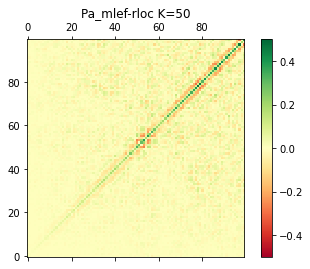

In [29]:
params = {'mlef':('mlef',None,False,False),'mlef-ss':('mlef',2,True,False),'mlef-rg':('mlef',2,False,True),'mlef-rloc':('mlef',0,False,False)}
names2 = ['mlef','mlef-ss','mlef-rg','mlef-rloc']
#names = ['mod','srf']#,'srf-ss','srf-kloc']
#Pa_app_list = [Pam]
from analysis.mlef import Mlef
from analysis.mlef_rloc import Mlef_rloc
for ptype in names2:
    pt, iloc, ss, gain = params[ptype]
    if ptype != 'mlef-rloc':
        analysis = Mlef(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, gain=gain, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    else:
        analysis = Mlef_rloc(pt, K, obs, lsig=3.0, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    xa_list.append(xa[:,0])
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    #if ntest == 0:
    #    fig.savefig(f'Pa_{ptype}_{K}.pdf')
    plt.show()

In [30]:
method = names + names2
#print(names)
xrmse = [0.0]
mse_list = []
corr_list = []
i = 1
for xam in xa_list:
    #print(xam)
    if i < len(names):
        print(f"method:{method[i]} mean")
        xrmse.append(np.sqrt(((xam - xt)**2).mean())/initial_mean_err)
    else:
        print(f"method:{method[i]} ctrl")
        xrmse.append(np.sqrt(((xam - xt)**2).mean())/initial_ctrl_err)
    i += 1
print(method)
print(f"initial error : mean={initial_mean_err}, ctrl={initial_ctrl_err} obs error:{obs.get_sig()}")
print(xrmse)
for Pa_app in Pa_app_list:
    mse_list.append(mse(Pa_app))
    corr_list.append(corr(Pa_app))
print(mse_list)
print(corr_list)
xrmse_mean.append(xrmse)
mse_mean.append(mse_list)
corr_mean.append(corr_list)
ntest += 1

method:etkf mean
method:etkf-ss mean
method:etkf-rg mean
method:etkf-kloc mean
method:po mean
method:po-mod mean
method:po-kloc mean
method:srf mean
method:srf-ss mean
method:srf-rg mean
method:srf-kloc mean
method:letkf mean
method:mlef ctrl
method:mlef-ss ctrl
method:mlef-rg ctrl
method:mlef-rloc ctrl
['mod', 'etkf', 'etkf-ss', 'etkf-rg', 'etkf-kloc', 'po', 'po-mod', 'po-kloc', 'srf', 'srf-ss', 'srf-rg', 'srf-kloc', 'letkf', 'mlef', 'mlef-ss', 'mlef-rg', 'mlef-rloc']
initial error : mean=1.2576255262244644, ctrl=1.2874652336008925 obs error:0.125
[0.0, 0.5784844821269244, 0.36907570498895453, 0.36907570498895453, 0.4524205215458122, 0.5784844821269243, 0.36907570498895453, 0.45242052154581164, 0.5991551958551856, 0.42979196928835045, 0.42979196928835045, 6491034.360506932, 0.40187217020573923, 0.7411871996112961, 0.544249160285062, 0.544249160285062, 0.5728015365651594]
[0.00015287680980752123, 0.00036911878408560887, 0.00047288136003949017, 0.00034571452152850366, 0.0003691187840856

## Check results

In [215]:
print(ntest)
print(np.array(mse_mean).shape)
rmse_m = np.array(xrmse_mean).mean(axis=0)
rmse_s = np.sqrt(((np.array(xrmse_mean) - rmse_m[None,:])**2).sum(axis=0)/(ntest-1))
mse_m = np.array(mse_mean).mean(axis=0)
mse_s = np.sqrt(((np.array(mse_mean) - mse_m[None,:])**2).sum(axis=0)/(ntest-1))
corr_m = np.array(corr_mean).mean(axis=0)
corr_s = np.sqrt(((np.array(corr_mean) - corr_m[None,:])**2).sum(axis=0)/(ntest-1))
for i in range(len(method)):
    print("{:9} {:5.3e}({:5.3e}) {:5.3e}({:5.3e}) {:5.3e}({:5.3e})"
          .format(method[i], rmse_m[i], rmse_s[i], mse_m[i], mse_s[i], corr_m[i], corr_s[i]))
#print(method)
#print(rmse_m)
#print(rmse_s)
#print(mse_m)
#print(mse_s)
#print(corr_m)
#print(corr_s)

10
(10, 17)
mod       0.000e+00(0.000e+00) 1.084e-04(1.422e-05) 9.484e-01(5.581e-03)
etkf      5.536e-01(9.584e-02) 4.025e-04(2.612e-05) 6.835e-01(9.763e-03)
etkf-ss   4.364e-01(7.623e-02) 3.858e-04(3.729e-05) 7.200e-01(1.199e-02)
etkf-rg   4.364e-01(7.623e-02) 2.676e-04(2.173e-05) 7.519e-01(1.181e-02)
etkf-kloc 4.818e-01(7.580e-02) 4.025e-04(2.612e-05) 6.835e-01(9.763e-03)
po        5.536e-01(9.584e-02) 4.401e-04(2.444e-05) 6.348e-01(6.755e-03)
po-mod    4.364e-01(7.623e-02) 2.856e-04(1.541e-05) 7.378e-01(1.247e-02)
po-kloc   4.818e-01(7.580e-02) 6.252e-04(9.663e-05) 6.652e-01(1.571e-02)
srf       2.585e+00(4.053e+00) 5.672e-02(1.084e-02) 1.604e-01(1.404e-02)
srf-ss    4.840e-01(8.909e-02) 5.493e-03(1.095e-02) 6.206e-01(2.248e-01)
srf-rg    4.840e-01(8.909e-02) 4.494e-03(9.131e-03) 6.314e-01(2.311e-01)
srf-kloc  8.105e+10(2.512e+11) 5.672e-02(1.084e-02) 1.604e-01(1.404e-02)
letkf     4.525e-01(7.803e-02) 2.857e-04(2.010e-05) 7.305e-01(1.227e-02)
mlef      5.513e-01(1.222e-01) 4.025e-0

In [186]:
print(np.array(xrmse_mean)[:,8])

[ 0.80246328  0.7910644   1.02816301  0.85896226  3.71135795  0.93230248
  0.79720744  0.80828731 11.18517452  0.68577241]


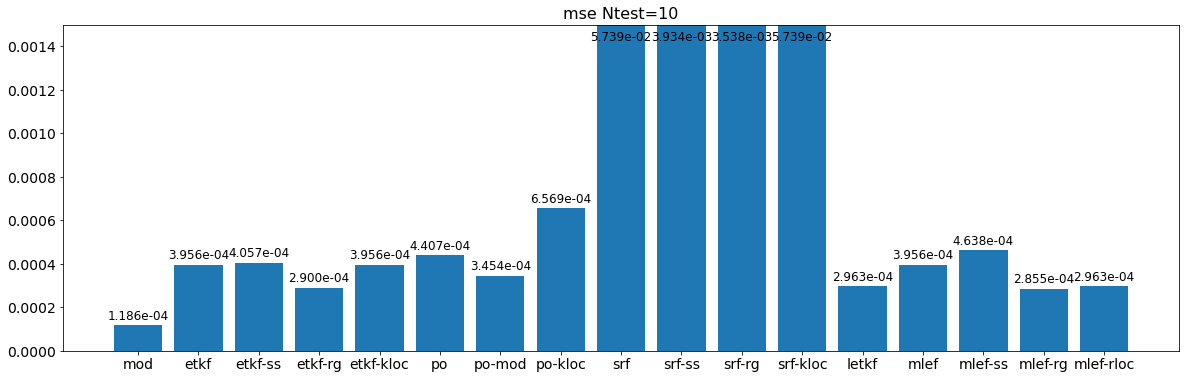

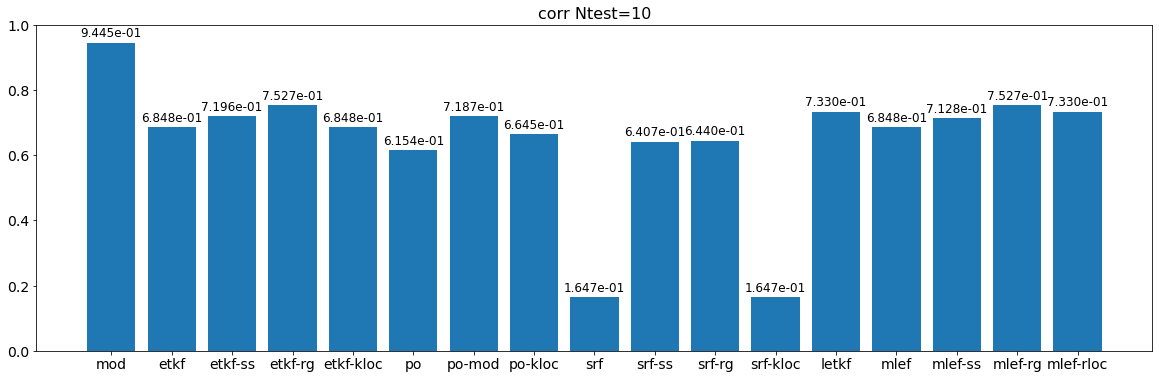

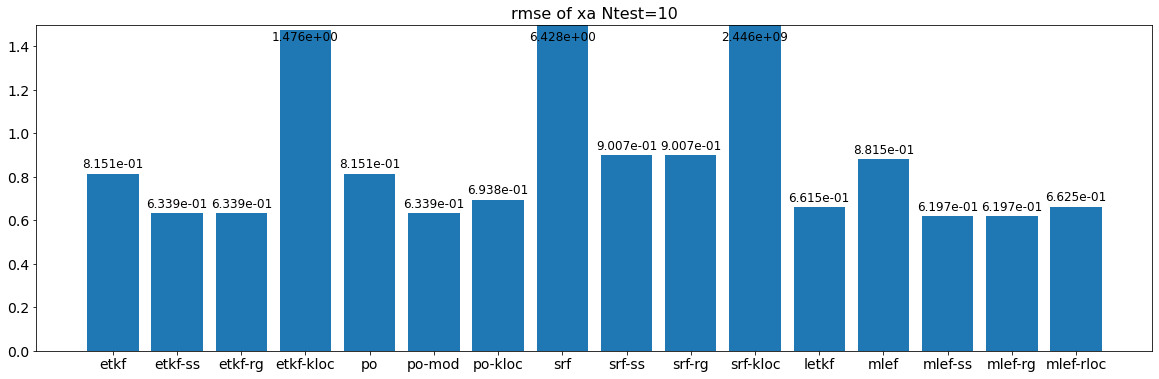

In [175]:
def autolabel(rects, set_lim=None):
    for rect in rects:
        height = rect.get_height()
        if set_lim is not None:
            height_t = min(height, set_lim)
        else:
            height_t = height
        ax.annotate('{:5.3e}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height_t),
                   xytext=(0, 3),
                   textcoords='offset points',
                   ha='center', va='bottom',
                   fontsize=12)
        
#names = ['mod','ss','rg','po','kloc']
#names = ['mod','etkf','etkf-ss','etkf-rg','etkf-kloc','po','po-mod','po-kloc','srf','srf-ss','srf-rg','srf-kloc','letkf','mlef','mlef-ss','mlef-rg','mlef-rloc']
names = method
fig, ax = plt.subplots(figsize=(20,6))
width = 0.25
xaxis = np.arange(len(Pa_app_list))
#xaxis1 = xaxis - width / 2
#xaxis2 = xaxis + width / 2
rects = ax.bar(names, mse_m)#, label="mse")
#ax.legend()
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5e-3)
autolabel(rects, set_lim=1.4e-3)
ax.set_title(f"mse Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('mse.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(names, corr_m)#, label="corr")
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.0)
autolabel(rects)
ax.set_title(f"corr Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('corr.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(names[1:], rmse_m[1:])#, label="corr")
ax.set_xticks(names[1:])
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5)
autolabel(rects, set_lim=1.4)
ax.set_title(f"rmse of xa Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('rmse.pdf')
plt.show()

## error norm tendency

In [44]:
Nens = [10, 20, 50, 100, 200, 500, 1000]
rs = np.random.RandomState()
errd = np.zeros(len(Nens))
errnd = np.zeros(len(Nens))
nPt = Pt - np.diag(np.diag(Pt))
Ntest = 100
for j, K in zip(np.arange(errd.size),Nens):
    for i in range(Ntest):
        Xf = rs.standard_normal(size=(N,K))
        Xf = sPt @ Xf
        Xf = Xf - Xf.mean(axis=1)[:, None]
        Pe = Xf @ Xf.transpose() / (K-1)
        errnorm = norm(np.diag(Pt) - np.diag(Pe))
        #if np.mod(i, 10) == 0:
        #    print(K,i,errnorm)
        errd[j] += errnorm
        Pe -= np.diag(np.diag(Pe)) - np.diag(np.diag(Pt))
        errnorm = norm(nPt - Pe)
        errnd[j] += errnorm
errd /= Ntest
errnd /= Ntest
print(errd)
print(errnd)

[4.54666053 3.28515271 2.04974714 1.39764678 0.9893927  0.6411916
 0.45391613]
[34.50326565 25.79367496 17.59743138 14.41476607 12.36055522 10.99940219
 10.51034022]


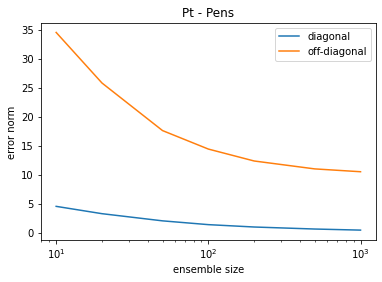

In [46]:
fig, ax = plt.subplots()
ax.plot(Nens, errd, label="diagonal")
ax.plot(Nens, errnd, label="off-diagonal")
ax.set_ylabel("error norm")
ax.set_xlabel("ensemble size")
ax.set_xscale("log")
ax.set_title("Pt - Pens")
ax.legend()
plt.show()